In [1]:
%pip install jupysql clickhouse_sqlalchemy matplotlib python-dotenv pandas seaborn imageio > /dev/null 2>&1

Note: you may need to restart the kernel to use updated packages.


In [2]:
import dotenv
import os
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import imageio

dotenv.load_dotenv()

True

In [3]:
def add_branding(fig, title=None, subtitle=None):
    # Get dimensions of input figure
    fig_width = fig.get_size_inches()[0]
    
    # Create header figure with fixed height (reduced to 25%)
    header_height = 1 # Was 2
    header_fig = plt.figure(figsize=(fig_width, header_height))
    
    # Add logos with increased size
    left_logo_ax = header_fig.add_axes([0.02, 0.2, 0.18, 0.7])  # Increased width and height
    right_logo_ax = header_fig.add_axes([0.82, 0.2, 0.16, 0.7]) # Increased width and height
    
    ethpandaops = plt.imread('../../assets/content/ethpandaops.png')
    xatu = plt.imread('../../assets/content/xatu.png')
    
    left_logo_ax.imshow(ethpandaops)
    right_logo_ax.imshow(xatu)
    
    left_logo_ax.axis('off')
    right_logo_ax.axis('off')
    
    # Add title and subtitle if provided
    if title:
        header_fig.text(0.5, 0.7, title, fontsize=20, fontweight='bold', ha='center')
    if subtitle:
        header_fig.text(0.5, 0.4, subtitle, fontsize=12, ha='center')
        
    # Stack figures
    combined_height = header_height + fig.get_size_inches()[1]
    combined_fig = plt.figure(figsize=(fig_width, combined_height))
    
    # Draw figures before accessing canvas
    header_fig.canvas.draw()
    fig.canvas.draw()
    
    # Copy contents using buffer_rgba instead of deprecated tostring_rgb
    header_img = np.frombuffer(header_fig.canvas.buffer_rgba(), dtype=np.uint8)
    header_img = header_img.reshape(header_fig.canvas.get_width_height()[::-1] + (4,))[:,:,:3]
    
    fig_img = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    fig_img = fig_img.reshape(fig.canvas.get_width_height()[::-1] + (4,))[:,:,:3]
    
    # Add to combined figure with reduced padding
    # Move header down slightly to reduce space at top
    header_ax = combined_fig.add_axes([0, fig.get_size_inches()[1]/combined_height + 0.02, 1, (header_height-0.2)/combined_height])
    # Move content up to reduce gap between header and content
    content_ax = combined_fig.add_axes([0, 0.02, 1, (fig.get_size_inches()[1]-0.2)/combined_height])
    
    header_ax.imshow(header_img)
    content_ax.imshow(fig_img)
    
    header_ax.axis('off')
    content_ax.axis('off')
    
    plt.close(header_fig)
    plt.close(fig)
    
    return combined_fig

In [4]:

class Config:
    def __init__(self, time_ranges, network):
        self.time_ranges = time_ranges
        self.network = network


config = Config(
    [
        ("2025-03-25T12:10:00Z", "2025-03-25T18:10:00Z"),
        ("2025-03-27T12:10:00Z", "2025-03-27T18:10:00Z")
    ],
    "hoodi"
)

event_date = pd.to_datetime("2025-03-26T14:37:12Z", utc=True)
event_date_naive = event_date.tz_localize(None) if event_date.tzinfo is not None else event_date

annotations = {
    "2025-03-26T14:37:12Z": "Hoodi Electra Fork",
}

# Convert annotation timestamps to datetime objects for later use
annotation_datetimes = {
    datetime.fromisoformat(ts.replace("Z", "+00:00")): msg
    for ts, msg in annotations.items()
}

# Print the config contents
print("config network:", config.network)
print("config time ranges:", config.time_ranges)
print("event date:", event_date)


config network: hoodi
config time ranges: [('2025-03-25T12:10:00Z', '2025-03-25T18:10:00Z'), ('2025-03-27T12:10:00Z', '2025-03-27T18:10:00Z')]
event date: 2025-03-26 14:37:12+00:00


In [5]:
# Connect to ClickHouse
import os
username = os.getenv('XATU_CLICKHOUSE_USERNAME')
password = os.getenv('XATU_CLICKHOUSE_PASSWORD')
host = os.getenv('XATU_CLICKHOUSE_HOST')


db_url = f"clickhouse+http://{username}:{password}@{host}:443/default?protocol=https"

from sqlalchemy import create_engine, text

engine = create_engine(db_url)

connection = engine.connect()

In [6]:
# Load known validators from the YAML file
import yaml
import os
from pathlib import Path

def load_validators(network):
    """Load validators from the YAML file for the specified network."""
    validators_path = Path(f"../../assets/ethereum/{network}/validators.yaml")
    
    if not validators_path.exists():
        print(f"Validators file not found at {validators_path}")
        return {}
    
    with open(validators_path, 'r') as file:
        validators_data = yaml.safe_load(file)
    
    # Process the validators data
    validators_map = {}
    for range_str, client in validators_data.items():
        if isinstance(range_str, str) and '-' in range_str:
            start, end = map(int, range_str.split('-'))
            for validator_index in range(start, end + 1):
                validators_map[validator_index] = client
        elif isinstance(range_str, int):
            # Handle single validator case
            validators_map[range_str] = client
    
    return validators_map

def get_validator_entity(validator_index, validators_map):
    """Get the entity/client associated with a validator index."""
    if validator_index in validators_map:
        return validators_map[validator_index]
    return "unknown"

def get_validator_entities(validator_indices, validators_map):
    """Get entities for multiple validator indices."""
    return {idx: get_validator_entity(idx, validators_map) for idx in validator_indices}

def is_validator_from_entity(validator_index, entity, validators_map):
    """Check if a validator belongs to a specific entity."""
    return get_validator_entity(validator_index, validators_map) == entity

# Load validators for the configured network
validators = load_validators(config.network)
print(f"Loaded {len(validators)} validators for {config.network}")


Loaded 1060000 validators for hoodi


In [7]:
# We'll be loading in all the `elaborated_attestations` from the `canonical_beacon_elab_attestations` table
# canonical_beacon_elaborated_attestation
# #
# Contains elaborated attestations from beacon blocks.

# Availability
# #
# Data is partitioned daily on slot_start_date_time for the following networks:

# mainnet: 2020-12-01 to 2025-03-10
# holesky: 2023-09-23 to 2025-03-11
# sepolia: 2022-06-22 to 2025-03-10
# Examples
# #
# Parquet file
# Your Clickhouse
# EthPandaOps Clickhouse
# Columns
# #
# Name	Type	Description
# updated_date_time	DateTime	When this row was last updated
# block_slot	UInt32	The slot number of the block containing the attestation
# block_slot_start_date_time	DateTime	The wall clock time when the block slot started
# block_epoch	UInt32	The epoch number of the block containing the attestation
# block_epoch_start_date_time	DateTime	The wall clock time when the block epoch started
# position_in_block	UInt32	The position of the attestation in the block
# block_root	FixedString(66)	The root of the block containing the attestation
# validators	Array(UInt32)	Array of validator indices participating in the attestation
# committee_index	LowCardinality(String)	The index of the committee making the attestation
# beacon_block_root	FixedString(66)	The root of the beacon block being attested to
# slot	UInt32	The slot number being attested to
# slot_start_date_time	DateTime	**
# epoch	UInt32	**
# epoch_start_date_time	DateTime	**
# source_epoch	UInt32	The source epoch referenced in the attestation
# source_epoch_start_date_time	DateTime	The wall clock time when the source epoch started
# source_root	FixedString(66)	The root of the source checkpoint in the attestation
# target_epoch	UInt32	The target epoch referenced in the attestation
# target_epoch_start_date_time	DateTime	The wall clock time when the target epoch started
# target_root	FixedString(66)	The root of the target checkpoint in the attestation
# meta_client_name	LowCardinality(String)	Name of the client that generated the event
# meta_client_id	String	Unique Session ID of the client that generated the event. This changes every time the client is restarted.
# meta_client_version	LowCardinality(String)	Version of the client that generated the event
# meta_client_implementation	LowCardinality(String)	Implementation of the client that generated the event
# meta_client_os	LowCardinality(String)	Operating system of the client that generated the event
# meta_client_ip	Nullable(IPv6)	IP address of the client that generated the event
# meta_client_geo_city	LowCardinality(String)	City of the client that generated the event
# meta_client_geo_country	LowCardinality(String)	Country of the client that generated the event
# meta_client_geo_country_code	LowCardinality(String)	Country code of the client that generated the event
# meta_client_geo_continent_code	LowCardinality(String)	Continent code of the client that generated the event
# meta_client_geo_longitude	Nullable(Float64)	Longitude of the client that generated the event
# meta_client_geo_latitude	Nullable(Float64)	Latitude of the client that generated the event
# meta_client_geo_autonomous_system_number	Nullable(UInt32)	Autonomous system number of the client that generated the event
# meta_client_geo_autonomous_system_organization	Nullable(String)	Autonomous system organization of the client that generated the event
# meta_network_id	Int32	Ethereum network ID
# meta_network_name	LowCardinality(String)	Ethereum network name
# meta_consensus_version	LowCardinality(String)	Ethereum consensus client version that generated the event
# meta_consensus_version_major	LowCardinality(String)	Ethereum consensus client major version that generated the event
# meta_consensus_version_minor	LowCardinality(String)	Ethereum consensus client minor version that generated the event
# meta_consensus_version_patch	LowCardinality(String)	Ethereum consensus client patch version that generated the event
# meta_consensus_implementation	LowCardinality(String)	Ethereum consensus client implementation that generated the event
# meta_labels	Map(String, String)	Labels associated with the event

# Load all elaborated attestations for the time period
all_attestations = pd.DataFrame()

for start_date, end_date in config.time_ranges:
    print(f"Loading attestations for time range: {start_date} to {end_date} for network: {config.network}")
    
    attestations_query = text("""
        SELECT
            block_slot,
            block_slot_start_date_time,
            validators,
            committee_index,
            slot,
            slot_start_date_time,
            epoch,
            position_in_block
        FROM canonical_beacon_elaborated_attestation
        WHERE
            block_epoch_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
            AND meta_network_name = :network
        ORDER BY block_slot ASC, position_in_block ASC
    """)

    result = connection.execute(attestations_query, {
        "start_date": start_date.replace('Z', ''), 
        "end_date": end_date.replace('Z', ''), 
        "network": config.network
    })
    
    current_attestations = pd.DataFrame(result.fetchall(), columns=[
        'block_slot', 'block_slot_start_date_time', 
        'validators', 'committee_index', 'slot', 'slot_start_date_time',
        'epoch', 'position_in_block'
    ])
    
    # Parse validators column if it's a string
    if len(current_attestations) > 0 and isinstance(current_attestations['validators'].iloc[0], str):
        current_attestations['validators'] = current_attestations['validators'].apply(
            lambda x: eval(x) if isinstance(x, str) else x
        )

    print(f"loaded {len(current_attestations)} attestations from time window {start_date} to {end_date}")
    
    all_attestations = pd.concat([all_attestations, current_attestations])

print(f"Loaded {len(all_attestations)} attestations")


Loading attestations for time range: 2025-03-25T12:10:00Z to 2025-03-25T18:10:00Z for network: hoodi
loaded 167785 attestations from time window 2025-03-25T12:10:00Z to 2025-03-25T18:10:00Z
Loading attestations for time range: 2025-03-27T12:10:00Z to 2025-03-27T18:10:00Z for network: hoodi
loaded 246707 attestations from time window 2025-03-27T12:10:00Z to 2025-03-27T18:10:00Z
Loaded 414492 attestations


In [8]:
# Add on the proposer index by fetching the entire block data from the beacon_api_eth_v2_beacon_block table
def fetch_proposer_indices(time_ranges, network):
    all_proposer_indices = []
    for start_date, end_date in time_ranges:
        proposer_indices_query = text("""
            SELECT
                slot,
                proposer_index
            FROM canonical_beacon_block FINAL
            WHERE
                slot_start_date_time BETWEEN toDateTime(:start_date, 'UTC') AND toDateTime(:end_date, 'UTC')
                AND meta_network_name = :network
            ORDER BY slot ASC
        """)
        proposer_indices = pd.DataFrame(
            connection.execute(proposer_indices_query, {"start_date": start_date.replace('Z', ''), "end_date": end_date.replace('Z', ''), "network": network}).fetchall(),
            columns=['slot', 'proposer_index']
        )
        all_proposer_indices.append(proposer_indices)
    
    return pd.concat(all_proposer_indices, ignore_index=True)

proposer_indices = fetch_proposer_indices(config.time_ranges, config.network)

# Get the proposer entity from validators map
proposer_indices['entity'] = proposer_indices['proposer_index'].apply(
    lambda x: get_validator_entity(x, validators)
)

# Convert proposer_index to int64 to ensure proper matching during merge
proposer_indices['proposer_index'] = proposer_indices['proposer_index'].astype('int64')

proposer_indices


slot  proposer_index       entity
0     57600          860110       galaxy
1     57601          839932          ssv
2     57602          582918         besu
3     57603           17881  ethpandaops
4     57604          622614         besu
...     ...             ...          ...
3228  73796          218460  ethpandaops
3229  73797          438361     lodestar
3230  73798          189540  ethpandaops
3231  73799          301208        prysm
3232  73800          860169       galaxy

[3233 rows x 3 columns]

In [9]:
metrics = {
    "Attestation Inclusion": {
        "description": (
            "Metrics measuring how effectively attestations are being included in blocks.\n"
            "These metrics help evaluate the attestation aggregation changes in the Electra fork.\n"
            "They focus on validator participation and timeliness of attestation inclusion.\n"
        ),
        "metrics": {
            "unique_validator_indexes": "Number of unique validator indexes included in all of the block's attestations.",
            "unique_committees": "Number of unique committees represented in all of the block's attestations.",
            "first_seen_attestations": "Number of validator votes that are included for the first time in the block.",
            "total_attestations": "Total number of attestations included in the block.",
            "head_timely_validators": "Number of validators that included the head attestation in the block.",
            "head_timely_rate": "Ratio of head timely validators to total unique validators in the block.",
        }
    },
    "Attestation Aggregation Efficiency": {
        "description": (
            "Metrics evaluating how efficiently attestations are being aggregated.\n"
            "These help measure the impact of aggregation changes in the Electra fork.\n"
            "Higher aggregation efficiency means more validator votes included with less data overhead.\n"
        ),
        "metrics": {
            "avg_validators_per_attestation": "Average number of validator indexes per attestation.",
            "max_validators_per_attestation": "Maximum number of validator indexes in any single attestation.",
            "aggregation_efficiency": "Ratio of unique validator attestations to total attestation objects (higher is better).",
        }
    },
    "Attestation Inclusion Delay": {
        "description": (
            "Metrics focused on the timing aspects of attestation inclusion.\n"
            "These metrics help identify how quickly attestations are being included after their target slots.\n"
            "Important for understanding network propagation and aggregation speed improvements.\n"
        ),
        "metrics": {
            "min_attestation_inclusion_delay": "Minimum inclusion delay (in slots) between attestation slot and inclusion slot.",
            "avg_attestation_inclusion_delay": "Average inclusion delay (in slots) between attestation slot and inclusion slot.",
            "p50_attestation_inclusion_delay": "Median inclusion delay (in slots) between attestation slot and inclusion slot.",
            "p95_attestation_inclusion_delay": "95th percentile inclusion delay (in slots) between attestation slot and inclusion slot.",
            "max_attestation_inclusion_delay": "Maximum inclusion delay (in slots) between attestation slot and inclusion slot.",            
        }
    },
    "Attestation Inclusion Distribution Per Position": {
        "description": {},
        "metrics": {
            "position_0_average_inclusion_delay": "The average inclusion delay of the attestation included in position 0 of the block",
            "position_1_average_inclusion_delay": "The average inclusion delay of the attestation included in position 0 of the block",
            "position_2_average_inclusion_delay": "The average inclusion delay of the attestation included in position 0 of the block",
            "position_3_average_inclusion_delay": "The average inclusion delay of the attestation included in position 0 of the block",
            "position_4_average_inclusion_delay": "The average inclusion delay of the attestation included in position 0 of the block",
            "position_5_average_inclusion_delay": "The average inclusion delay of the attestation included in position 0 of the block",
            "position_6_average_inclusion_delay": "The average inclusion delay of the attestation included in position 0 of the block",
            "position_7_average_inclusion_delay": "The average inclusion delay of the attestation included in position 0 of the block",
        }
    },
    "Consecutive Missed Slots": {
        "description": {},
        "metrics": {
            "consecutive_missed_slots_1": "The count of times where 1 slot in a row was missed",
            "consecutive_missed_slots_2": "The count of times where 2 slots in a row were missed",
            "consecutive_missed_slots_3": "The count of times where 3 slots in a row were missed",
            "consecutive_missed_slots_4": "The count of times where 4 slots in a row were missed",
            "consecutive_missed_slots_5": "The count of times where 5 slots in a row were missed",
        }
    }
}

def get_full_metric_description(metric_name):
    """
    Combines the top-level description with the specific metric description.
    
    Args:
        metric_name: The name of the metric to get the description for
        
    Returns:
        A combined description string or None if metric not found
    """
    for category, data in metrics.items():
        if metric_name in data["metrics"]:
            return f"{data['description']} {data['metrics'][metric_name]}"
    return None

In [19]:
import numpy as np
import pandas as pd

def calculate_slot_metrics(group):
    """Calculates metrics for a single block slot. Does not modify the input group."""

    if group.empty:
        # Return NaNs or appropriate defaults for empty groups
        metrics = {
            'unique_validator_indexes': 0,
            'unique_committees': 0,
            'total_attestations': 0,
            'head_timely_validators': 0,
            'head_timely_rate': 0,
            'avg_validators_per_attestation': np.nan,
            'max_validators_per_attestation': np.nan,
            'min_attestation_inclusion_delay': np.nan,
            'avg_attestation_inclusion_delay': np.nan,
            'p50_attestation_inclusion_delay': np.nan,
            'p95_attestation_inclusion_delay': np.nan,
            'max_attestation_inclusion_delay': np.nan,
            'aggregation_efficiency': np.nan,
            'first_seen_attestations': np.nan,
            'block_slot_start_date_time': pd.NaT
        }
        # Add position-specific metrics
        for i in range(8):
            metrics[f'position_{i}_average_inclusion_delay'] = np.nan
        return pd.Series(metrics)
    # Calculate temporary series needed for metrics
    attestation_delay = group['block_slot'] - group['slot']

    negative_delays = attestation_delay[attestation_delay < 0]
    if not negative_delays.empty:
        print(f"Negative delays found: {negative_delays}")
        exit()

    # Explode validators for unique count
    validators_list = group['validators'].tolist()
    flat_validators = []
    
    for validator_array in validators_list:
        # Check if already a list or needs parsing
        if isinstance(validator_array, list):
            flat_validators.extend(validator_array)
        elif isinstance(validator_array, str) and validator_array.startswith('['):
            # Parse string representation
            import ast
            try:
                parsed = ast.literal_eval(validator_array)
                if isinstance(parsed, list):
                    flat_validators.extend(parsed)
            except:
                pass
    
    all_validators_in_slot = np.unique(np.array(flat_validators))
    unique_validator_count = len(all_validators_in_slot)

    # head_timely_validators - count unique validators with delay=1
    head_timely_mask = attestation_delay == 1
    head_timely_group = group[head_timely_mask]
    
    # Get unique validators from attestations with delay=1
    head_timely_validators_list = []
    for validator_array in head_timely_group['validators'].tolist():
        if isinstance(validator_array, list):
            head_timely_validators_list.extend(validator_array)
        elif isinstance(validator_array, str) and validator_array.startswith('['):
            import ast
            try:
                parsed = ast.literal_eval(validator_array)
                if isinstance(parsed, list):
                    head_timely_validators_list.extend(parsed)
            except:
                pass
    
    # Count unique validators with delay=1
    head_timely_validators = len(np.unique(np.array(head_timely_validators_list)))
    head_timely_rate = head_timely_validators / unique_validator_count if unique_validator_count > 0 else 0

    num_signatures = group['validators'].apply(len)
    total_attestations_count = len(group)

    metrics = {
        # Attestation Inclusion
        'unique_validator_indexes': unique_validator_count,
        'unique_committees': group['committee_index'].nunique(),
        'total_attestations': total_attestations_count,
        'head_timely_validators': head_timely_validators,
        'head_timely_rate': head_timely_rate,
        # Attestation Aggregation
        'avg_validators_per_attestation': num_signatures.mean(),
        'max_validators_per_attestation': num_signatures.max(),

        # Attestation Inclusion Delay
        'min_attestation_inclusion_delay': attestation_delay.min(),
        'avg_attestation_inclusion_delay': attestation_delay.mean(),
        'p50_attestation_inclusion_delay': attestation_delay.quantile(0.50),
        'p95_attestation_inclusion_delay': attestation_delay.quantile(0.95),
        'max_attestation_inclusion_delay': attestation_delay.max(),
    }

    # Calculate position-specific metrics
    for i in range(8):
        position_data = group[group['position_in_block'] == i]
        if not position_data.empty:
            position_delay = position_data['block_slot'] - position_data['slot']
            metrics[f'position_{i}_average_inclusion_delay'] = position_delay.mean()
        else:
            metrics[f'position_{i}_average_inclusion_delay'] = np.nan

    # Derived metric
    if total_attestations_count > 0:
        metrics['aggregation_efficiency'] = unique_validator_count / total_attestations_count
    else:
        metrics['aggregation_efficiency'] = np.nan # Avoid division by zero

    # Add block timestamp for reference (identifying column)
    # block_slot is the index of the resulting series/dataframe
    metrics['block_slot_start_date_time'] = group['block_slot_start_date_time'].iloc[0]
    # Note: block_epoch is not in the original query's selected columns for all_attestations

    return pd.Series(metrics)

# Dictionary to track seen attestations: {slot: {validator_index: True}}
seen_attestations = {}

def calculate_first_seen_attestations(df):
    """
    Process the dataframe to calculate first_seen_attestations for each block.
    Maintains a rolling window of 65 slots to track previously seen validator attestations.
    """
    # Sort by block_slot to ensure chronological processing
    df = df.sort_values(['block_slot', 'slot']).copy()
    
    # Add a column to track first seen validators per attestation
    df['first_seen_validators'] = 0
    
    # Dictionary to track seen attestations: {slot: {validator_index: True}}
    seen_attestations = {}
    
    # Process each row to identify first seen attestations
    for idx, row in df.iterrows():
        block_slot = row['block_slot']
        attestation_slot = row['slot']
        validator_indexes = row['validators']
        if isinstance(validator_indexes, str) and validator_indexes.startswith('['):
            # Parse string representation
            import ast
            try:
                validator_indexes = ast.literal_eval(validator_indexes)
            except:
                validator_indexes = []
        
        # Clean up old slots (keep only last 65 slots)
        current_slots = list(seen_attestations.keys())
        for slot in current_slots:
            if block_slot - slot > 65:
                del seen_attestations[slot]
        
        # Count validators in this attestation not seen before for this slot
        first_seen_count = 0
        for validator_idx in validator_indexes:
            if attestation_slot not in seen_attestations or validator_idx not in seen_attestations[attestation_slot]:
                first_seen_count += 1
                # Initialize the slot dictionary if needed
                if attestation_slot not in seen_attestations:
                    seen_attestations[attestation_slot] = {}
                # Mark this validator as having attested for this slot
                seen_attestations[attestation_slot][validator_idx] = True
        
        # Store the count of first seen validators for this attestation
        df.at[idx, 'first_seen_validators'] = first_seen_count
    
    # Aggregate first seen validators by block_slot
    block_first_seen = df.groupby('block_slot')['first_seen_validators'].sum()
    
    return block_first_seen

def calculate_consecutive_missed_slots(df):
    """
    Calculate metrics for consecutive missed slots for each time range separately.
    
    Args:
        df: DataFrame with block_slot column
    
    Returns:
        DataFrame with consecutive missed slots metrics
    """
    # Initialize counters for consecutive missed slots
    consecutive_missed = {
        'consecutive_missed_slots_1': 0,
        'consecutive_missed_slots_2': 0,
        'consecutive_missed_slots_3': 0,
        'consecutive_missed_slots_4': 0,
        'consecutive_missed_slots_5': 0,
    }
    
    # Process each time range separately
    for start_date, end_date in config.time_ranges:
        # Filter data for this time range
        time_range_df = df[(df['block_slot_start_date_time'] >= pd.to_datetime(start_date.replace('Z', ''))) & 
                           (df['block_slot_start_date_time'] <= pd.to_datetime(end_date.replace('Z', '')))]
        
        if time_range_df.empty:
            continue
            
        # Get min and max slot for this time range
        min_slot = time_range_df['block_slot'].min()
        max_slot = time_range_df['block_slot'].max()
        
        # Create a set of all slots that have blocks in this time range
        slots_with_blocks = set(time_range_df['block_slot'].unique())
        
        # Track current streak of missed slots
        current_streak = 0
        
        # Iterate through each slot in the range
        for slot in range(min_slot, max_slot + 1):
            if slot not in slots_with_blocks:
                # This slot was missed
                current_streak += 1
            else:
                # This slot has a block, check if we had a streak before
                if 1 <= current_streak <= 5:
                    consecutive_missed[f'consecutive_missed_slots_{current_streak}'] += 1
                elif current_streak > 5:
                    # Count longer streaks in the 5+ category
                    consecutive_missed['consecutive_missed_slots_5'] += 1
                
                # Reset streak counter
                current_streak = 0
        
        # Check if we ended with a streak
        if 1 <= current_streak <= 5:
            consecutive_missed[f'consecutive_missed_slots_{current_streak}'] += 1
        elif current_streak > 5:
            consecutive_missed['consecutive_missed_slots_5'] += 1
    
    return pd.Series(consecutive_missed)

# Group by block_slot and apply the metric calculation to create a *new* DataFrame
print("Calculating metrics per slot...")
# First calculate basic metrics
slot_metrics_df = all_attestations.groupby('block_slot').apply(calculate_slot_metrics)

# Process attestations to calculate first_seen_attestations
print("Calculating first seen attestations...")
first_seen_counts = calculate_first_seen_attestations(all_attestations)

# Add first_seen_attestations to the metrics dataframe
slot_metrics_df['first_seen_attestations'] = first_seen_counts

# Calculate consecutive missed slots metrics
print("Calculating consecutive missed slots...")
consecutive_missed_metrics = calculate_consecutive_missed_slots(all_attestations)

# Add consecutive missed slots metrics to the dataframe
for metric, value in consecutive_missed_metrics.items():
    slot_metrics_df[metric] = value

print("Metrics calculation complete.")

# Add proposer_index to the metrics dataframe
slot_metrics_df = slot_metrics_df.reset_index()
slot_metrics_df = pd.merge(
    slot_metrics_df,
    proposer_indices[['slot', 'proposer_index', 'entity']],
    left_on='block_slot',
    right_on='slot',
    how='left'
)
slot_metrics_df = slot_metrics_df.drop('slot', axis=1).set_index('block_slot')

# Display the first few rows of the resulting metrics DataFrame
# This DataFrame contains only the block_slot (as index) and the calculated metrics + block_slot_start_date_time
print(slot_metrics_df.head())

# Display basic info about the new metrics DataFrame
print(slot_metrics_df.info())


Calculating metrics per slot...


/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_99591/3763772329.py:245: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  slot_metrics_df = all_attestations.groupby('block_slot').apply(calculate_slot_metrics)


Calculating first seen attestations...
Calculating consecutive missed slots...
Metrics calculation complete.
            unique_validator_indexes  unique_committees  total_attestations  \
block_slot                                                                    
57600                          32448                 64                  76   
57601                          54021                 64                 118   
57602                          58340                 64                 128   
57603                          39105                 64                 128   
57604                          30566                 64                 128   

            head_timely_validators  head_timely_rate  \
block_slot                                             
57600                        29552          0.910750   
57601                        29618          0.548268   
57602                        30382          0.520775   
57603                        30021          0.767702   
5

In [11]:
def get_entity_data(entity_name):
    """
    Prepares and filters data for a specific entity.
    
    Args:
        entity_name (str): The name of the entity to filter by
        
    Returns:
        DataFrame: Filtered and prepared data for the entity
    """
    if entity_name == "all":
        entity_data = slot_metrics_df
    else:
        # Filter for blocks proposed by the specified entity
        return slot_metrics_df[slot_metrics_df['proposer_index'].apply(lambda x: is_validator_from_entity(x, entity_name, validators))]

Plotting unique_validator_indexes for all
Plotting unique_committees for all


/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_99591/603468247.py:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_99591/603468247.py:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Plotting first_seen_attestations for all
Plotting total_attestations for all


/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_99591/603468247.py:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_99591/603468247.py:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Plotting head_timely_validators for all
Plotting head_timely_rate for all


/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_99591/603468247.py:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_99591/603468247.py:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Plotting avg_validators_per_attestation for all
Plotting max_validators_per_attestation for all


/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_99591/603468247.py:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_99591/603468247.py:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Plotting aggregation_efficiency for all
Plotting min_attestation_inclusion_delay for all


/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_99591/603468247.py:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_99591/603468247.py:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Plotting avg_attestation_inclusion_delay for all
Plotting p50_attestation_inclusion_delay for all


/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_99591/603468247.py:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_99591/603468247.py:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Plotting p95_attestation_inclusion_delay for all


/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_99591/603468247.py:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_99591/603468247.py:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Plotting max_attestation_inclusion_delay for all
Plotting position_0_average_inclusion_delay for all


/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_99591/603468247.py:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_99591/603468247.py:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Plotting position_1_average_inclusion_delay for all
Plotting position_2_average_inclusion_delay for all


/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_99591/603468247.py:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_99591/603468247.py:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Plotting position_3_average_inclusion_delay for all
Plotting position_4_average_inclusion_delay for all


/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_99591/603468247.py:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_99591/2453471124.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  combined_fig = plt.figure(figsize=(fig_width, combined_height))
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_99591/603468247.py:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_99591/2453471124.py:7: RuntimeWarning: More t

Plotting position_5_average_inclusion_delay for all
Plotting position_6_average_inclusion_delay for all


/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_99591/603468247.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(16, 9))
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_99591/603468247.py:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_99591/603468247.py:120: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Plotting position_7_average_inclusion_delay for all


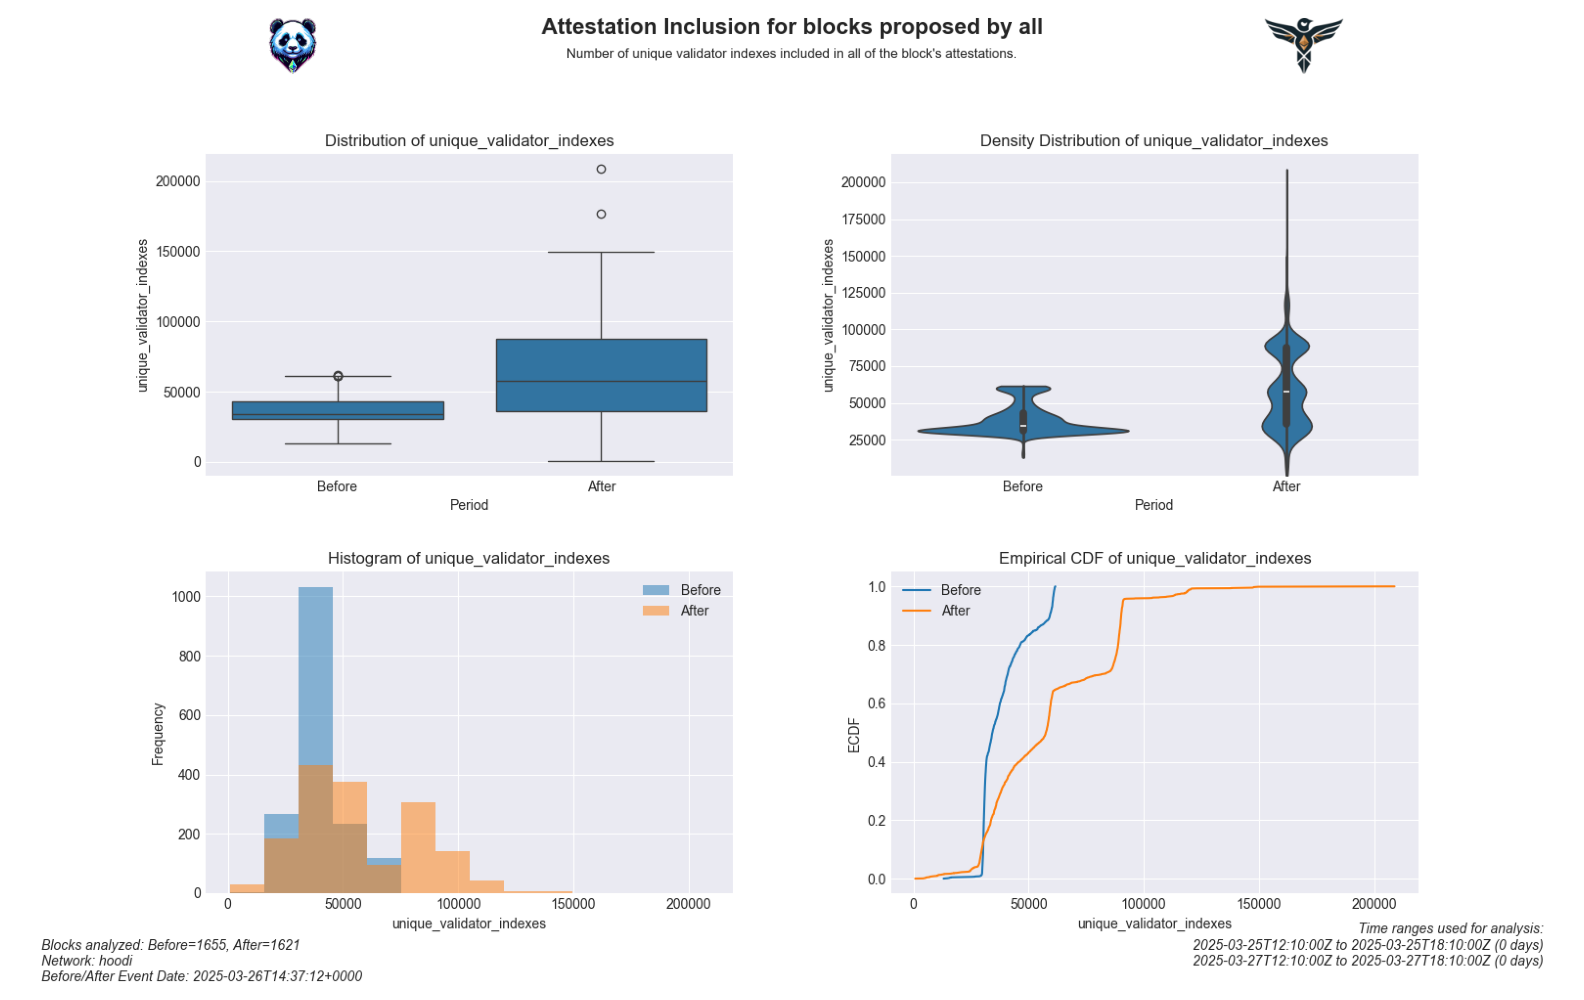

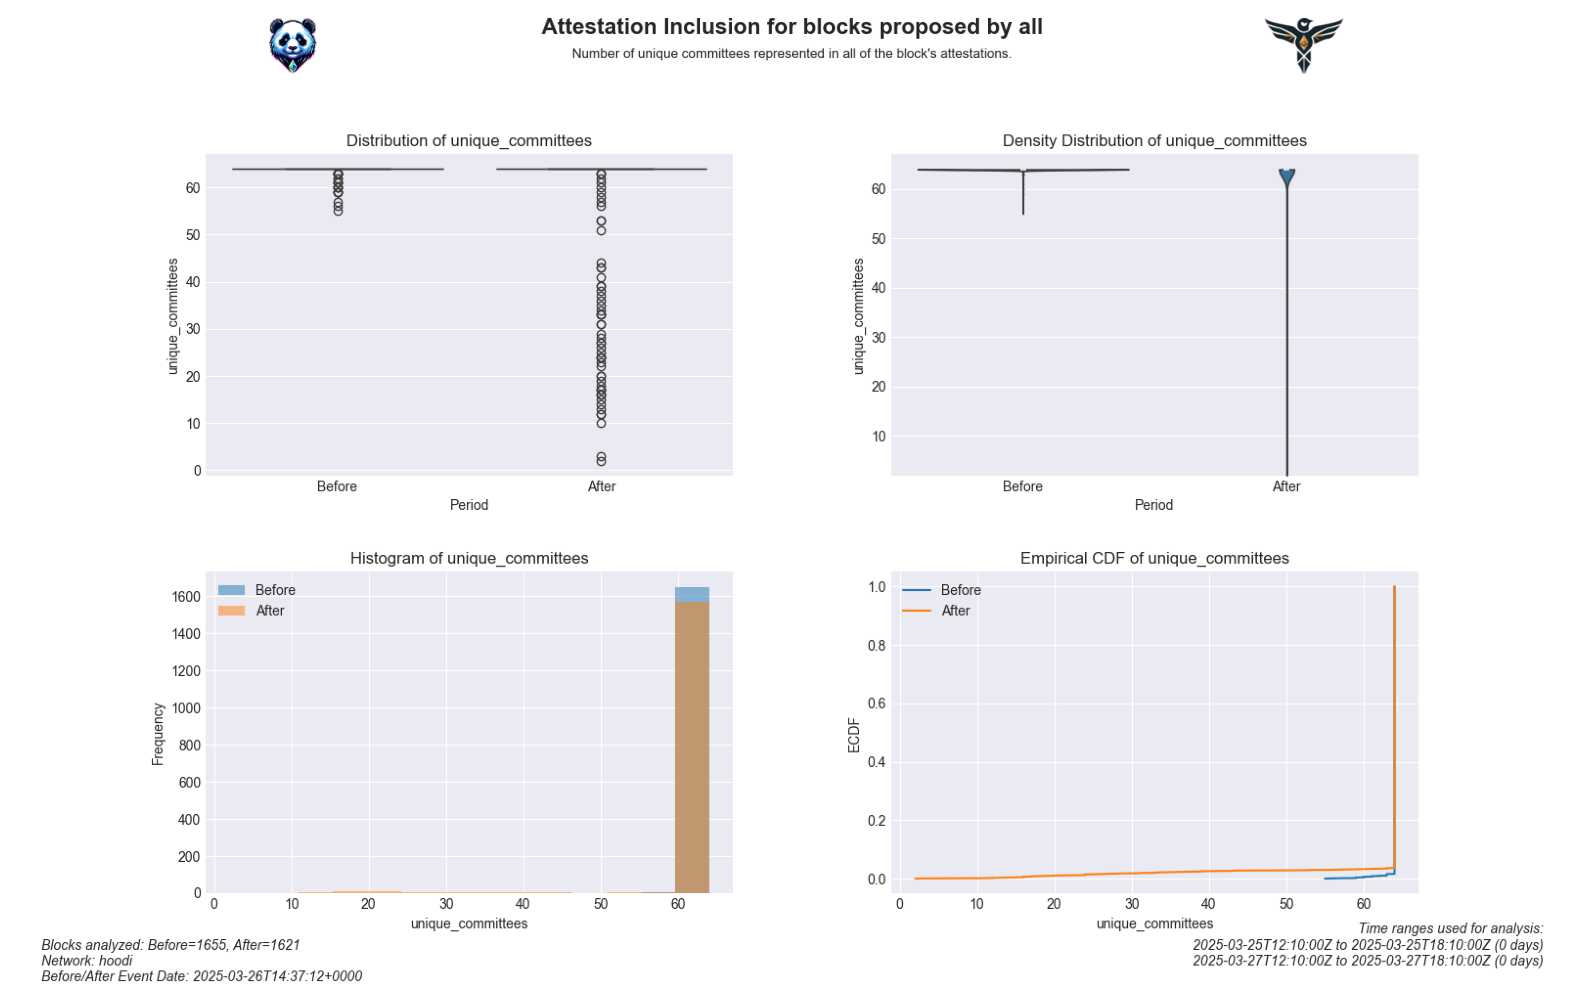

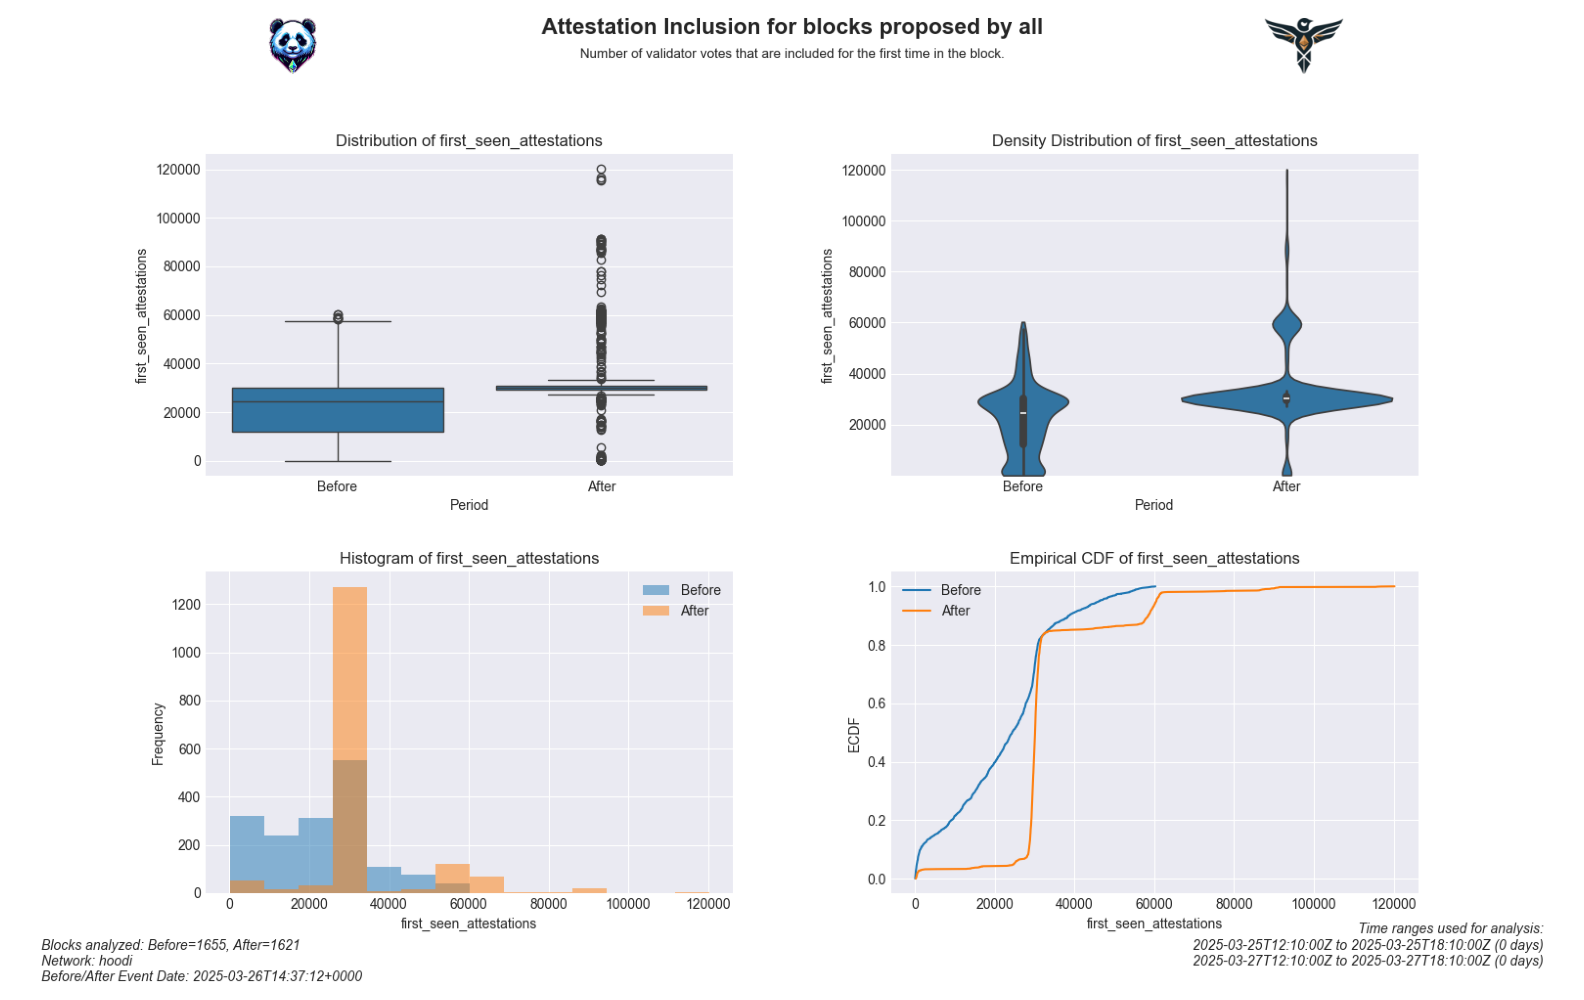

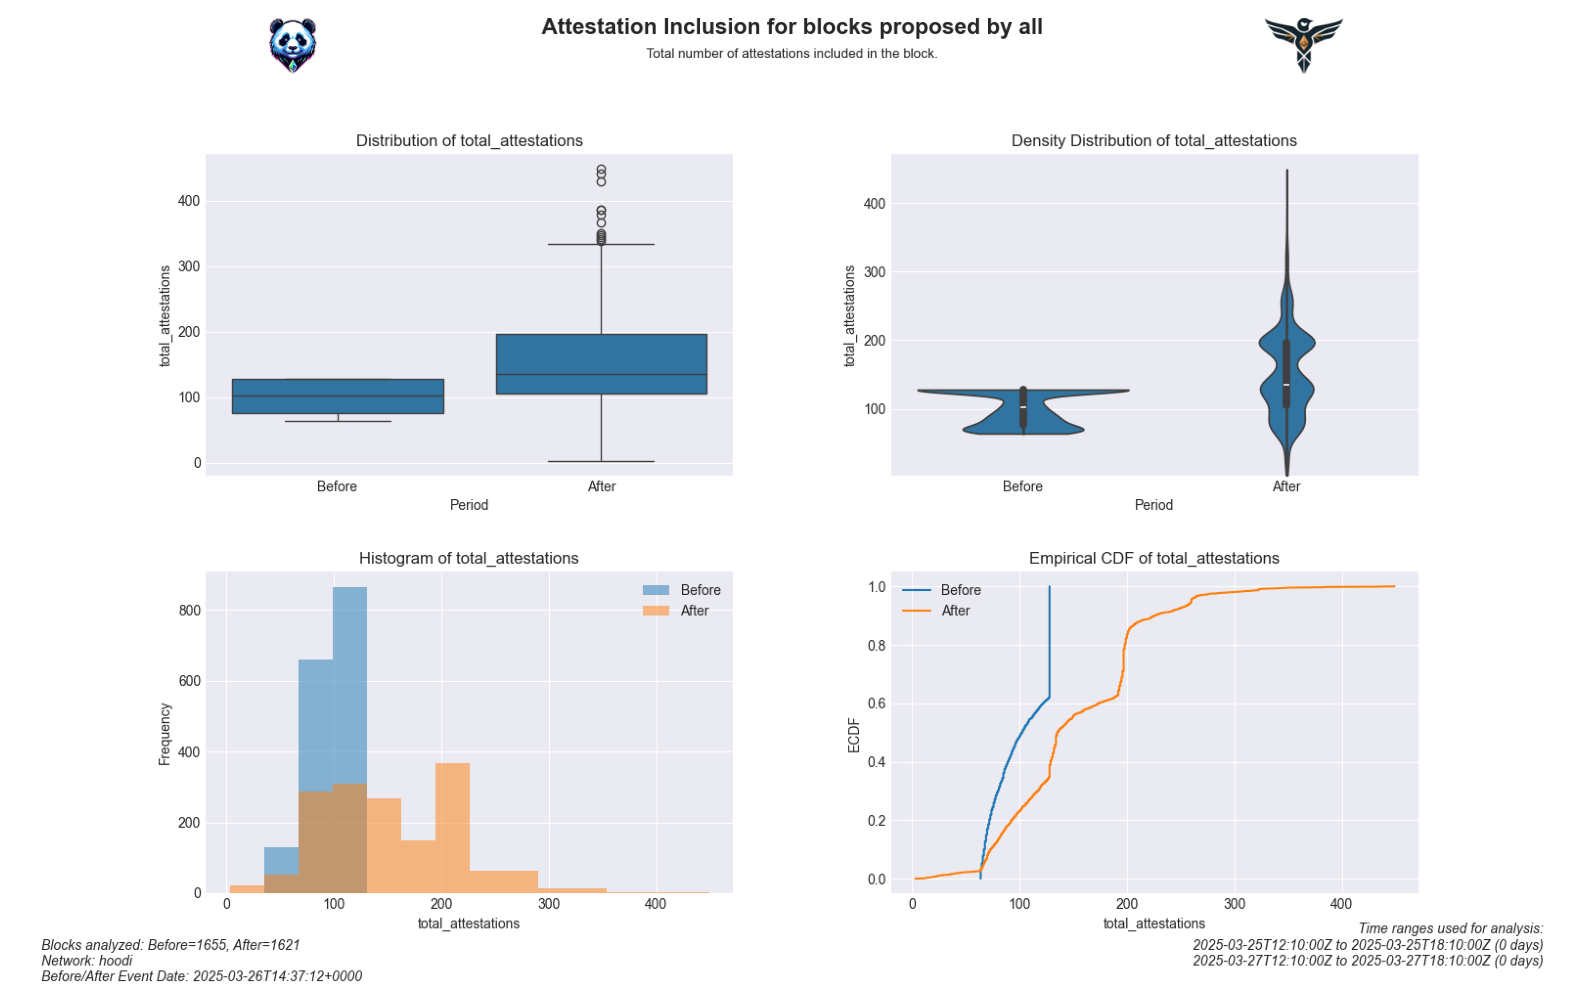

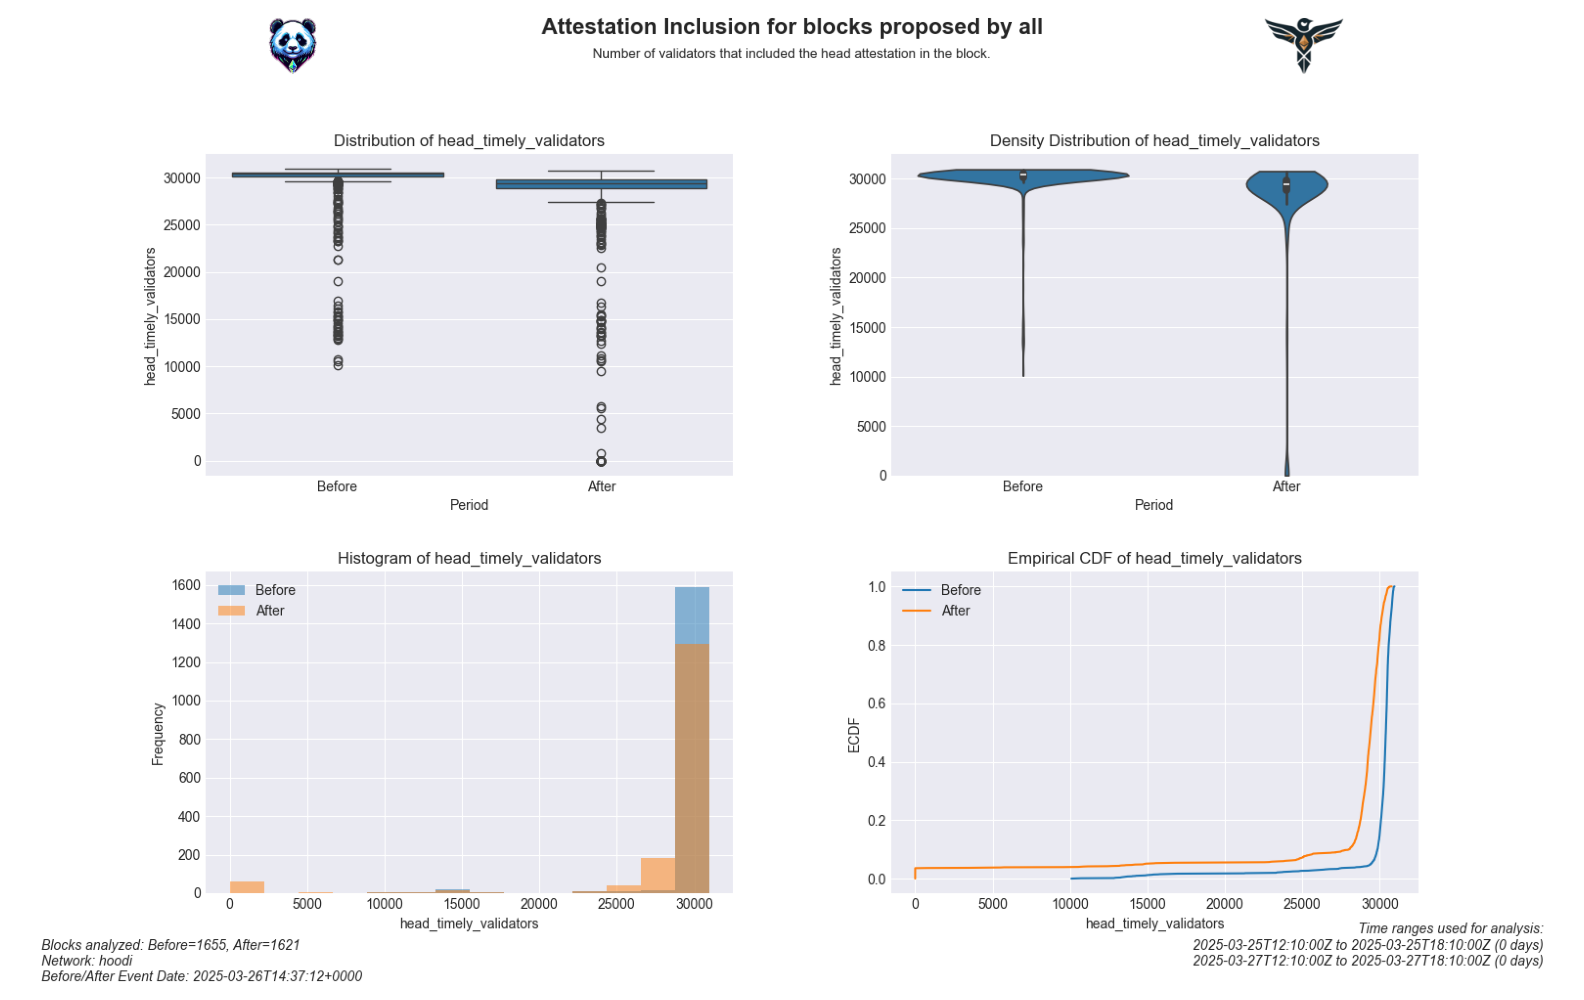

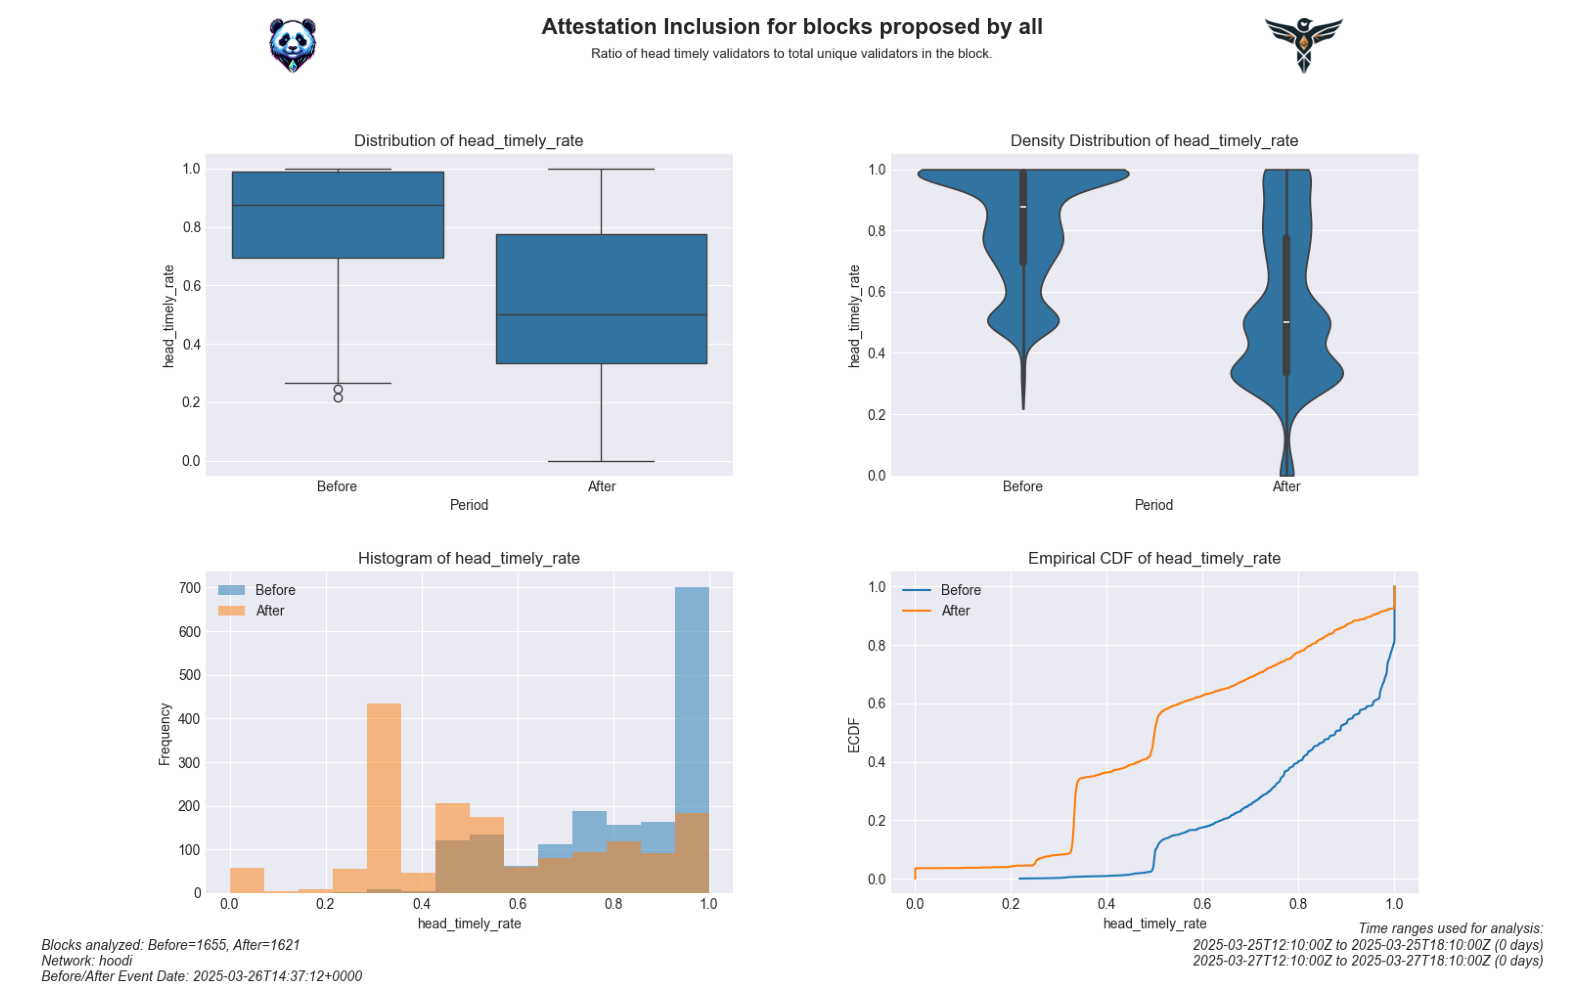

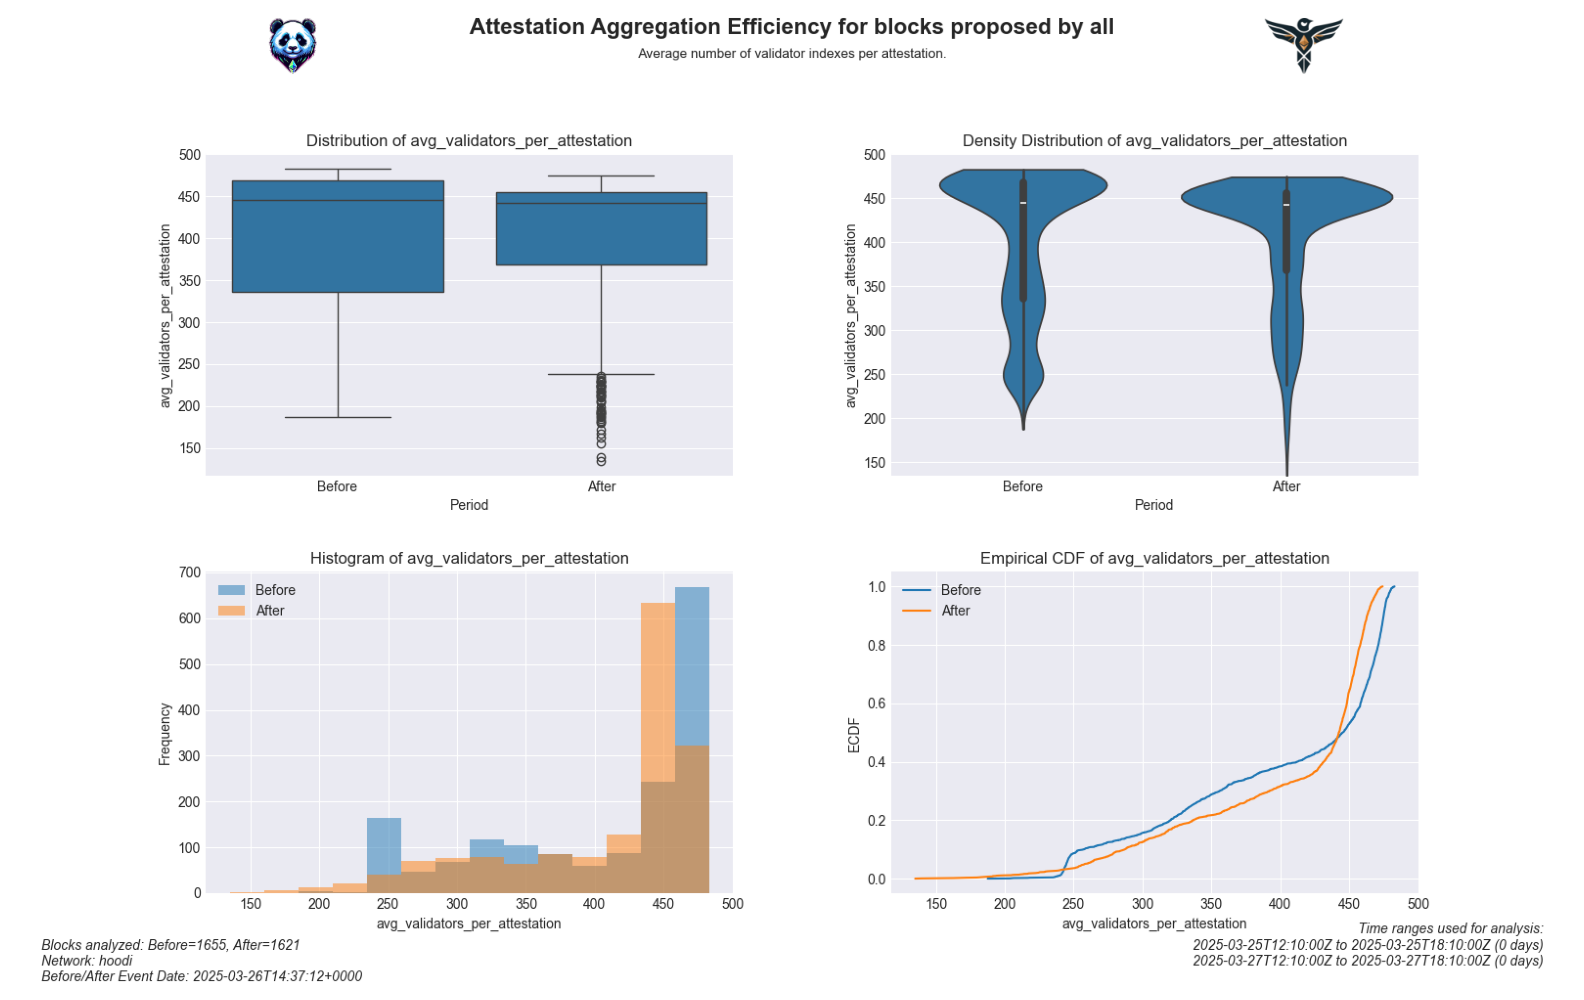

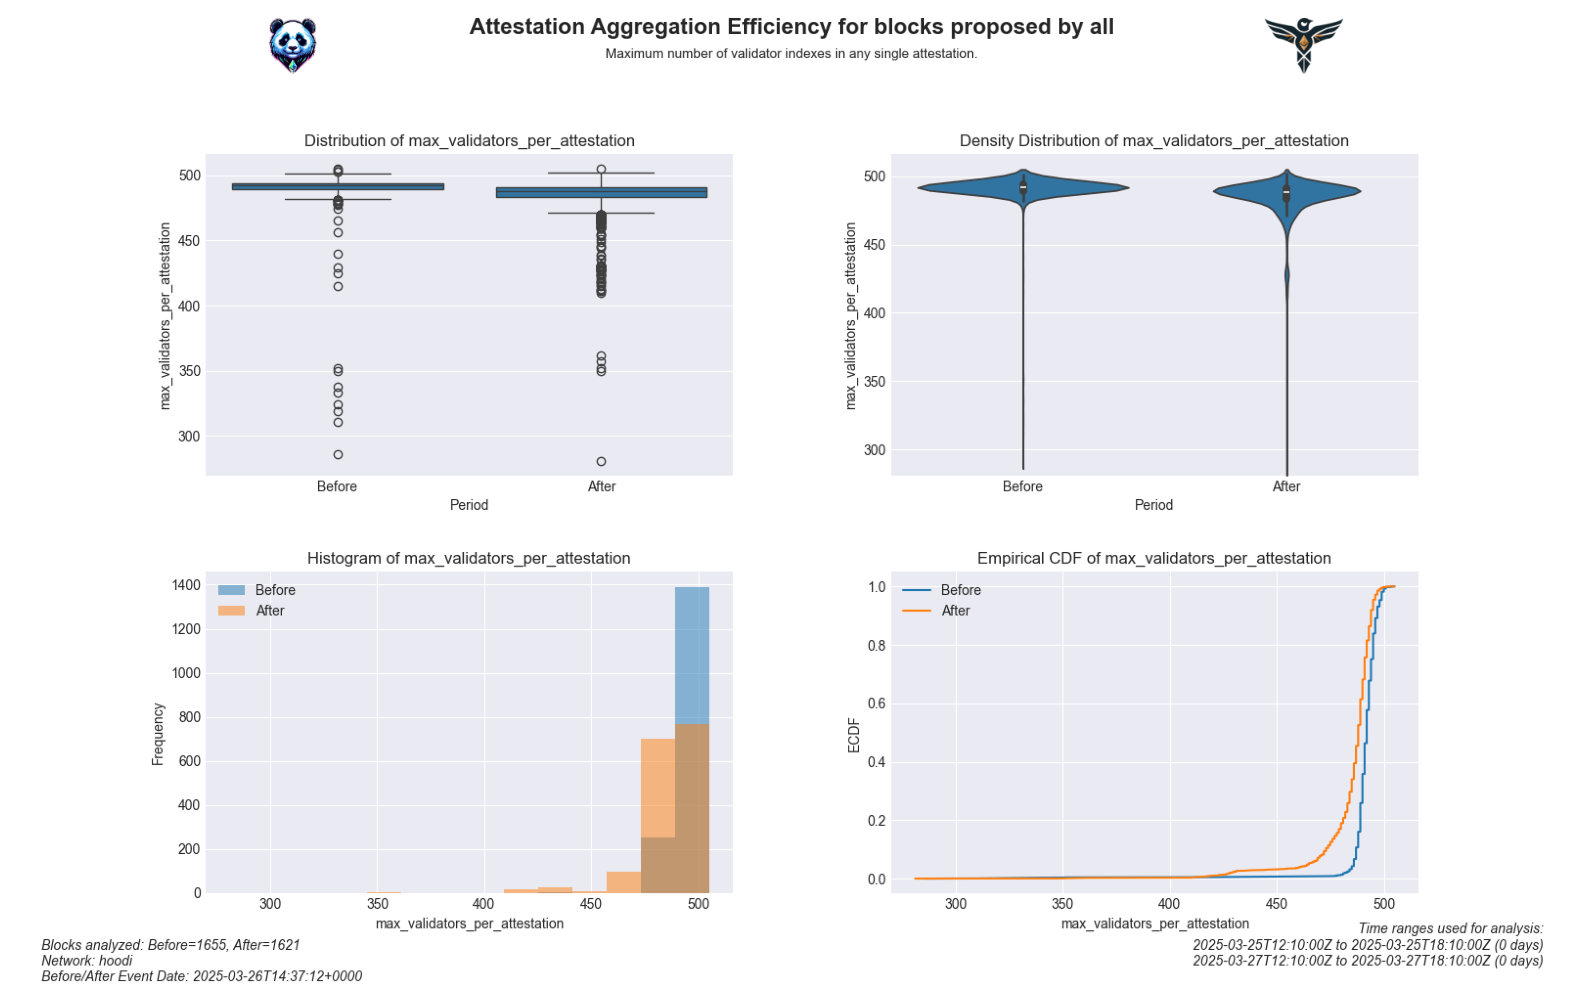

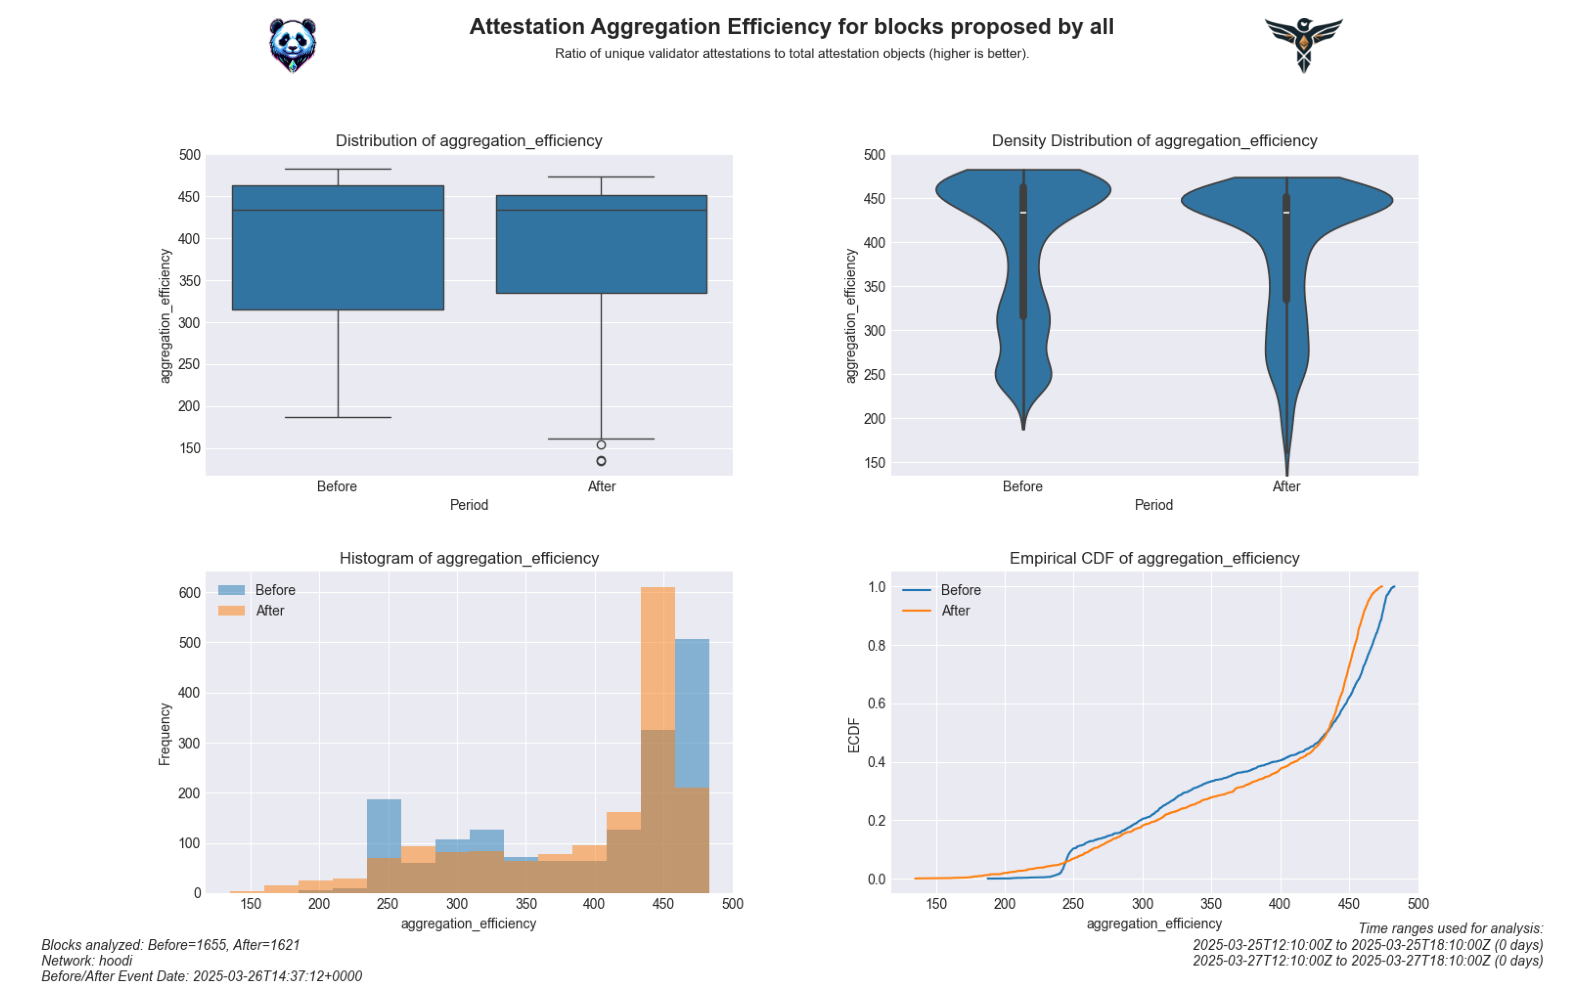

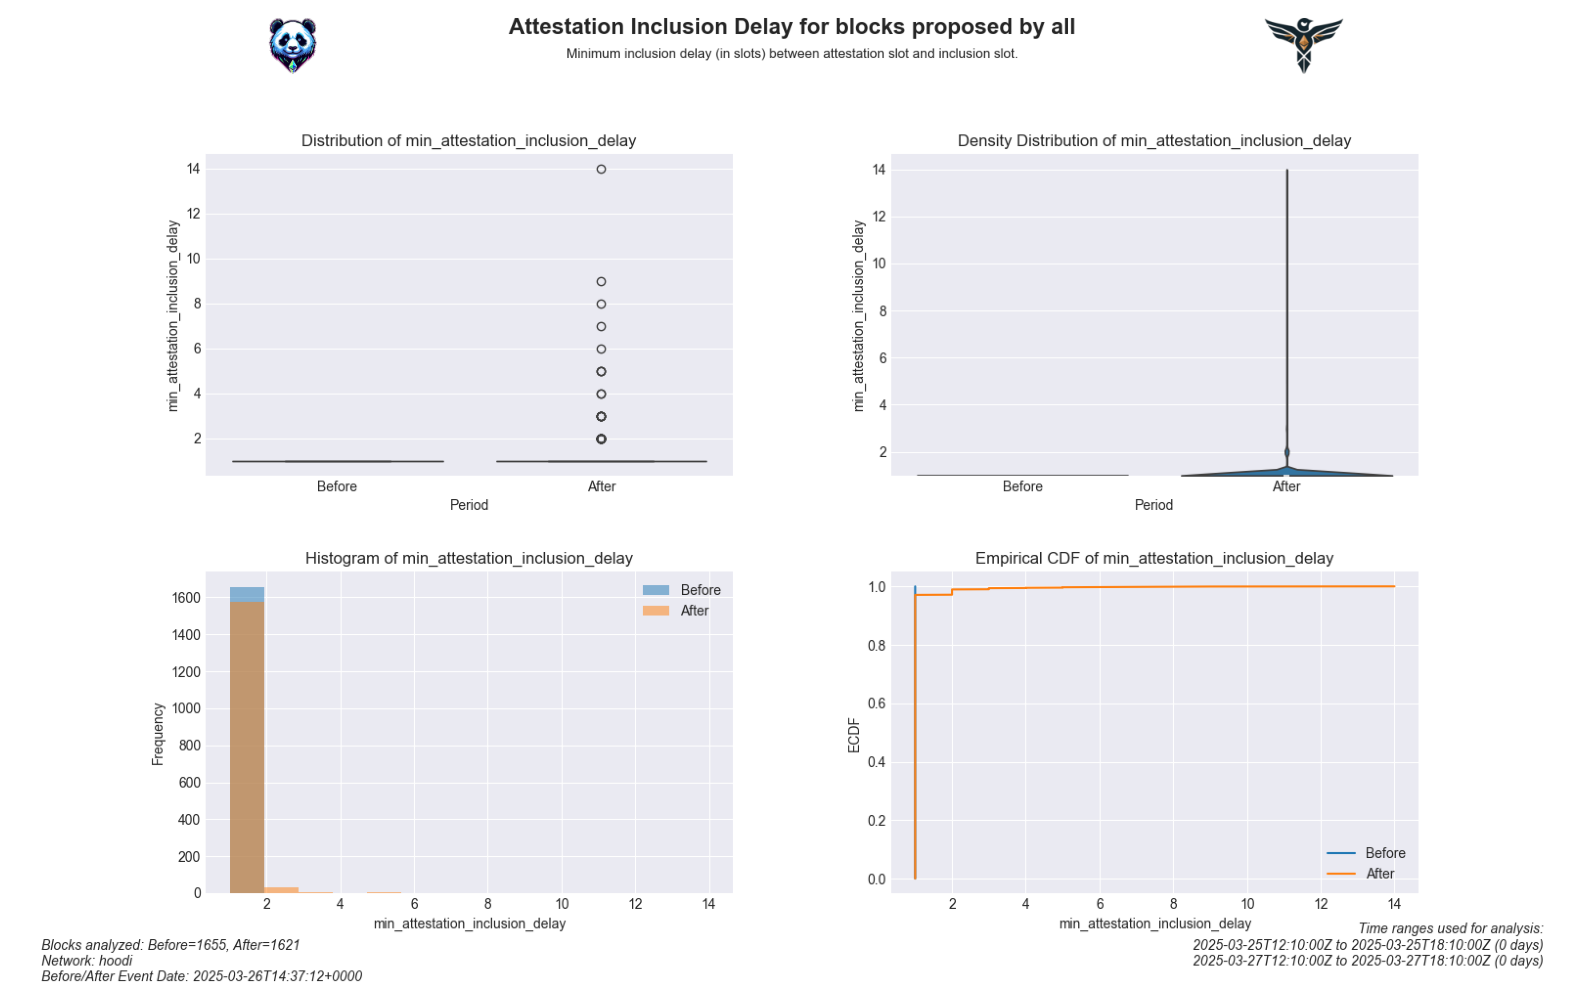

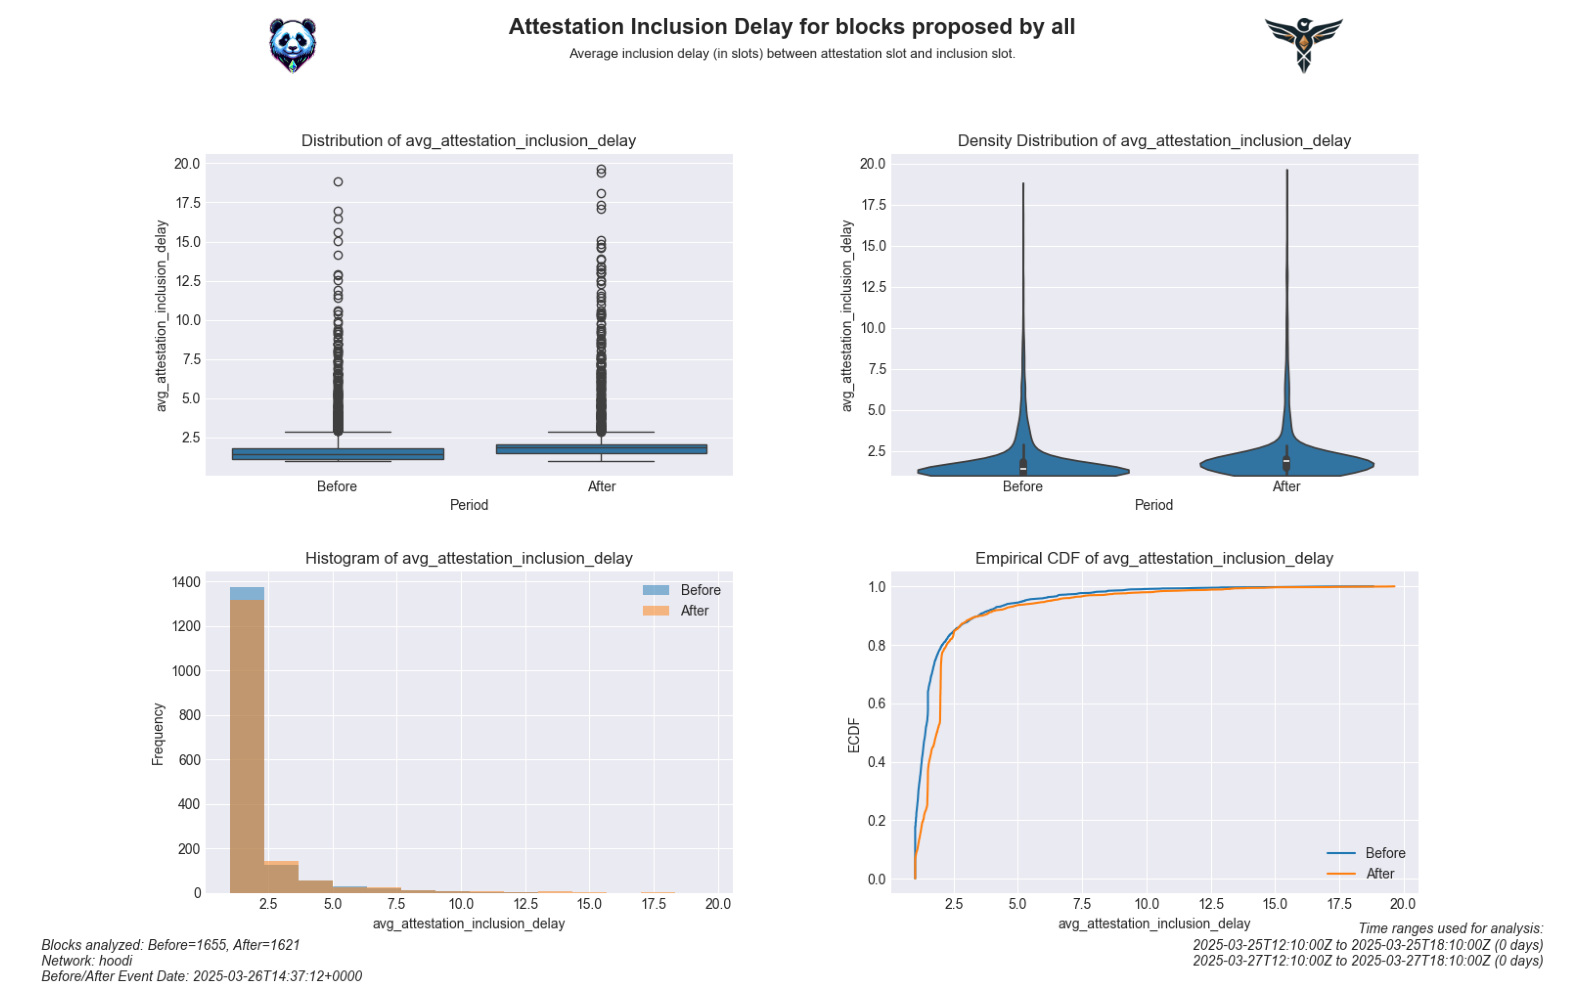

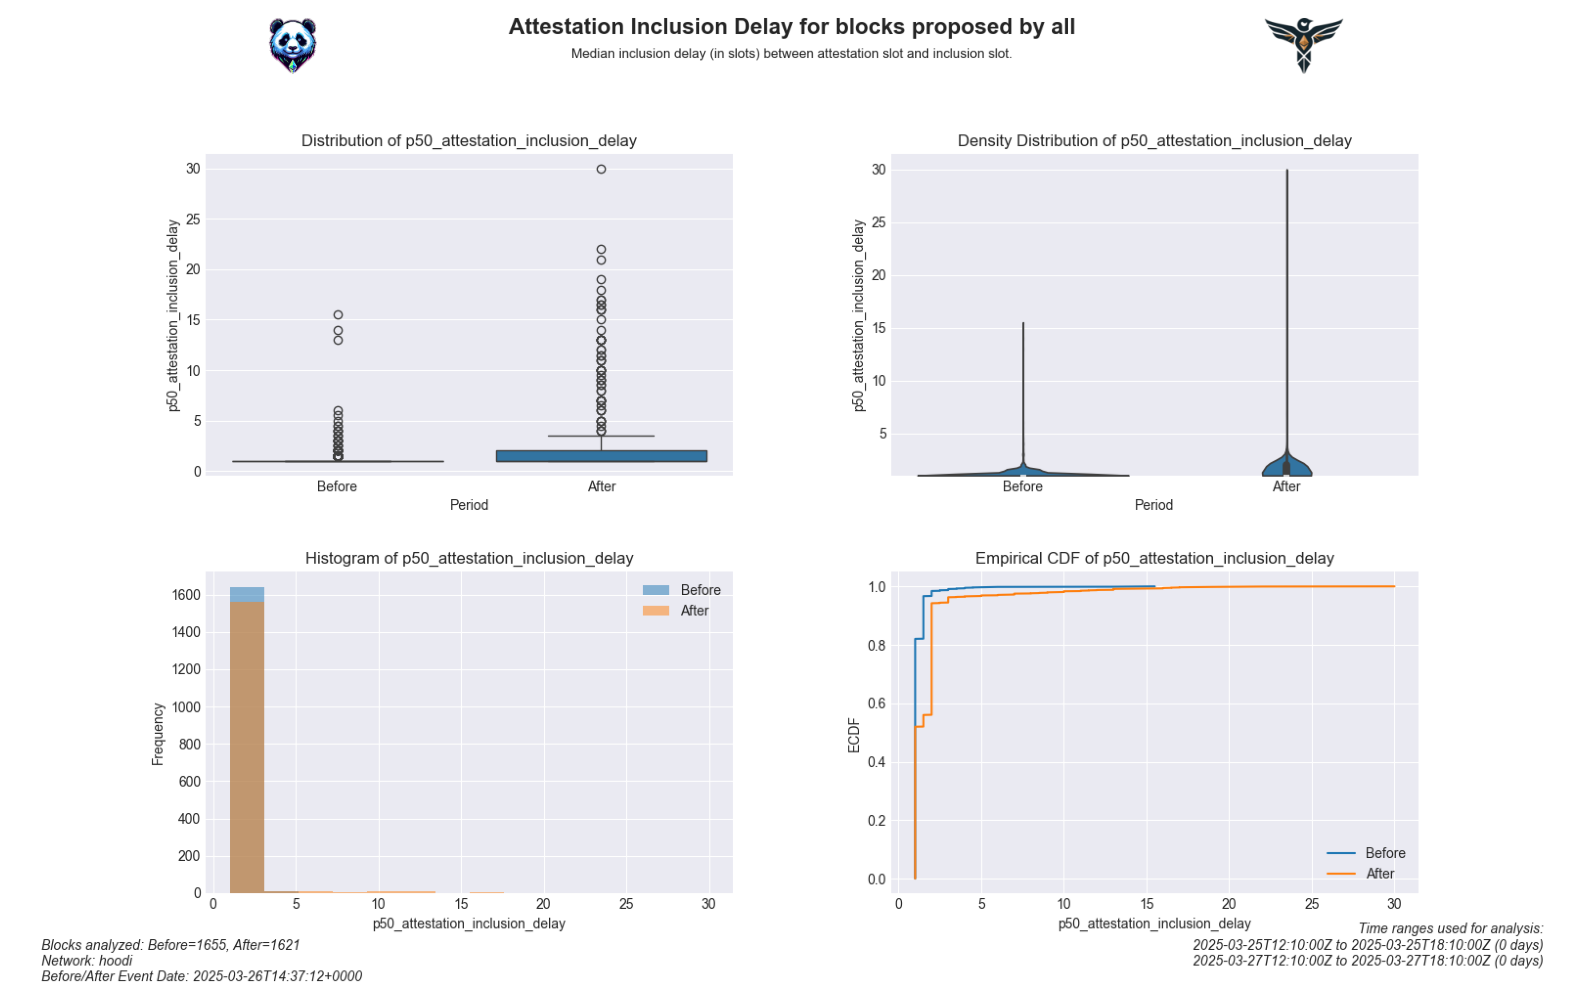

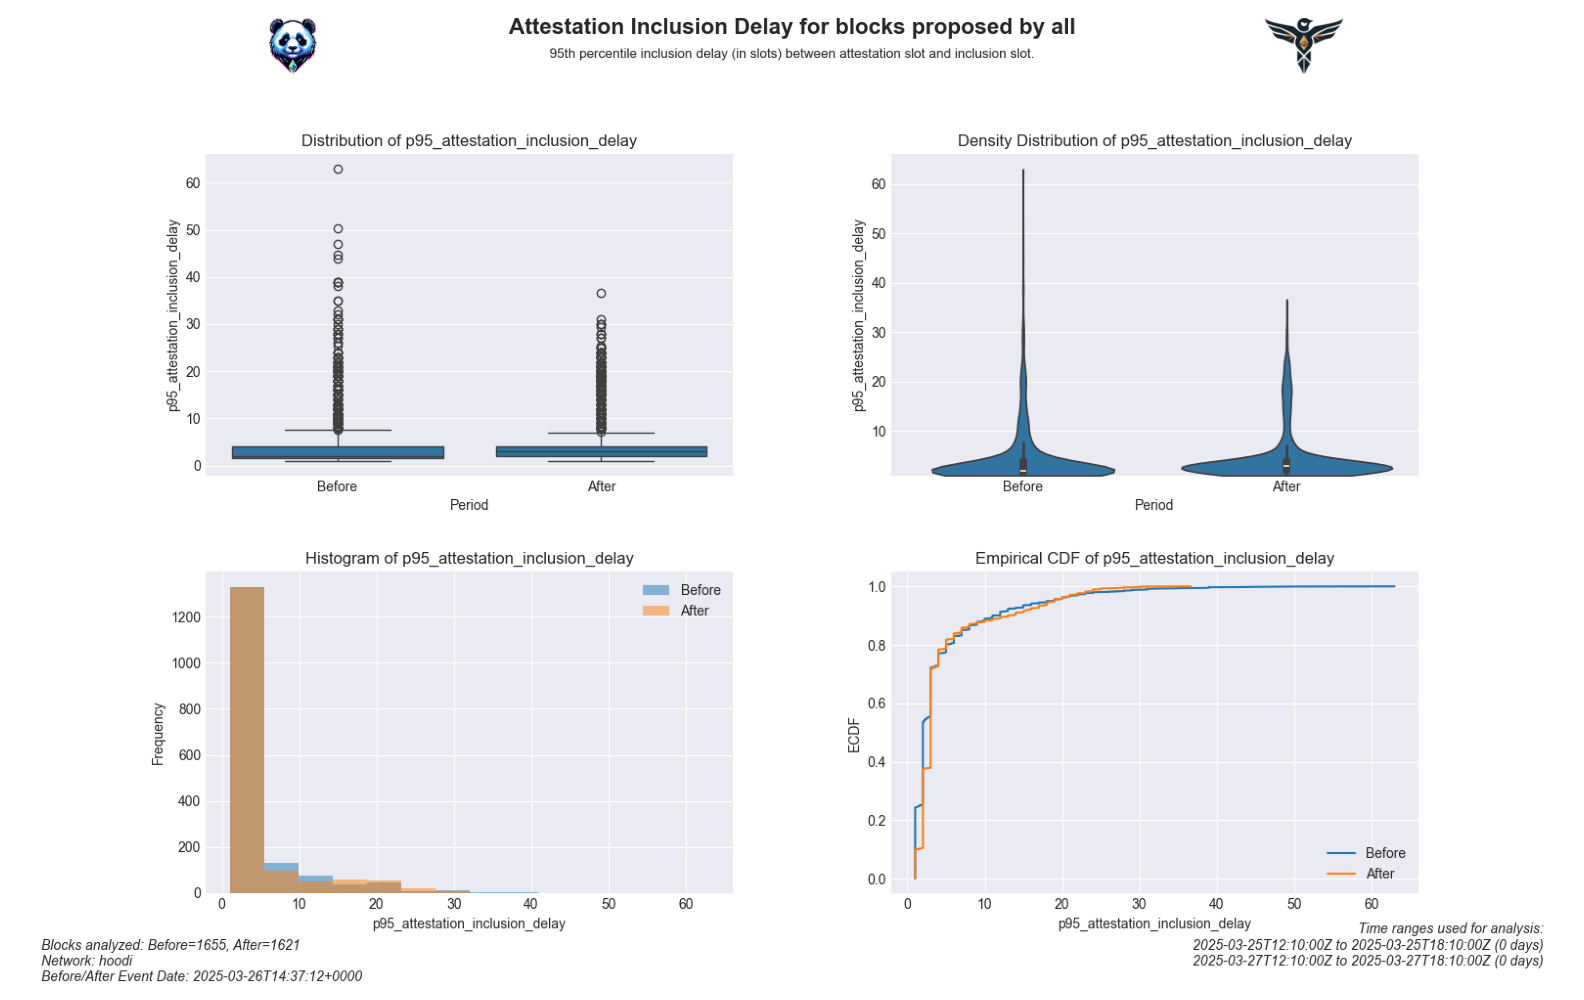

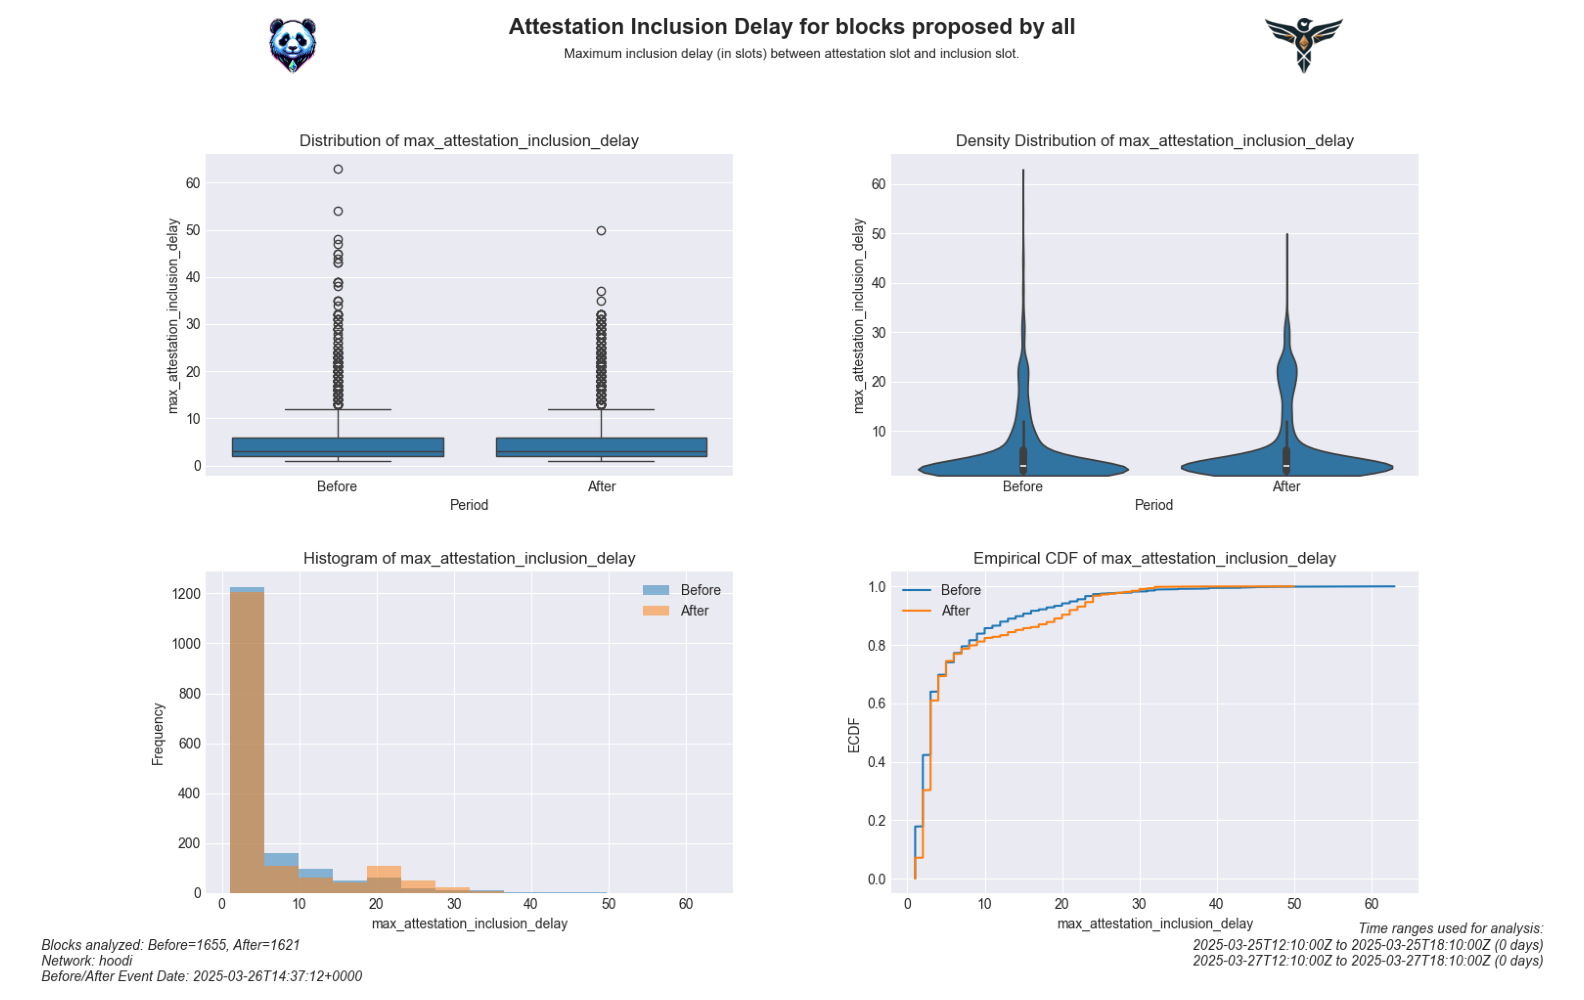

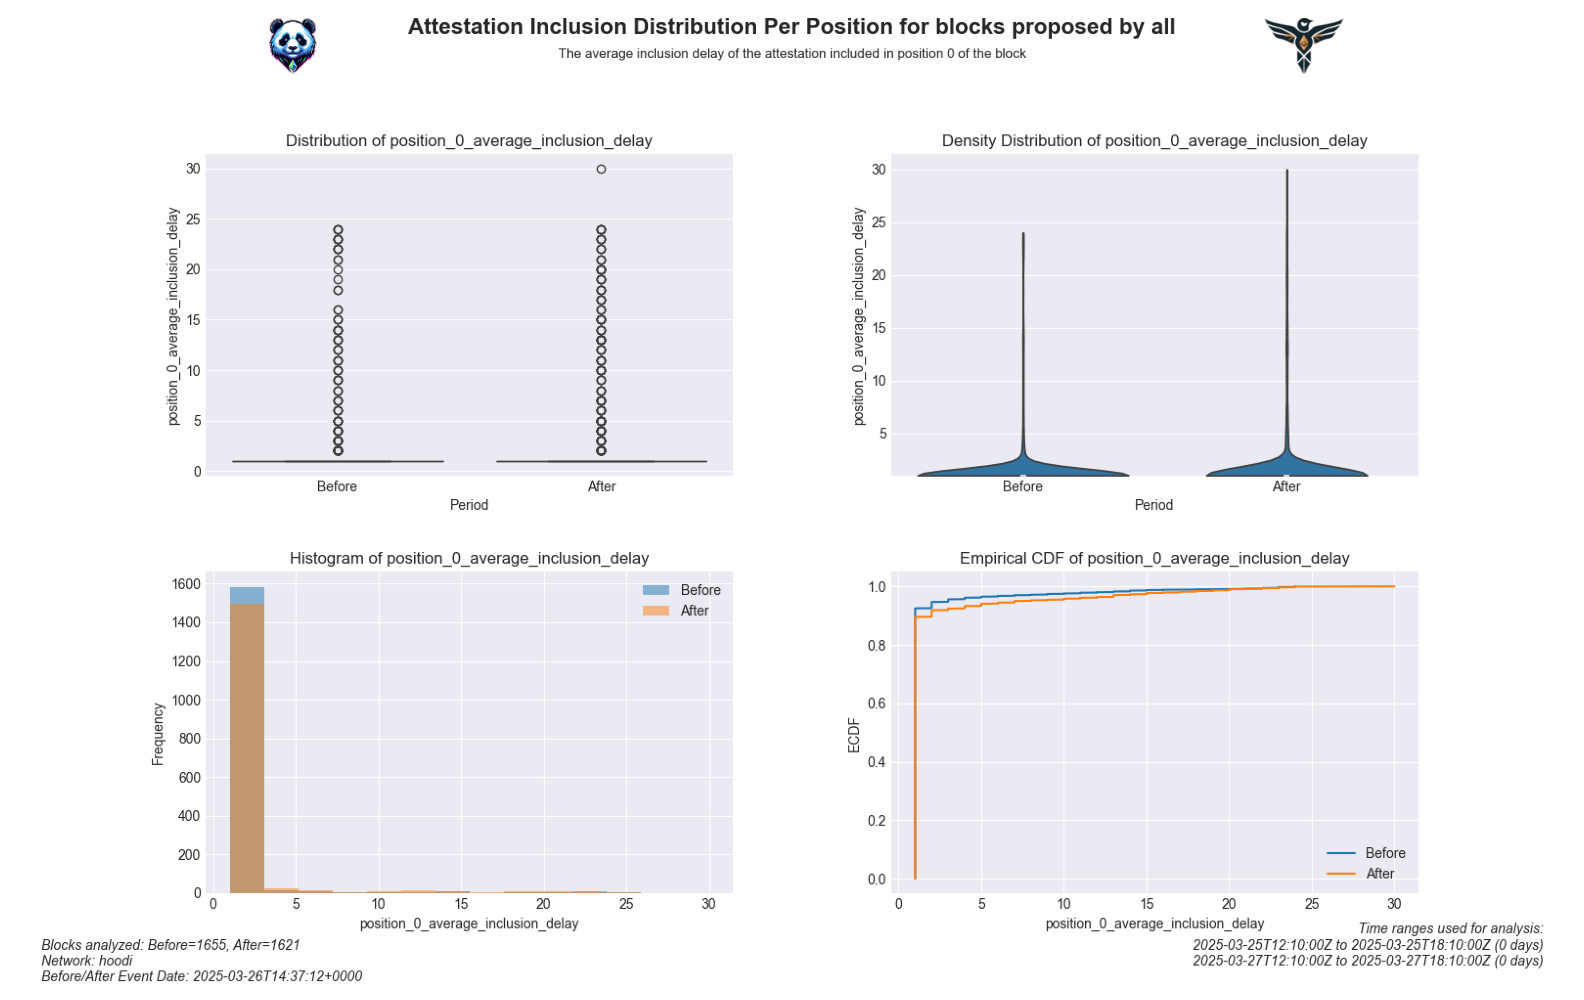

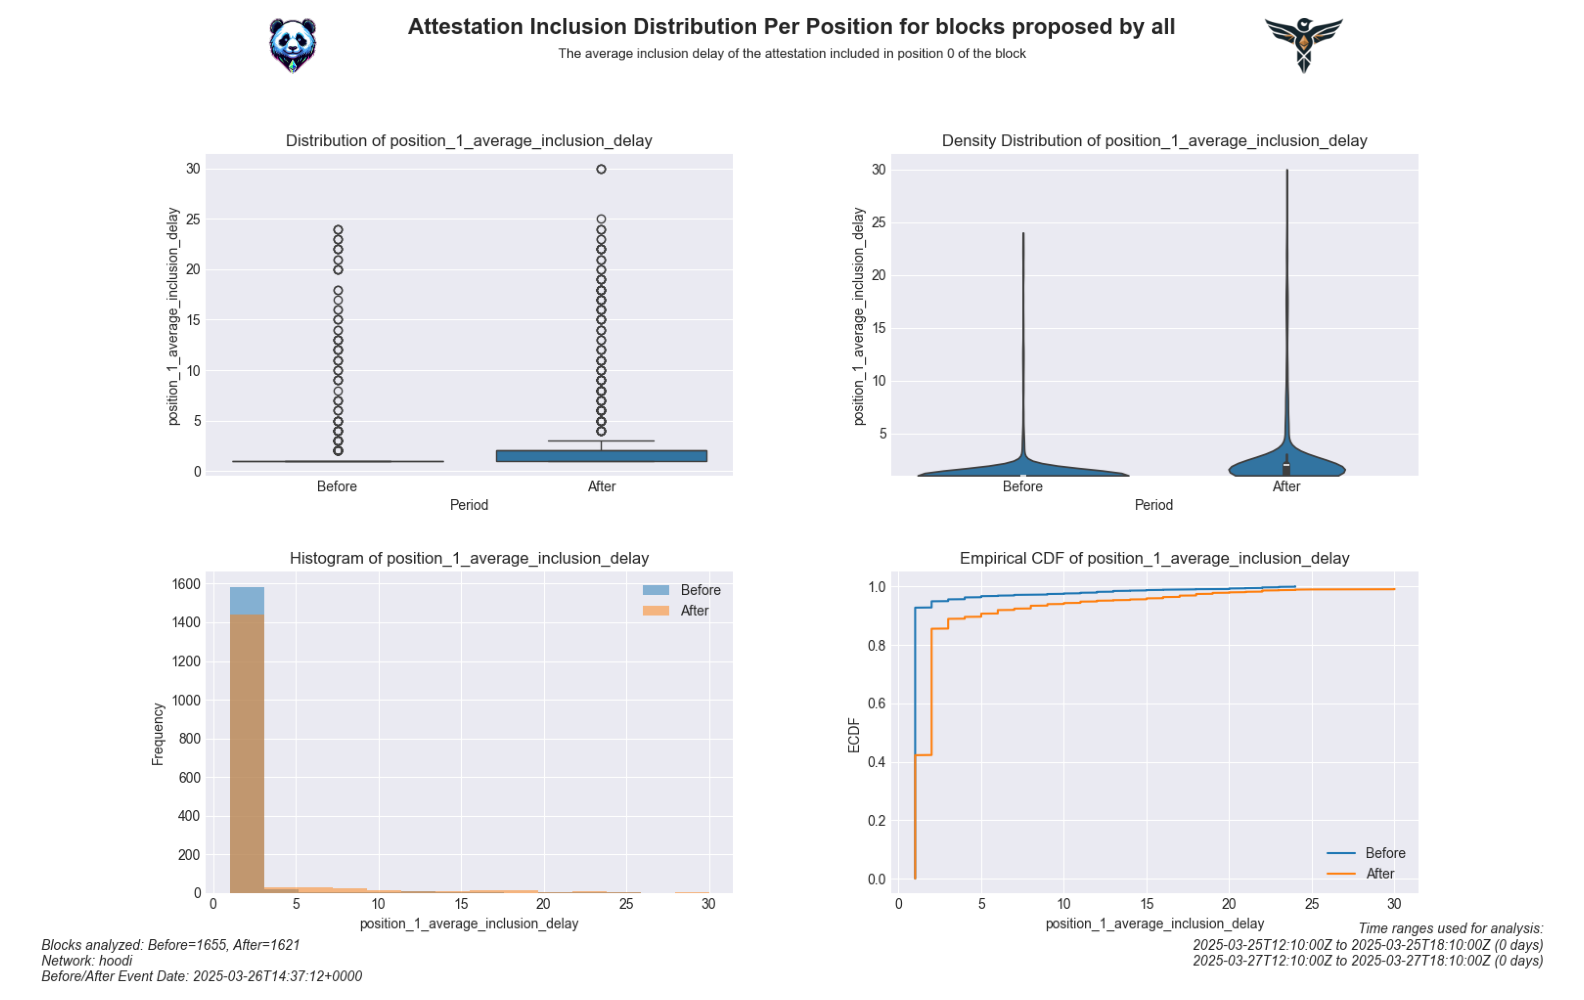

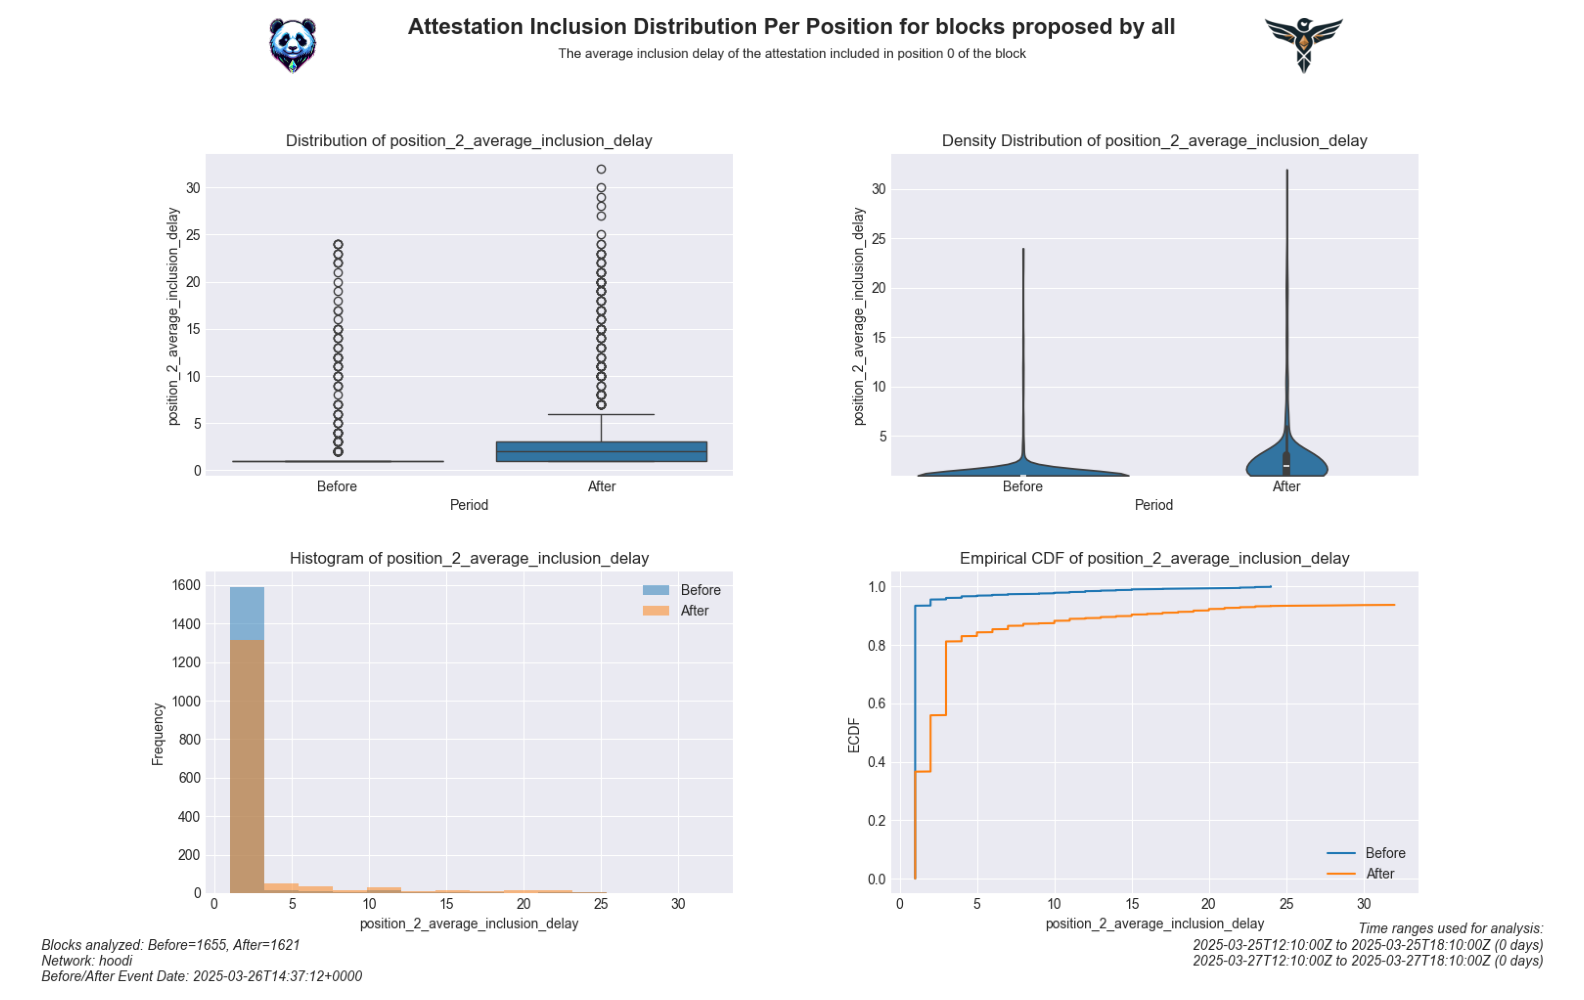

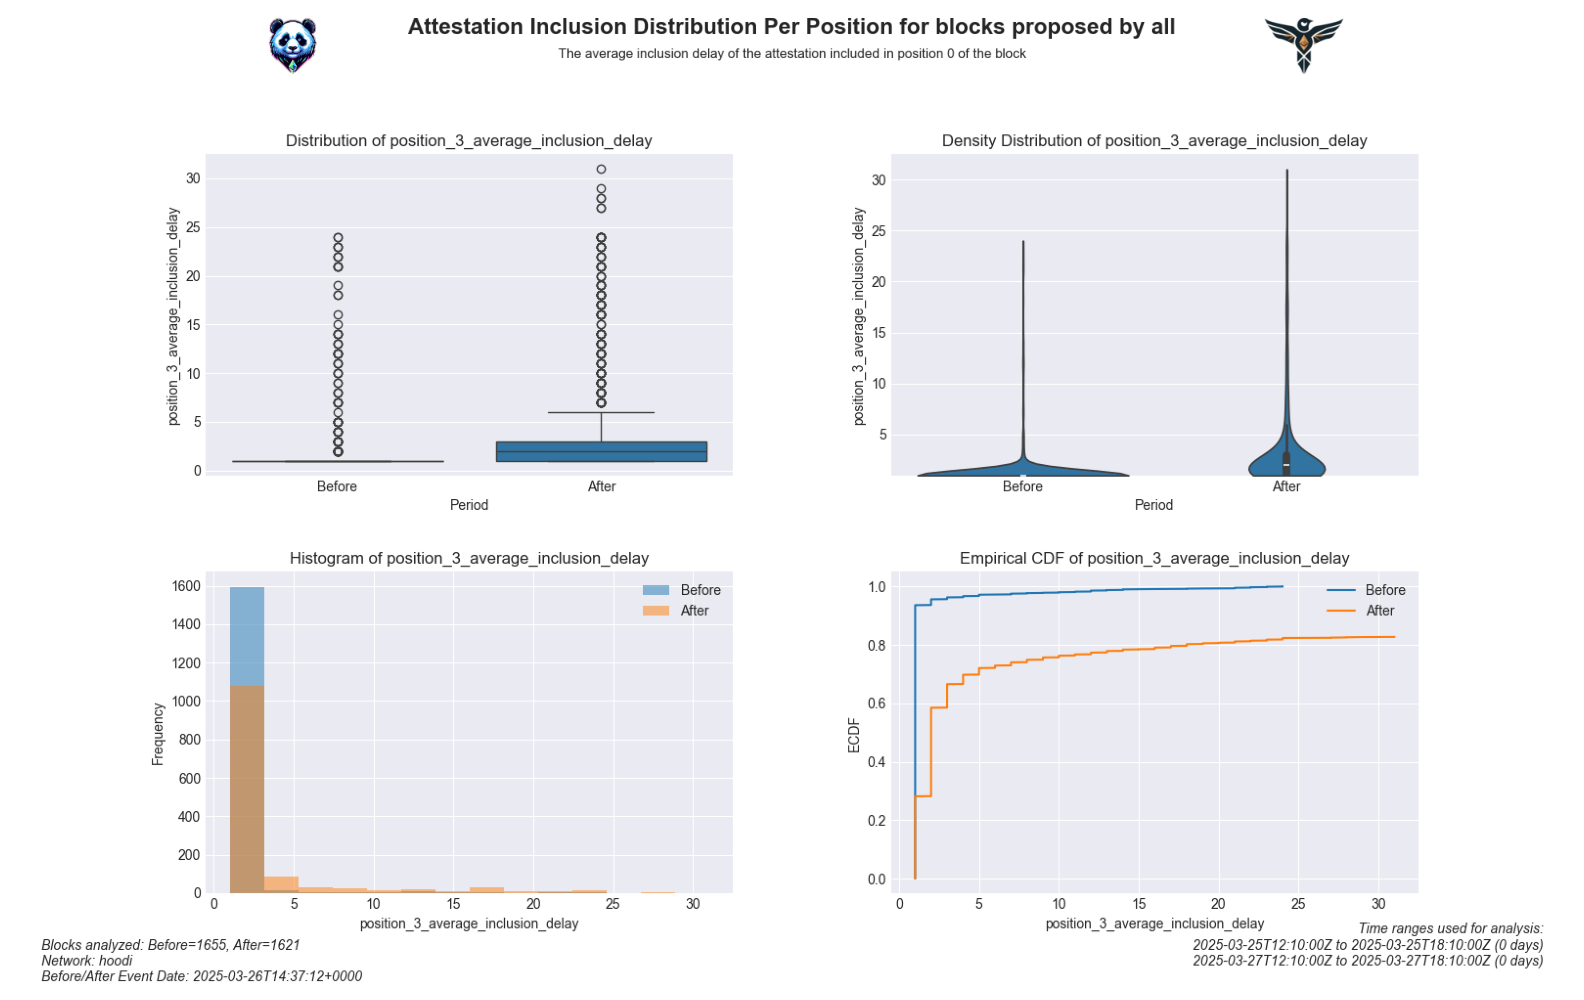

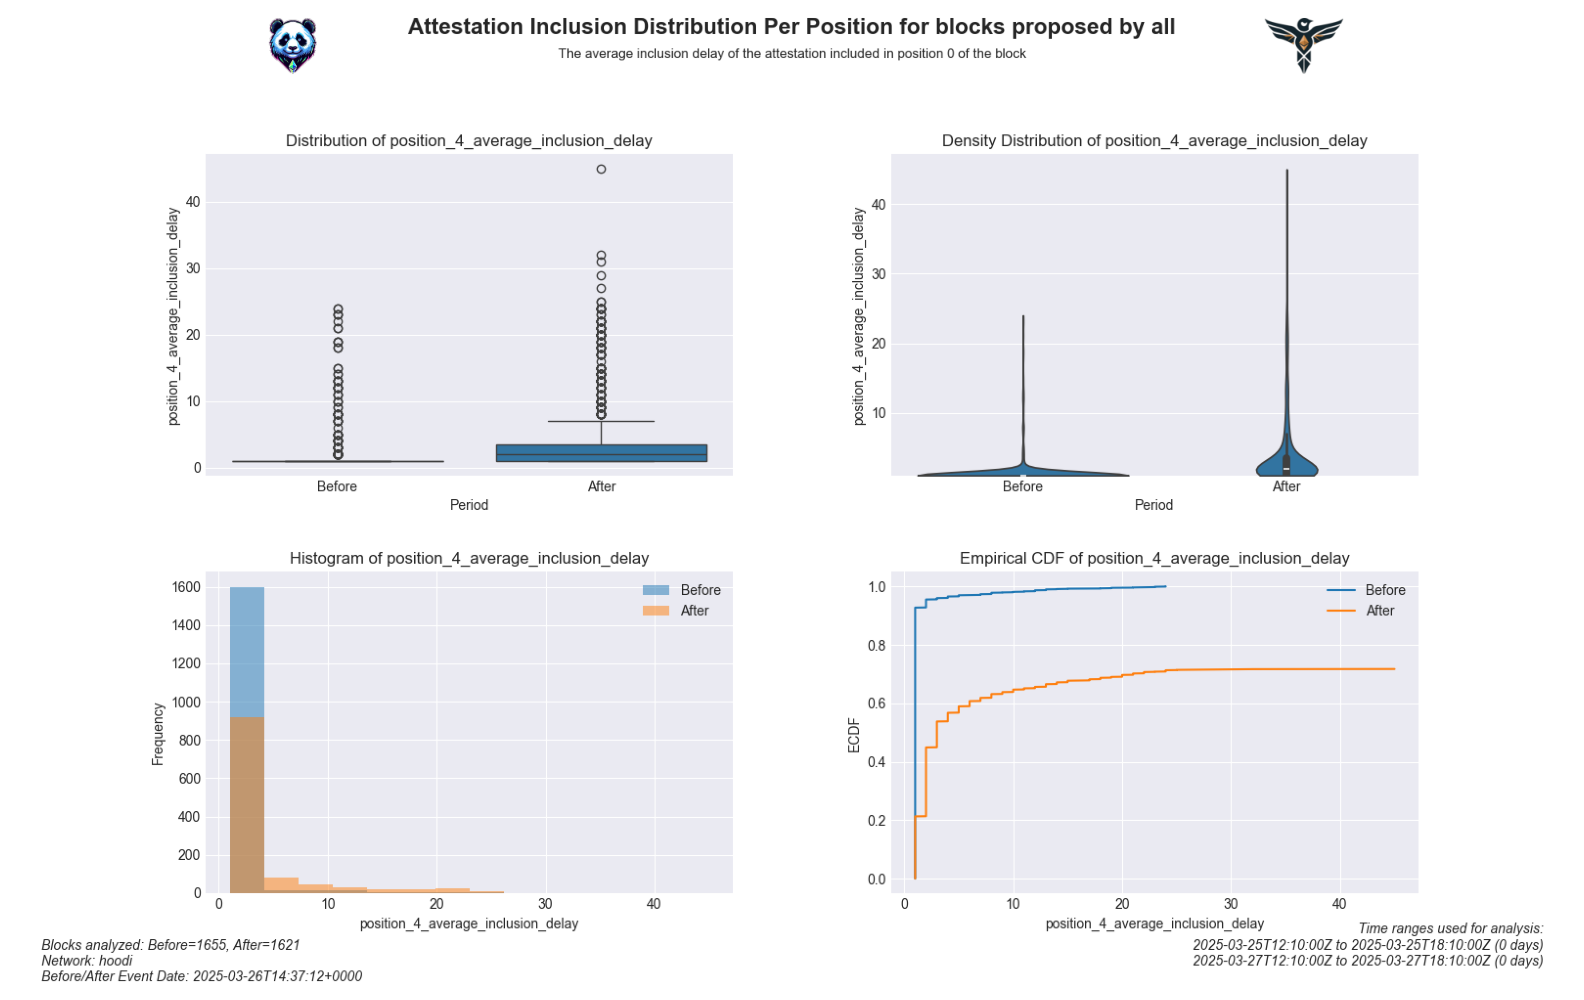

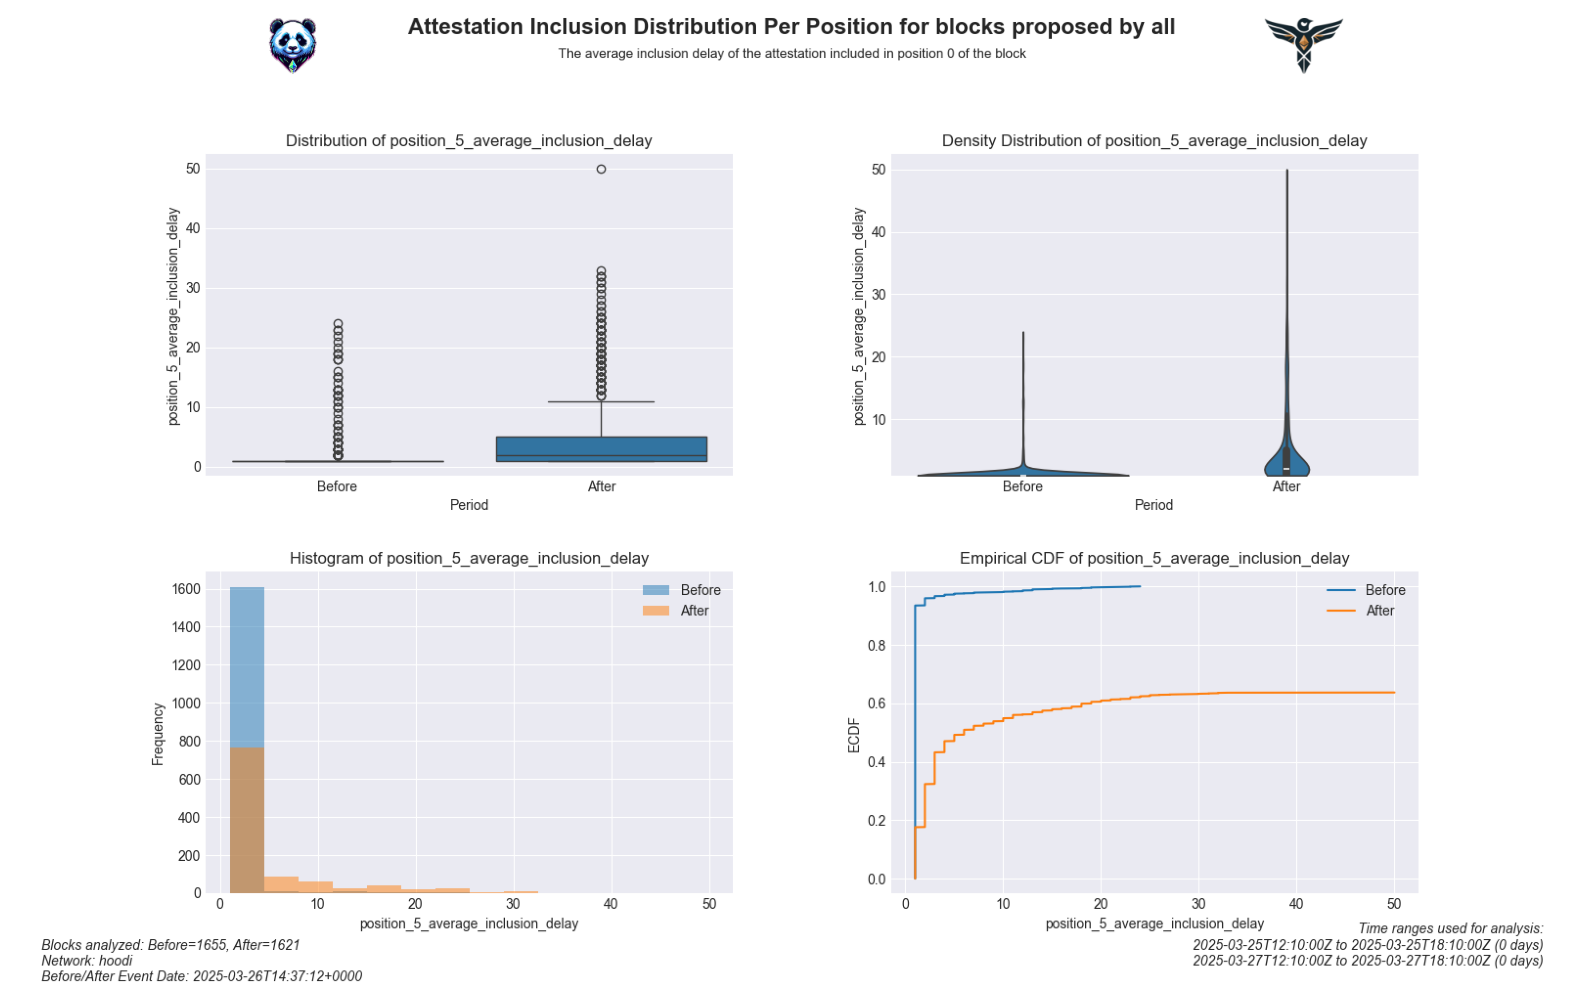

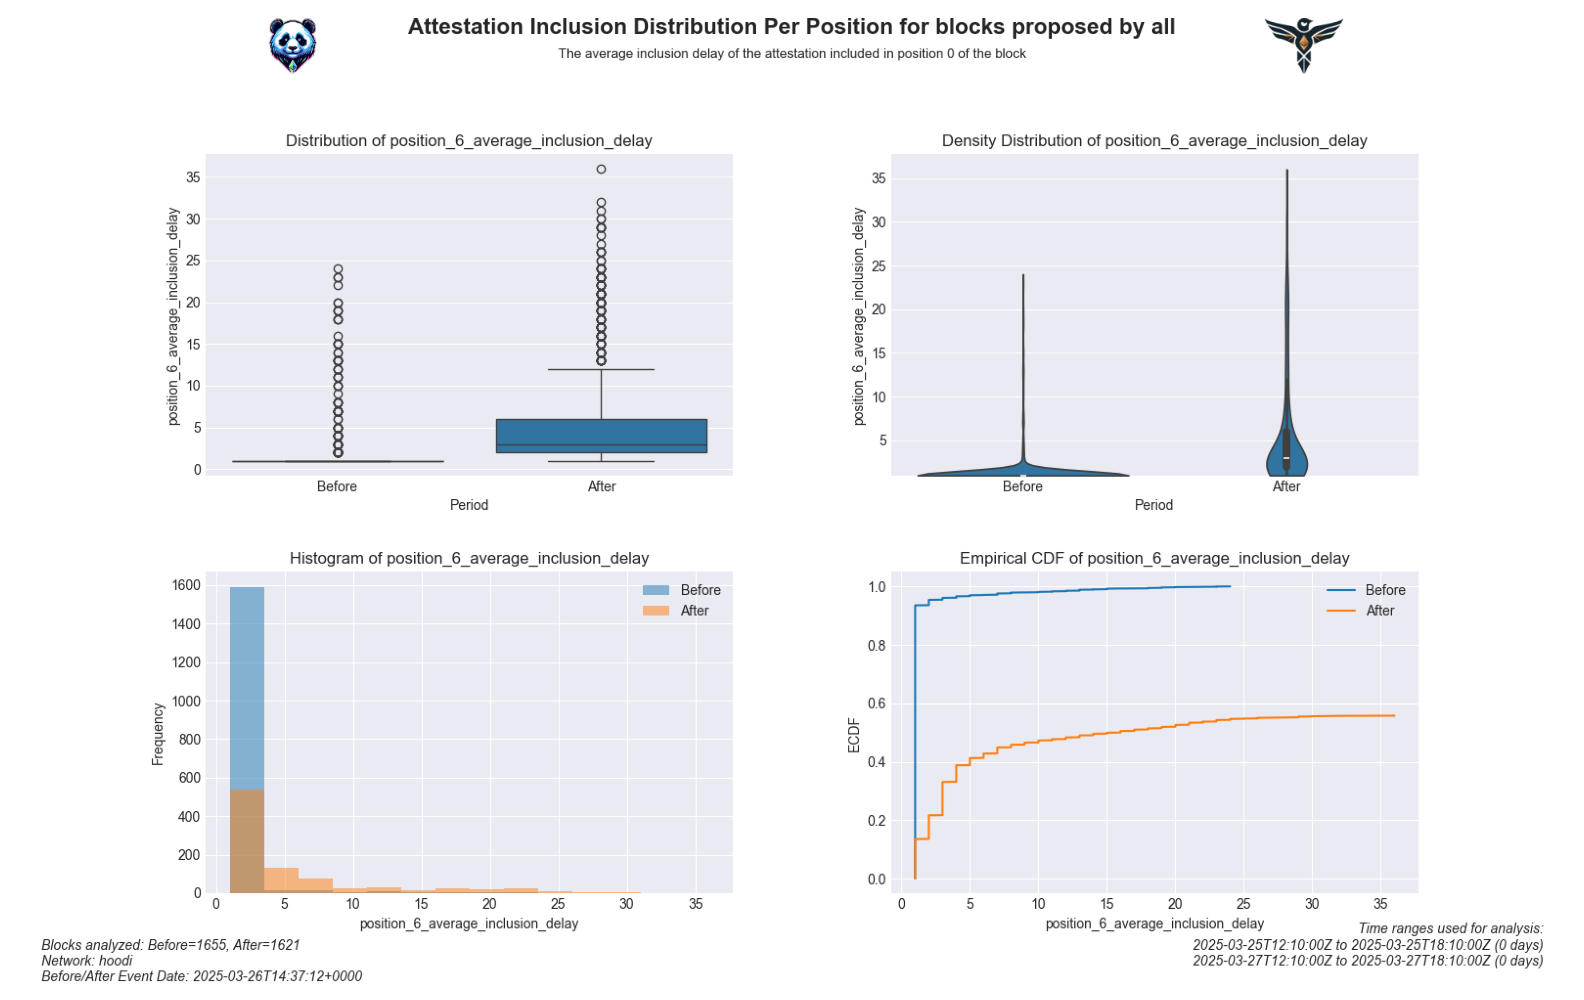

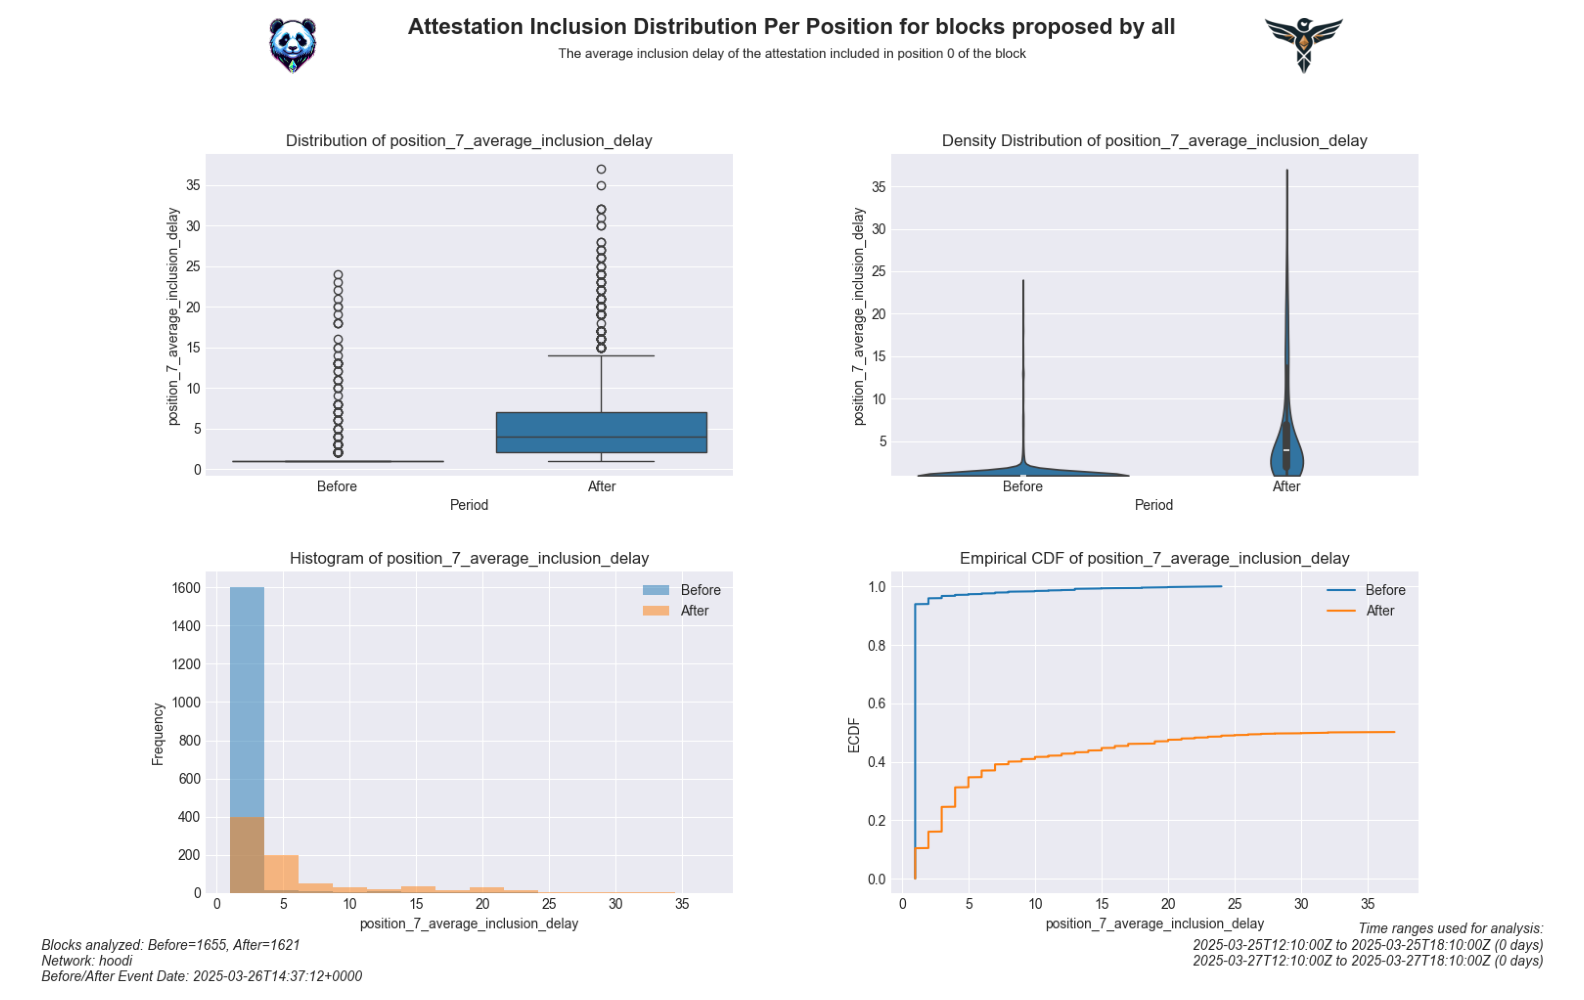

In [18]:
def plot_performance_before_after_by_entity(entity_name, metric='aggregation_efficiency', data=slot_metrics_df):
    """
    Creates a before/after comparison plot of attestation metrics for a specific entity.
    
    Args:
        entity_name (str): The name of the entity to filter by
        metric (str): The metric to use for comparison (e.g., 'aggregation_efficiency', 'unique_validator_indexes')
        data (DataFrame): The dataframe containing attestation metrics
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    import seaborn as sns
    import matplotlib.dates as mdates
    from matplotlib.ticker import FuncFormatter
    import textwrap

    plt.style.use('seaborn-v0_8-darkgrid')

    # Copy the data to avoid modifying the original data
    data_copy = data.copy()
    
    # Prepare data
    if entity_name == "all":
        valid_data = data_copy
    else:
        # Filter data for blocks proposed by the specified entity
        valid_data = data_copy[data_copy['entity'] == entity_name].copy()
    
    if len(valid_data) == 0:
        print(f"No blocks found for entity: {entity_name}")
        return None
    
    # Ensure the metric exists in the data
    if metric not in valid_data.columns:
        print(f"Metric '{metric}' not found in data. Available metrics: {', '.join(valid_data.columns)}")
        return None
    
    # Convert datetime for plotting
    valid_data['timestamp'] = pd.to_datetime(valid_data['block_slot_start_date_time'])
    
    # Convert event_date to naive datetime if it's timezone-aware
    event_date_naive = pd.Timestamp(event_date).tz_localize(None) if hasattr(event_date, 'tzinfo') and event_date.tzinfo is not None else event_date
    
    # Create before/after groups
    valid_data['period'] = np.where(valid_data['timestamp'] < event_date_naive, 'Before', 'After')
    
    # Create a figure with 2x2 layout with 16:9 aspect ratio
    fig = plt.figure(figsize=(16, 9))
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
    
    # Create the four plots
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])
    
    # Create boxplot
    sns.boxplot(x='period', y=metric, data=valid_data, ax=ax1)
    ax1.set_title(f'Distribution of {metric}')
    ax1.set_xlabel('Period')
    ax1.set_ylabel(metric)
    
    # Create violinplot with more accurate boundaries
    # Find the actual min value to set proper y-axis limits
    min_value = valid_data[metric].min()
    # Ensure the y-axis starts at the actual minimum (or 0 if all values are positive)
    y_min = max(0, min_value) if min_value > 0 else min_value
    
    sns.violinplot(x='period', y=metric, data=valid_data, ax=ax2, cut=0)  # cut=0 prevents extending beyond observed data
    ax2.set_title(f'Density Distribution of {metric}')
    ax2.set_xlabel('Period')
    ax2.set_ylabel(metric)
    ax2.set_ylim(bottom=y_min)  # Set the bottom limit to actual minimum or 0
    
    # Create histogram
    bins = np.linspace(valid_data[metric].min(), valid_data[metric].max(), 15)
    ax3.hist(valid_data[valid_data['period'] == 'Before'][metric], bins=bins, alpha=0.5, label='Before')
    ax3.hist(valid_data[valid_data['period'] == 'After'][metric], bins=bins, alpha=0.5, label='After')
    ax3.set_title(f'Histogram of {metric}')
    ax3.set_xlabel(metric)
    ax3.set_ylabel('Frequency')
    ax3.legend()
    
    # Create ECDF plot
    for period in ['Before', 'After']:
        period_data = valid_data[valid_data['period'] == period][metric].sort_values()
        ecdf = np.arange(1, len(period_data) + 1) / len(period_data)
        ax4.plot(period_data, ecdf, label=period)
    ax4.set_title(f'Empirical CDF of {metric}')
    ax4.set_xlabel(metric)
    ax4.set_ylabel('ECDF')
    ax4.legend()
    
    # Find the metric description
    metric_description = None
    category_description = None
    metric_category = None
    
    for category, data in metrics.items():
        if metric in data["metrics"]:
            metric_category = category
            category_description = data['description']
            metric_description = data['metrics'][metric]
            break
    
    # Add date range information
    data_ranges_text = "Time ranges used for analysis:\n"
    for start_date, end_date in config.time_ranges:
        days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days
        data_ranges_text += f"{start_date} to {end_date} ({days} days)\n"
    fig.text(0.98, 0.01, data_ranges_text, fontsize=10, style='italic', ha='right')

    # Add the number of blocks analyzed before and after and network name
    before_count = len(valid_data[valid_data['period'] == 'Before'])
    after_count = len(valid_data[valid_data['period'] == 'After'])
    fig.text(0.02, 0.01, f'Blocks analyzed: Before={before_count}, After={after_count}\nNetwork: {config.network}\nBefore/After Event Date: {event_date.strftime("%Y-%m-%dT%H:%M:%S%z")}', fontsize=10, style='italic')

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    add_branding(fig, title=f"{metric_category if metric_category else 'Attestation Metrics'} for blocks proposed by {entity_name}", 
                subtitle=f"{metric_description if metric_description else metric}")
    return plt

# Loop through all metrics defined in the metrics dictionary for each entity
entities = [
    "all",
    # "teku",
    # "lighthouse",
    # "prysm"
    ]

for entity in entities:
    for category, category_data in metrics.items():
        if isinstance(category_data, dict) and "metrics" in category_data:
            for metric in category_data["metrics"]:
                print(f"Plotting {metric} for {entity}")
                if metric in slot_metrics_df.columns:
                    plot_performance_before_after_by_entity(entity, metric=metric)

<module 'matplotlib.pyplot' from '/Users/samcm/.asdf/installs/python/3.11.4/lib/python3.11/site-packages/matplotlib/pyplot.py'>

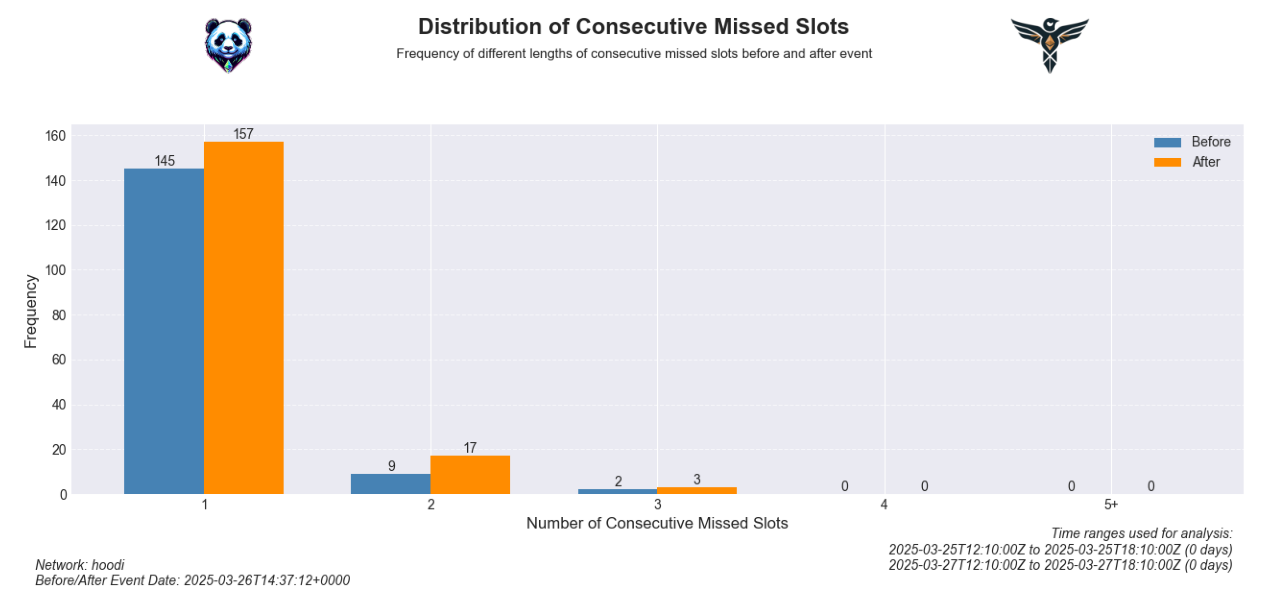

In [28]:

# Create a distribution chart of consecutive missed slots before and after the event
def plot_missed_slots_distribution():
    # Extract the consecutive missed slots metrics
    missed_slots_metrics = [col for col in slot_metrics_df.columns if col.startswith('consecutive_missed_slots_')]
    
    # Create a dataframe with the counts
    missed_slots_counts = slot_metrics_df[missed_slots_metrics].iloc[0]
    
    # Extract the numbers from the column names for x-axis labels
    x_labels = [f"{col.split('_')[-1]}" for col in missed_slots_metrics]
    x_labels = [label if label != '5' else '5+' for label in x_labels]
    
    # Split data into before and after
    slot_metrics_df['datetime'] = pd.to_datetime(slot_metrics_df['block_slot_start_date_time'])
    before_df = slot_metrics_df[slot_metrics_df['datetime'] < event_date_naive]
    after_df = slot_metrics_df[slot_metrics_df['datetime'] >= event_date_naive]
    
    # Calculate missed slots for before and after periods
    before_missed_slots = calculate_consecutive_missed_slots(all_attestations[all_attestations['block_slot_start_date_time'] < event_date_naive])
    after_missed_slots = calculate_consecutive_missed_slots(all_attestations[all_attestations['block_slot_start_date_time'] >= event_date_naive])
    
    # Create the figure
    fig, ax = plt.subplots(figsize=(13, 5))
    
    # Width of bars
    width = 0.35
    
    # X positions for bars
    x = np.arange(len(x_labels))
    
    # Plot the bar charts
    bars1 = ax.bar(x - width/2, before_missed_slots.values, width, label='Before', color='steelblue')
    bars2 = ax.bar(x + width/2, after_missed_slots.values, width, label='After', color='darkorange')
    
    # Add value labels on top of each bar
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{int(height)}', ha='center', va='bottom', fontsize=10)
    
    # Set labels and title
    ax.set_xlabel('Number of Consecutive Missed Slots', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels)
    
    # Add legend
    ax.legend()
    # Add grid for better readability
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add date range information
    data_ranges_text = "Time ranges used for analysis:\n"
    for start_date, end_date in config.time_ranges:
        days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days
        data_ranges_text += f"{start_date} to {end_date} ({days} days)\n"
    fig.text(0.98, 0.01, data_ranges_text, fontsize=10, style='italic', ha='right')
    
    # Add network information
    fig.text(0.02, 0.01, f'Network: {config.network}\nBefore/After Event Date: {event_date.strftime("%Y-%m-%dT%H:%M:%S%z")}', fontsize=10, style='italic')
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)
    add_branding(fig, title="Distribution of Consecutive Missed Slots", 
                subtitle="Frequency of different lengths of consecutive missed slots before and after event")
    
    return plt

# Plot the missed slots distribution
plot_missed_slots_distribution()


<module 'matplotlib.pyplot' from '/Users/samcm/.asdf/installs/python/3.11.4/lib/python3.11/site-packages/matplotlib/pyplot.py'>

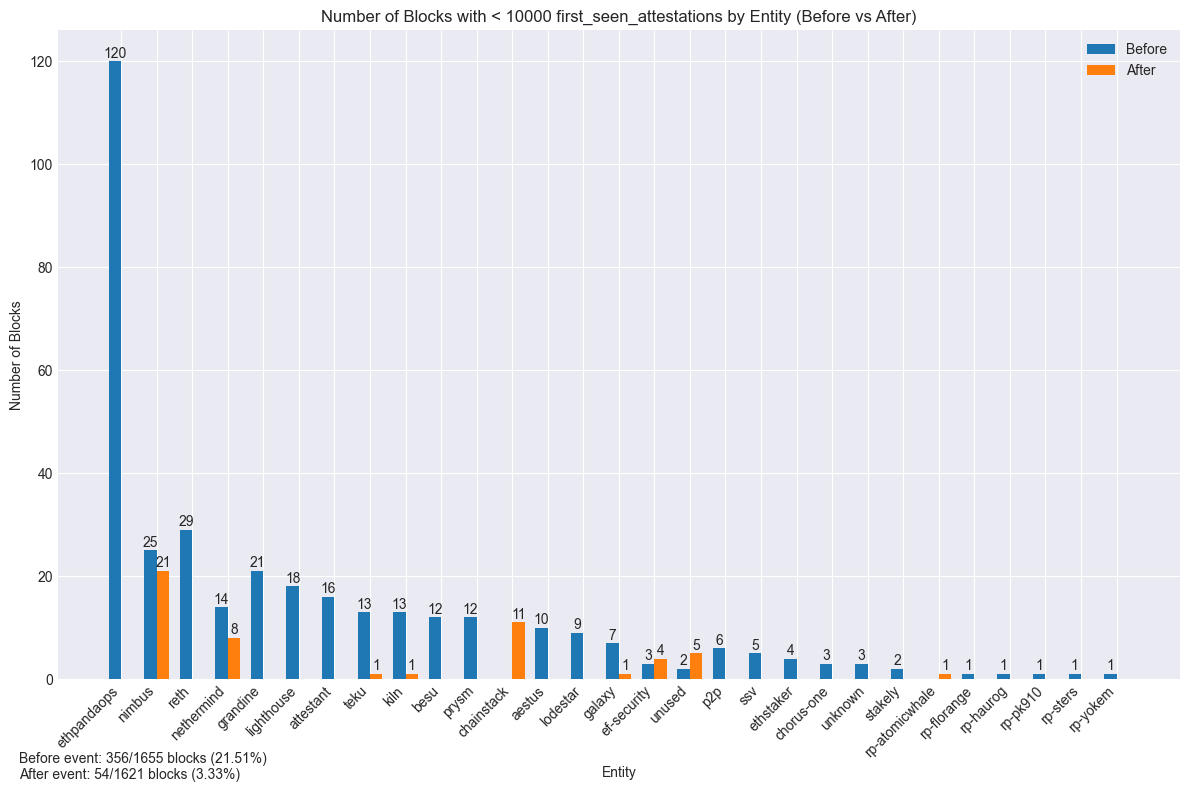

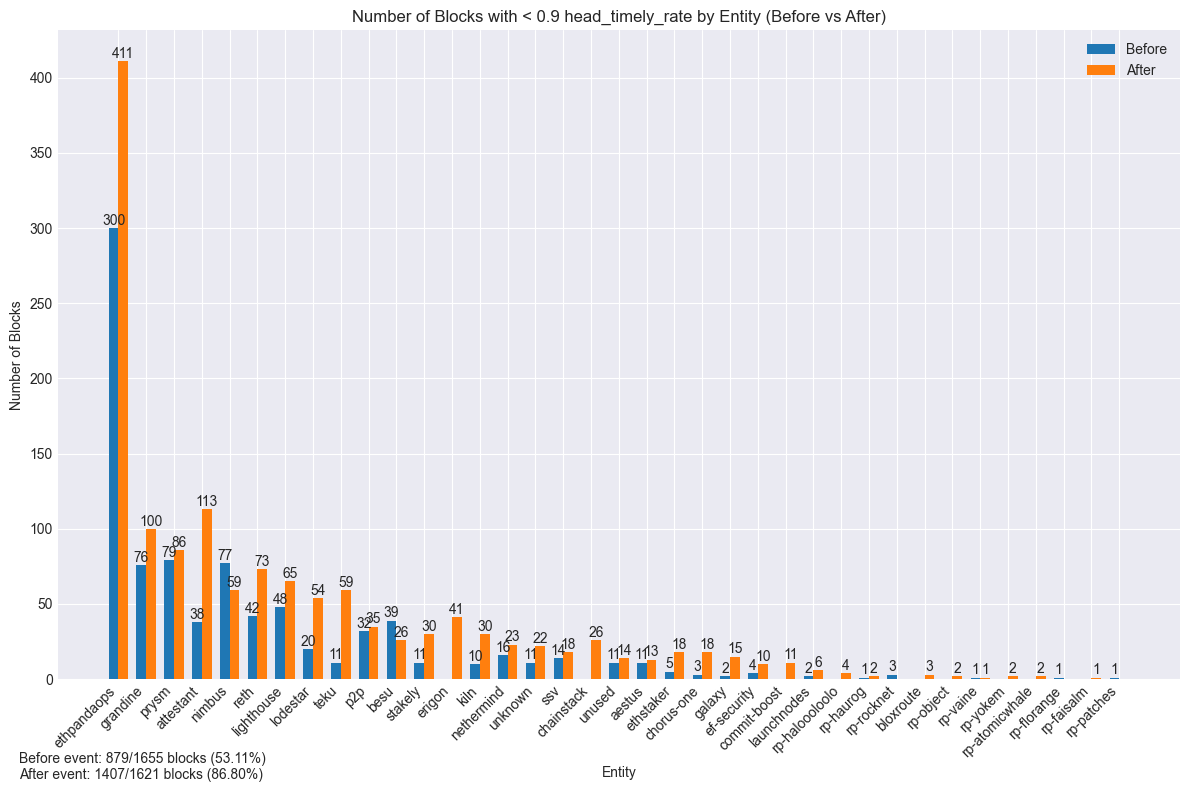

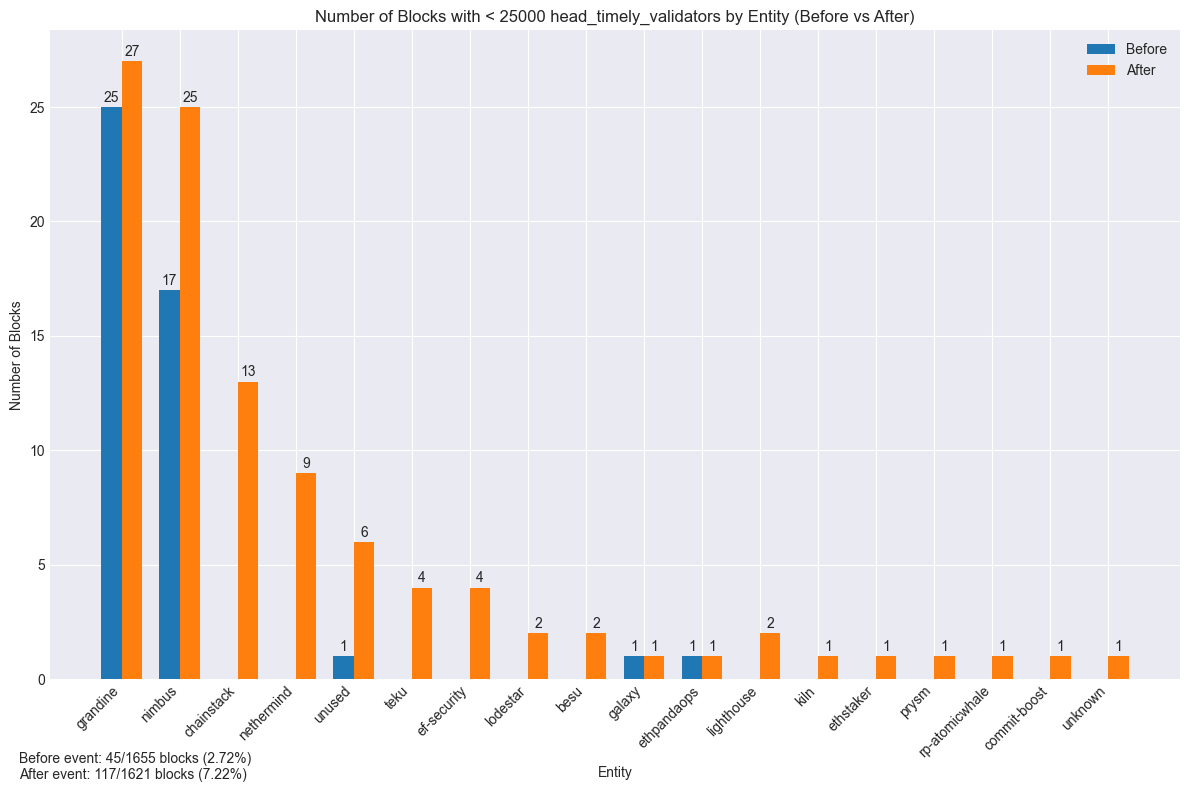

In [13]:
# Create a bar chart of occurrences where entities have values below/above a threshold before and after the event
def plot_metric_by_entity(df, metric, threshold=None, comparison='less', title_prefix="Number of Blocks with"):
    # Make a copy of the dataframe
    filtered_df = df.copy()
    
    # Filter based on the comparison type and threshold if provided
    if threshold is not None:
        if comparison == 'less':
            filtered_df = filtered_df[filtered_df[metric] < threshold]
            comparison_text = f"< {threshold}"
        elif comparison == 'greater':
            filtered_df = filtered_df[filtered_df[metric] > threshold]
            comparison_text = f"> {threshold}"
        elif comparison == 'equal':
            filtered_df = filtered_df[filtered_df[metric] == threshold]
            comparison_text = f"= {threshold}"
    else:
        comparison_text = ""
    
    # Convert index to datetime if it's not already
    if not isinstance(filtered_df.index, pd.DatetimeIndex):
        filtered_df['datetime_index'] = pd.to_datetime(filtered_df['block_slot_start_date_time'])
        # Add period information based on event_date
        filtered_df['period'] = np.where(filtered_df['datetime_index'] < event_date_naive, 'Before', 'After')
    else:
        # Add period information based on event_date
        filtered_df['period'] = np.where(filtered_df.index < event_date_naive, 'Before', 'After')
    
    # Count occurrences by entity and period
    entity_period_counts = filtered_df.groupby(['entity', 'period']).size().reset_index()
    entity_period_counts.columns = ['entity', 'period', 'count']
    
    # Pivot to get before/after as separate columns
    pivot_df = entity_period_counts.pivot(index='entity', columns='period', values='count').fillna(0)
    
    # Ensure both Before and After columns exist
    if 'Before' not in pivot_df.columns:
        pivot_df['Before'] = 0
    if 'After' not in pivot_df.columns:
        pivot_df['After'] = 0
    
    # Sort by total count (Before + After) in descending order
    pivot_df['Total'] = pivot_df['Before'] + pivot_df['After']
    pivot_df = pivot_df.sort_values('Total', ascending=False).drop('Total', axis=1)
    
    # Create the bar chart
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Set width of bars
    bar_width = 0.35
    x = np.arange(len(pivot_df.index))
    
    # Create bars
    before_bars = ax.bar(x - bar_width/2, pivot_df['Before'], bar_width, label='Before')
    after_bars = ax.bar(x + bar_width/2, pivot_df['After'], bar_width, label='After')
    
    # Add count labels on top of each bar
    for bars in [before_bars, after_bars]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                        f'{height:.0f}', ha='center', va='bottom')
    
    # Add labels and title
    title = f'{title_prefix} {comparison_text} {metric} by Entity (Before vs After)'
    ax.set_title(title)
    ax.set_xlabel('Entity')
    ax.set_ylabel('Number of Blocks')
    ax.set_xticks(x)
    ax.set_xticklabels(pivot_df.index, rotation=45, ha='right')
    ax.legend()
    
    # For calculating stats, use the same datetime comparison approach
    if not isinstance(df.index, pd.DatetimeIndex):
        temp_df = df.copy()
        temp_df['datetime_index'] = pd.to_datetime(temp_df['block_slot_start_date_time'])
        before_total = len(temp_df[temp_df['datetime_index'] < event_date_naive])
        after_total = len(temp_df[temp_df['datetime_index'] >= event_date_naive])
    else:
        before_total = len(df[df.index < event_date_naive])
        after_total = len(df[df.index >= event_date_naive])
    
    before_filtered = len(filtered_df[filtered_df['period'] == 'Before'])
    after_filtered = len(filtered_df[filtered_df['period'] == 'After'])
    
    before_pct = (before_filtered / before_total) * 100 if before_total > 0 else 0
    after_pct = (after_filtered / after_total) * 100 if after_total > 0 else 0
    
    plt.figtext(0.02, 0.02, 
                f'Before event: {before_filtered}/{before_total} blocks ({before_pct:.2f}%)\n'
                f'After event: {after_filtered}/{after_total} blocks ({after_pct:.2f}%)',
                fontsize=10)
    
    plt.tight_layout()
    return plt

# Example usage for first_seen_attestations
plot_metric_by_entity(slot_metrics_df, 'first_seen_attestations', threshold=10000, comparison='less')

# Example usage for head_timely_rate
plot_metric_by_entity(slot_metrics_df, 'head_timely_rate', threshold=0.9, comparison='less')

plot_metric_by_entity(slot_metrics_df, 'head_timely_validators', threshold=25000, comparison='less')


/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_99591/2710101587.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_99591/2710101587.py:46: FutureWarning: The provided callable <function median at 0x10ac760c0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  entity_metrics = temp_df.groupby(['entity', 'period'])[metric].agg(agg_func).reset_index()
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_99591/2710101587.py:122: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_99591/2710101587.py:122: UserWarning: This figure includes Axes that are not compat

<module 'matplotlib.pyplot' from '/Users/samcm/.asdf/installs/python/3.11.4/lib/python3.11/site-packages/matplotlib/pyplot.py'>

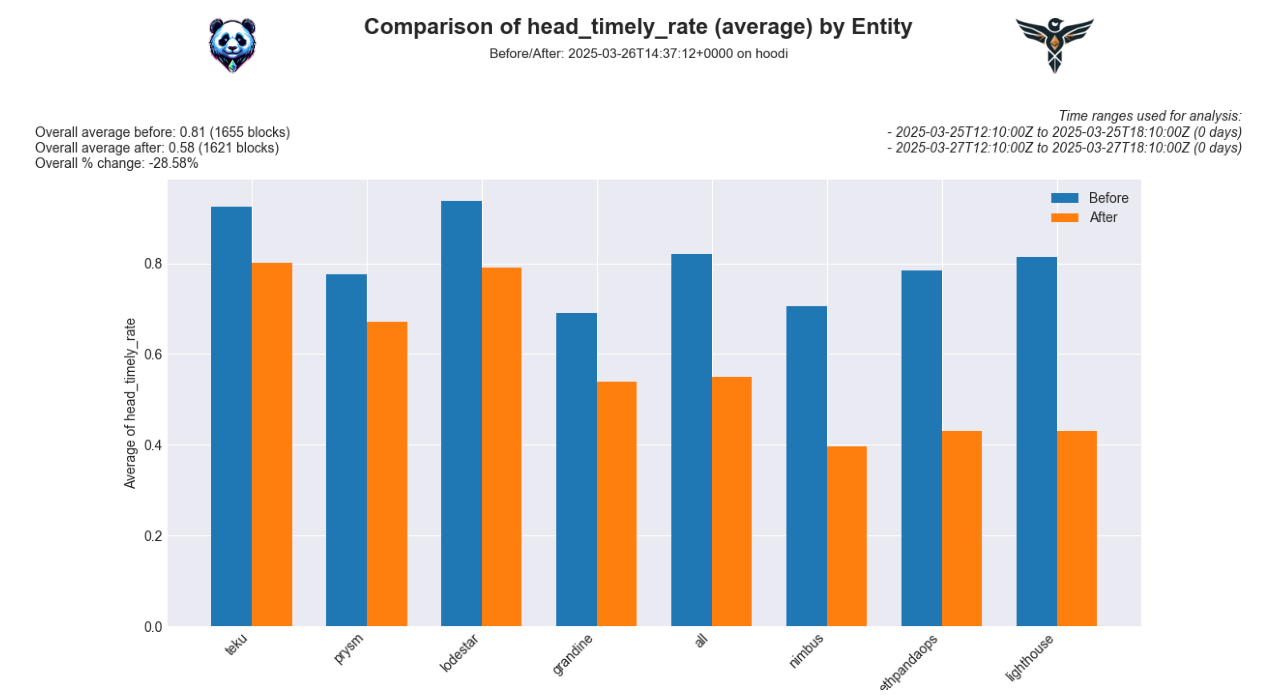

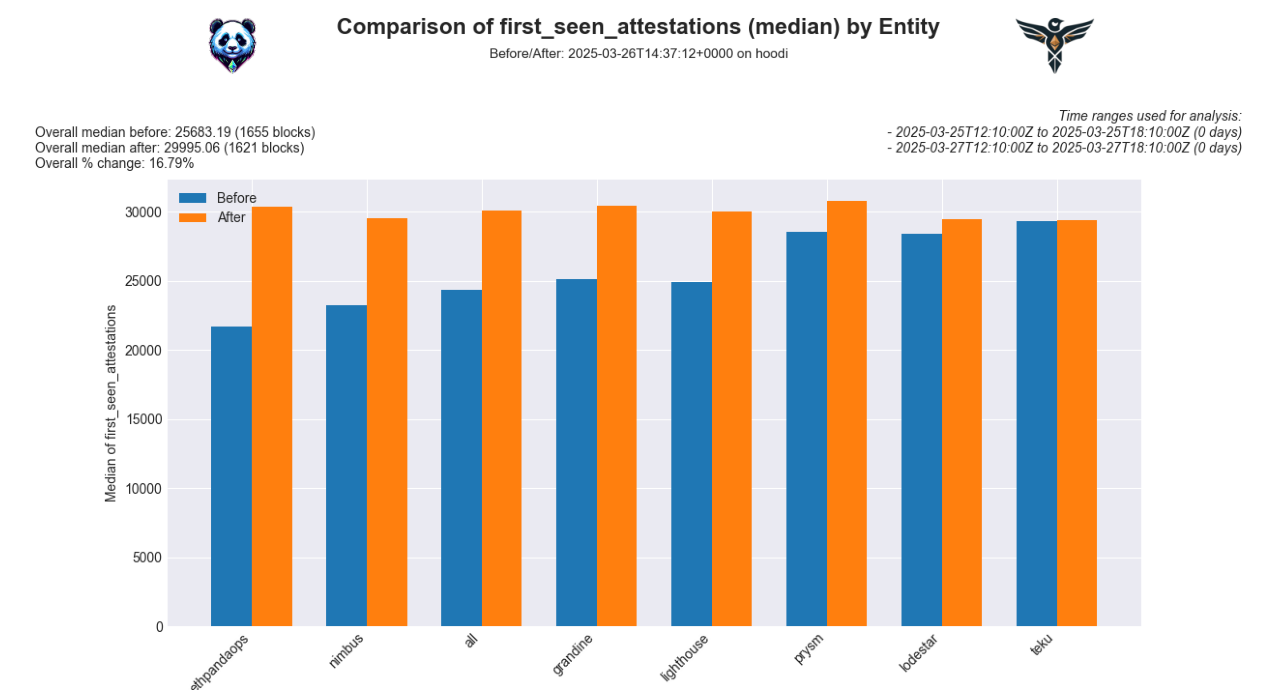

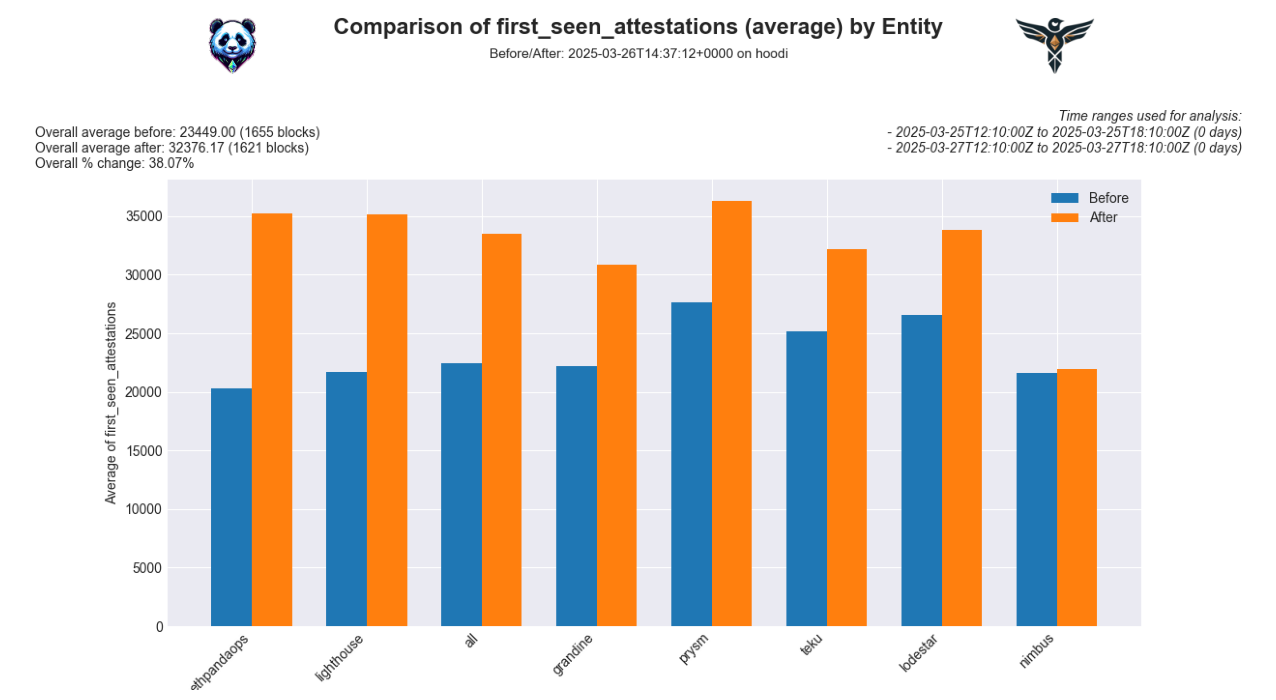

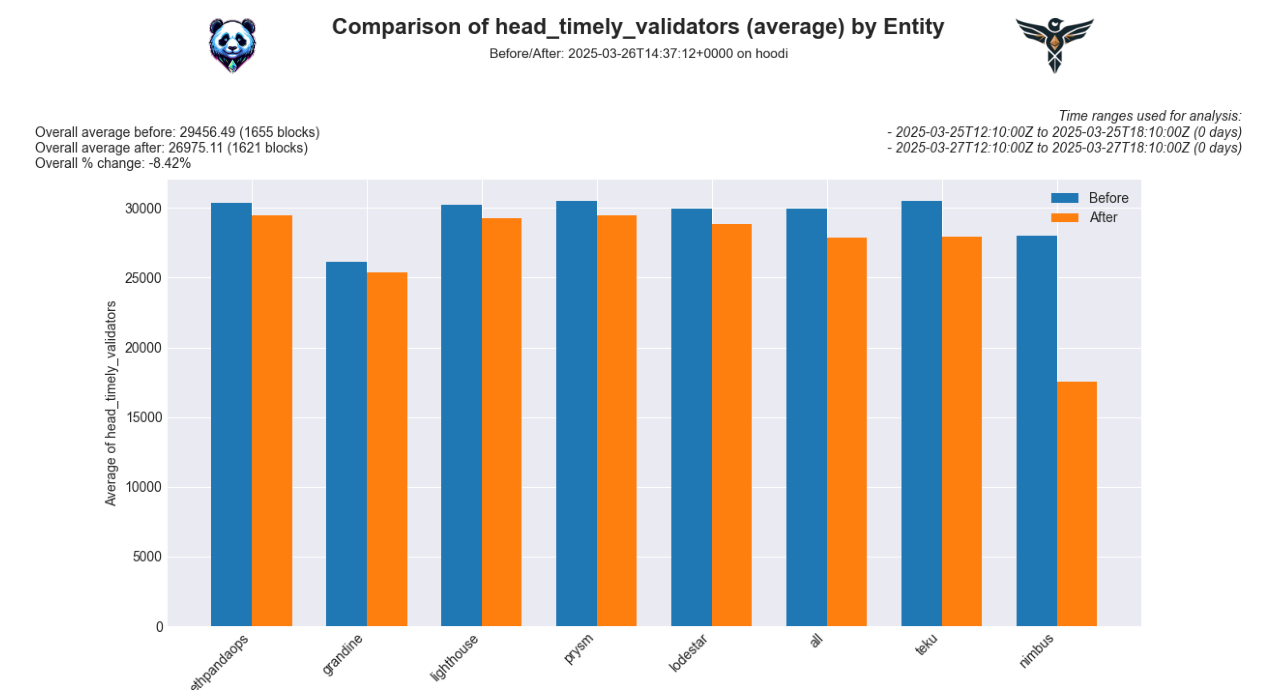

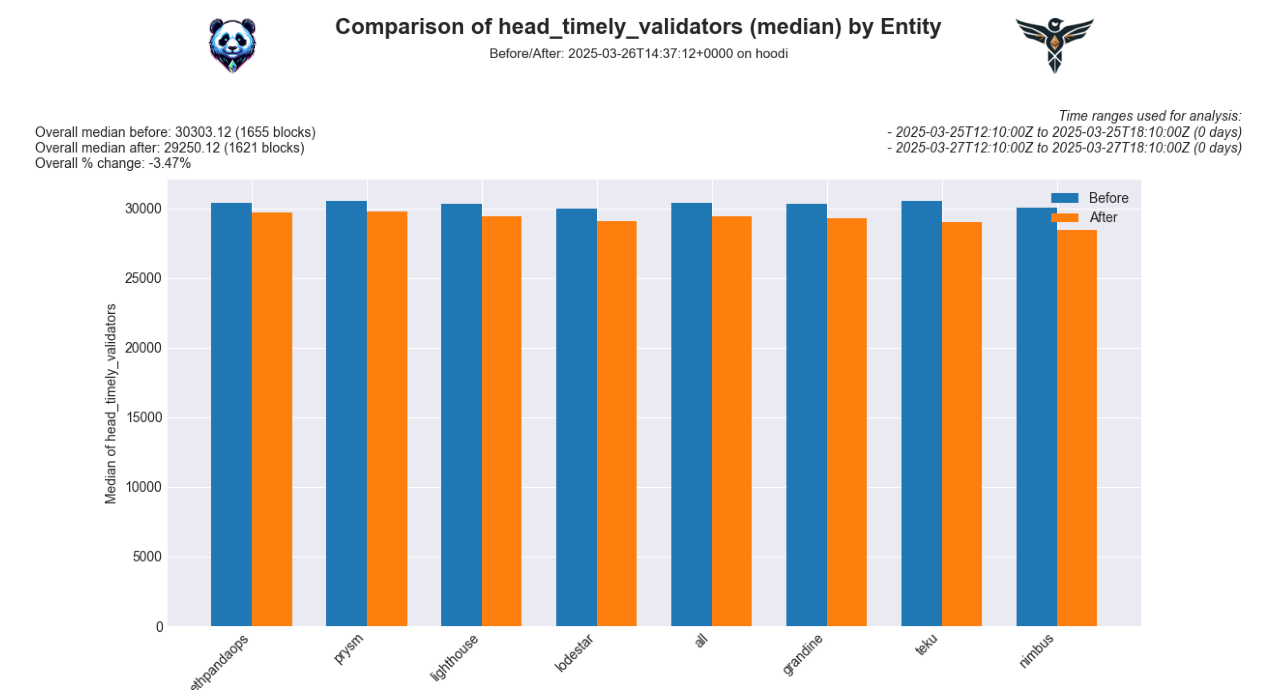

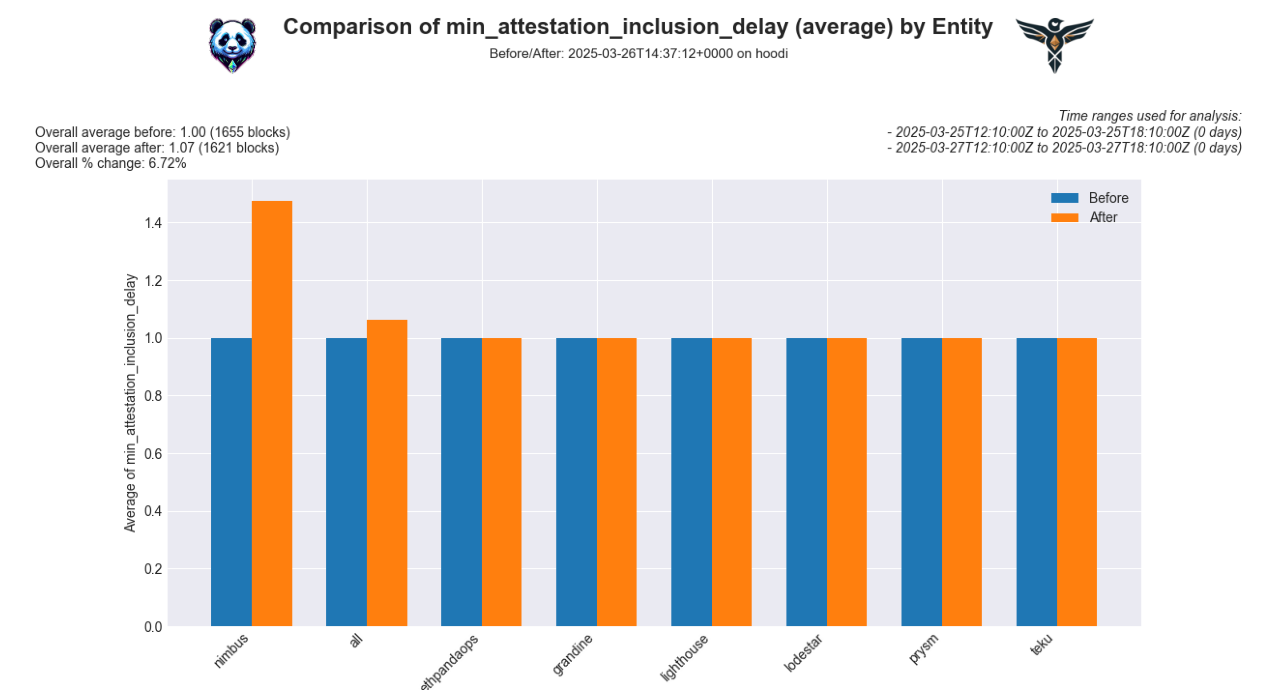

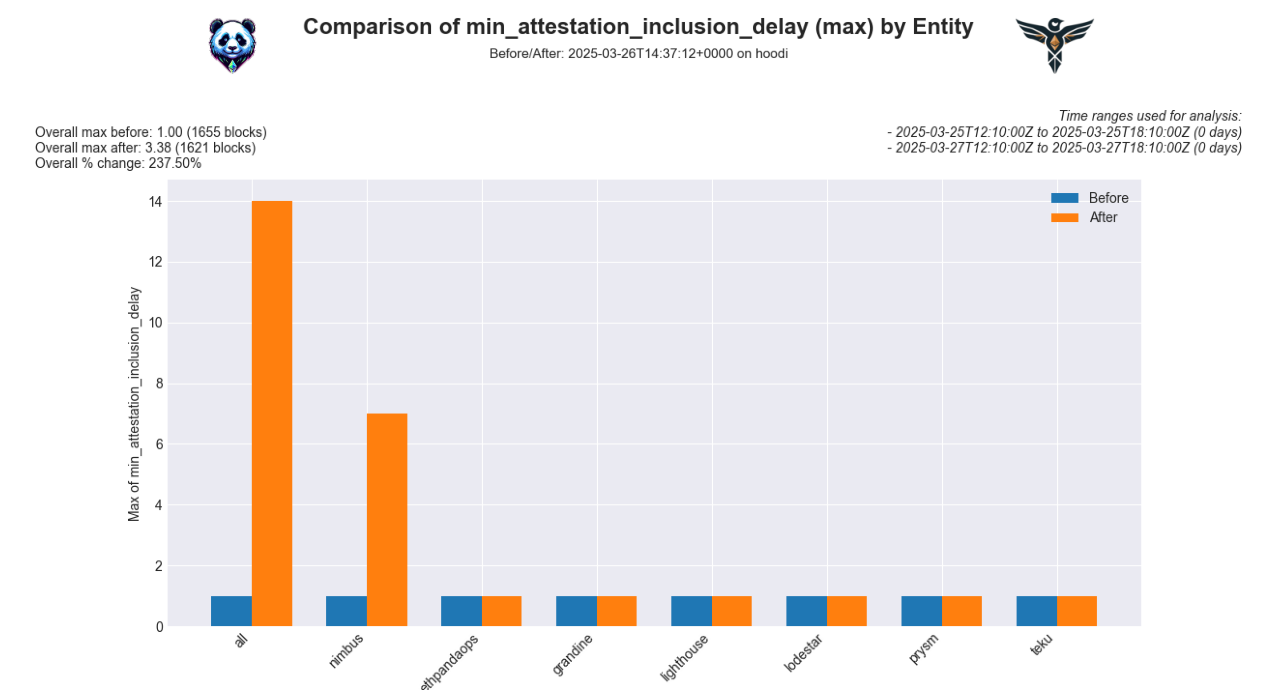

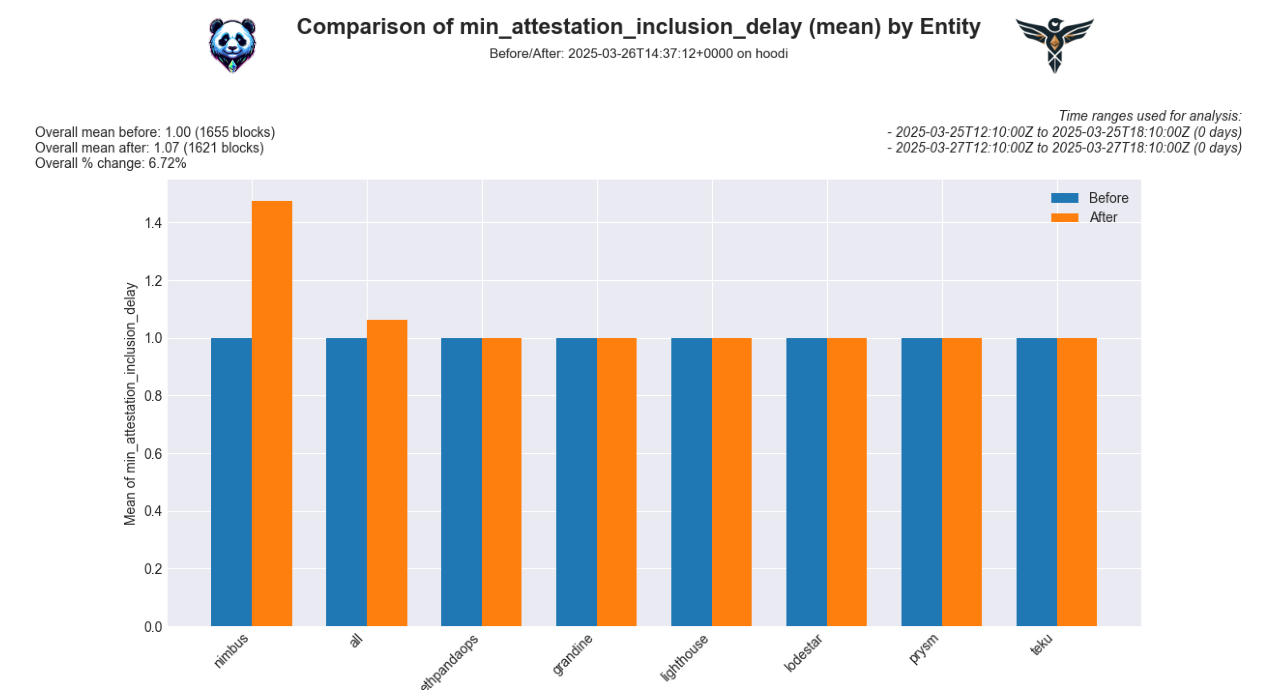

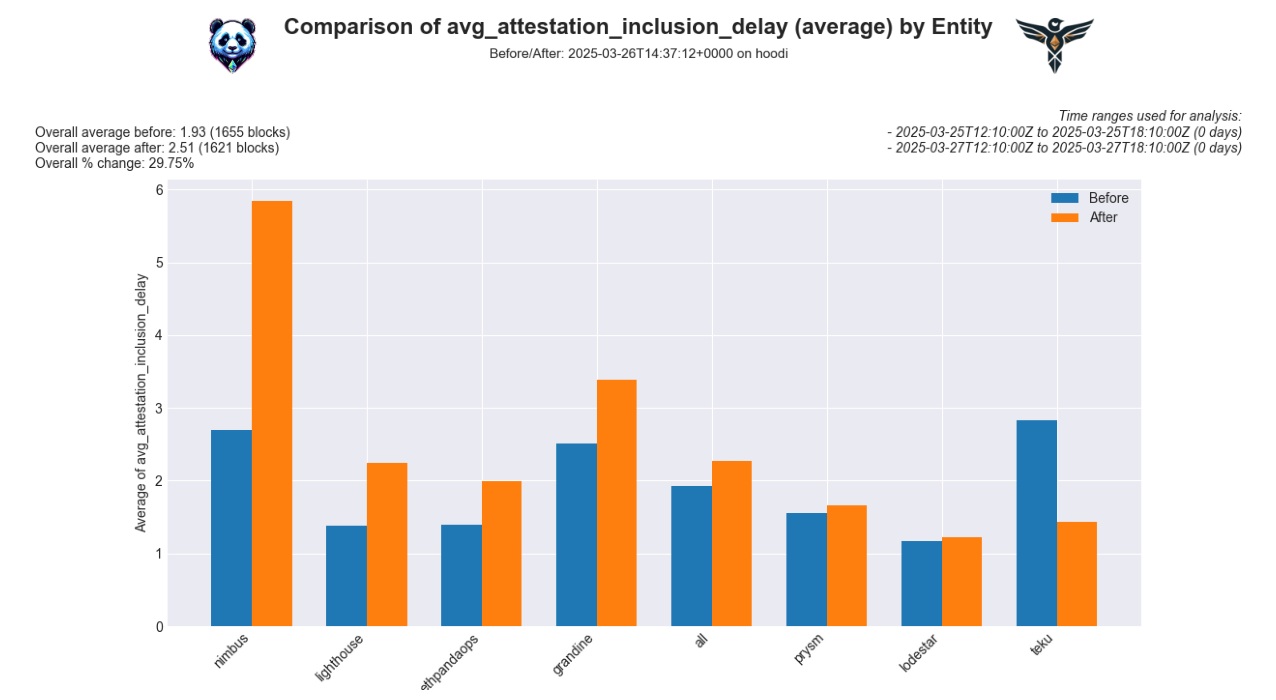

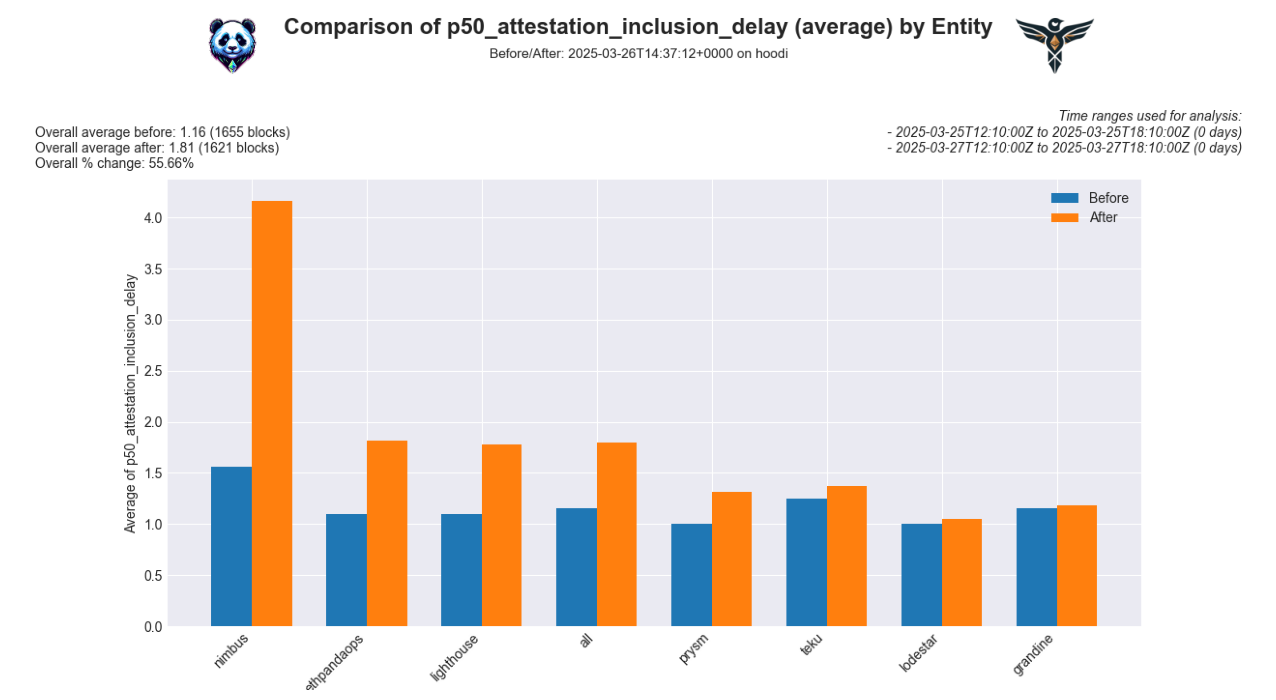

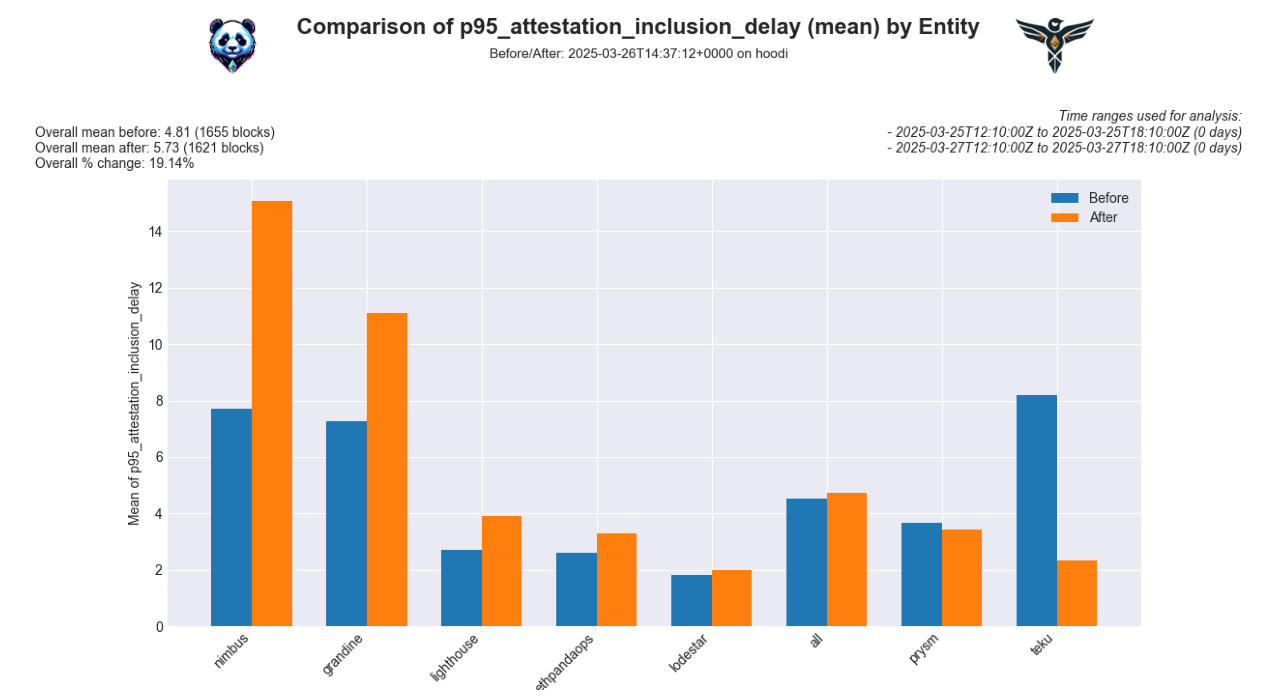

In [42]:
def compare_entity_metrics_before_after(df, metric, aggregation='mean', title_prefix="Comparison of", figsize=(13, 6), entities=None):
    """
    Compare a metric before and after the event for each entity with optional aggregation.
    
    Parameters:
    -----------
    df : DataFrame
        The dataframe containing the data
    metric : str
        The column name of the metric to analyze
    aggregation : str, default 'mean'
        The aggregation function to apply ('mean', 'median', 'sum', 'max', 'min', 'count')
    title_prefix : str, default "Comparison of"
        Prefix for the plot title
    figsize : tuple, default (12, 10)
        Figure size
        
    Returns:
    --------
    matplotlib.pyplot object
    """
    # Make a copy of the dataframe
    temp_df = df.copy()

    if entities is None:
        entities = temp_df['entity'].unique()
    elif "all" in entities:
        # Add "all" as an entity for comparison
        all_df = temp_df.copy()
        all_df['entity'] = 'all'
        temp_df = pd.concat([temp_df, all_df])
        entities = [e for e in entities if e != "all"] + ["all"]

    # Filter the dataframe to only include the specified entities
    temp_df = temp_df[temp_df['entity'].isin(entities)]
    
    # Ensure datetime column exists and add period information based on event_date
    if not isinstance(temp_df.index, pd.DatetimeIndex):
        temp_df['datetime_index'] = pd.to_datetime(temp_df['block_slot_start_date_time'])
        temp_df['period'] = np.where(temp_df['datetime_index'] < event_date_naive, 'Before', 'After')
    else:
        temp_df['period'] = np.where(temp_df.index < event_date_naive, 'Before', 'After')
    
    # Apply aggregation by entity and period
    agg_func = getattr(np, aggregation)
    entity_metrics = temp_df.groupby(['entity', 'period'])[metric].agg(agg_func).reset_index()
    
    # Pivot to get before/after as separate columns
    pivot_df = entity_metrics.pivot(index='entity', columns='period', values=metric).fillna(0)
    
    # Ensure both Before and After columns exist
    if 'Before' not in pivot_df.columns:
        pivot_df['Before'] = 0
    if 'After' not in pivot_df.columns:
        pivot_df['After'] = 0
    
    # Calculate percent change
    pivot_df['% Change'] = (pivot_df['After'] - pivot_df['Before']) / pivot_df['Before'] * 100
    
    # Sort by absolute percent change
    pivot_df = pivot_df.sort_values(by='% Change', ascending=False)
    
    # Create the bar chart
    fig, ax = plt.subplots(figsize=figsize)
    
    # Set width of bars
    bar_width = 0.35
    x = np.arange(len(pivot_df.index))
    
    # Create bars
    before_bars = ax.bar(x - bar_width/2, pivot_df['Before'], bar_width, label='Before')
    after_bars = ax.bar(x + bar_width/2, pivot_df['After'], bar_width, label='After')
    
    # Add labels and title
    title = f'{title_prefix} {metric} ({aggregation}) by Entity'
    # ax.set_title(title)
    ax.set_xlabel('Entity')
    ax.set_ylabel(f'{aggregation.capitalize()} of {metric}')
    ax.set_xticks(x)
    ax.set_xticklabels(pivot_df.index, rotation=45, ha='right')
    ax.legend()
    
    # Add a table with the percent changes
    table_data = []
    for entity in pivot_df.index:
        before = pivot_df.loc[entity, 'Before']
        after = pivot_df.loc[entity, 'After']
        pct_change = pivot_df.loc[entity, '% Change']
        table_data.append([entity, f"{before:.2f}", f"{after:.2f}", f"{pct_change:.2f}%"])
    
    # For calculating stats, use the same datetime comparison approach as in plot_metric_by_entity
    if not isinstance(df.index, pd.DatetimeIndex):
        count_df = df.copy()
        count_df['datetime_index'] = pd.to_datetime(count_df['block_slot_start_date_time'])
        before_count = len(count_df[count_df['datetime_index'] < event_date_naive])
        after_count = len(count_df[count_df['datetime_index'] >= event_date_naive])
    else:
        before_count = len(df[df.index < event_date_naive])
        after_count = len(df[df.index >= event_date_naive])
    
    # Add summary stats as text
    before_avg = pivot_df['Before'].mean()
    after_avg = pivot_df['After'].mean()
    overall_pct_change = ((after_avg - before_avg) / before_avg * 100) if before_avg > 0 else float('inf')
    
    plt.figtext(0.02, 0.90, 
                f'Overall {aggregation} before: {before_avg:.2f} ({before_count} blocks)\n'
                f'Overall {aggregation} after: {after_avg:.2f} ({after_count} blocks)\n'
                f'Overall % change: {overall_pct_change:.2f}%',
                fontsize=10)
    
    # Add date range information
    data_ranges_text = "Time ranges used for analysis:\n"
    for start_date, end_date in config.time_ranges:
        days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days
        data_ranges_text += f"- {start_date} to {end_date} ({days} days)\n"
    fig.text(0.98, 0.90, data_ranges_text, fontsize=10, style='italic', ha='right')

    add_branding(fig, title, subtitle="Before/After: " + event_date.strftime("%Y-%m-%dT%H:%M:%S%z") + " on " + config.network)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    return plt

client_teams = [
    "all",
    "prysm",
    "lighthouse",
    "teku",
    "nimbus",
    "lodestar",
    "grandine",
    "ethpandaops"
]

# Example usage
compare_entity_metrics_before_after(slot_metrics_df, 'head_timely_rate', aggregation='average', entities=client_teams)
compare_entity_metrics_before_after(slot_metrics_df, 'first_seen_attestations', aggregation='median', entities=client_teams)
compare_entity_metrics_before_after(slot_metrics_df, 'first_seen_attestations', aggregation='average', entities=client_teams)
compare_entity_metrics_before_after(slot_metrics_df, 'head_timely_validators', aggregation='average', entities=client_teams)
compare_entity_metrics_before_after(slot_metrics_df, 'head_timely_validators', aggregation='median', entities=client_teams)
compare_entity_metrics_before_after(slot_metrics_df, 'min_attestation_inclusion_delay', aggregation='average', entities=client_teams)
compare_entity_metrics_before_after(slot_metrics_df, 'min_attestation_inclusion_delay', aggregation='max', entities=client_teams)
compare_entity_metrics_before_after(slot_metrics_df, 'min_attestation_inclusion_delay', aggregation='mean', entities=client_teams)
compare_entity_metrics_before_after(slot_metrics_df, 'avg_attestation_inclusion_delay', aggregation='average', entities=client_teams)
compare_entity_metrics_before_after(slot_metrics_df, 'p50_attestation_inclusion_delay', aggregation='average', entities=client_teams)
compare_entity_metrics_before_after(slot_metrics_df, 'p95_attestation_inclusion_delay', aggregation='mean', entities=client_teams)


/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_99591/3089050876.py:118: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.01, 0.07, 0.99, 0.93])


<module 'matplotlib.pyplot' from '/Users/samcm/.asdf/installs/python/3.11.4/lib/python3.11/site-packages/matplotlib/pyplot.py'>

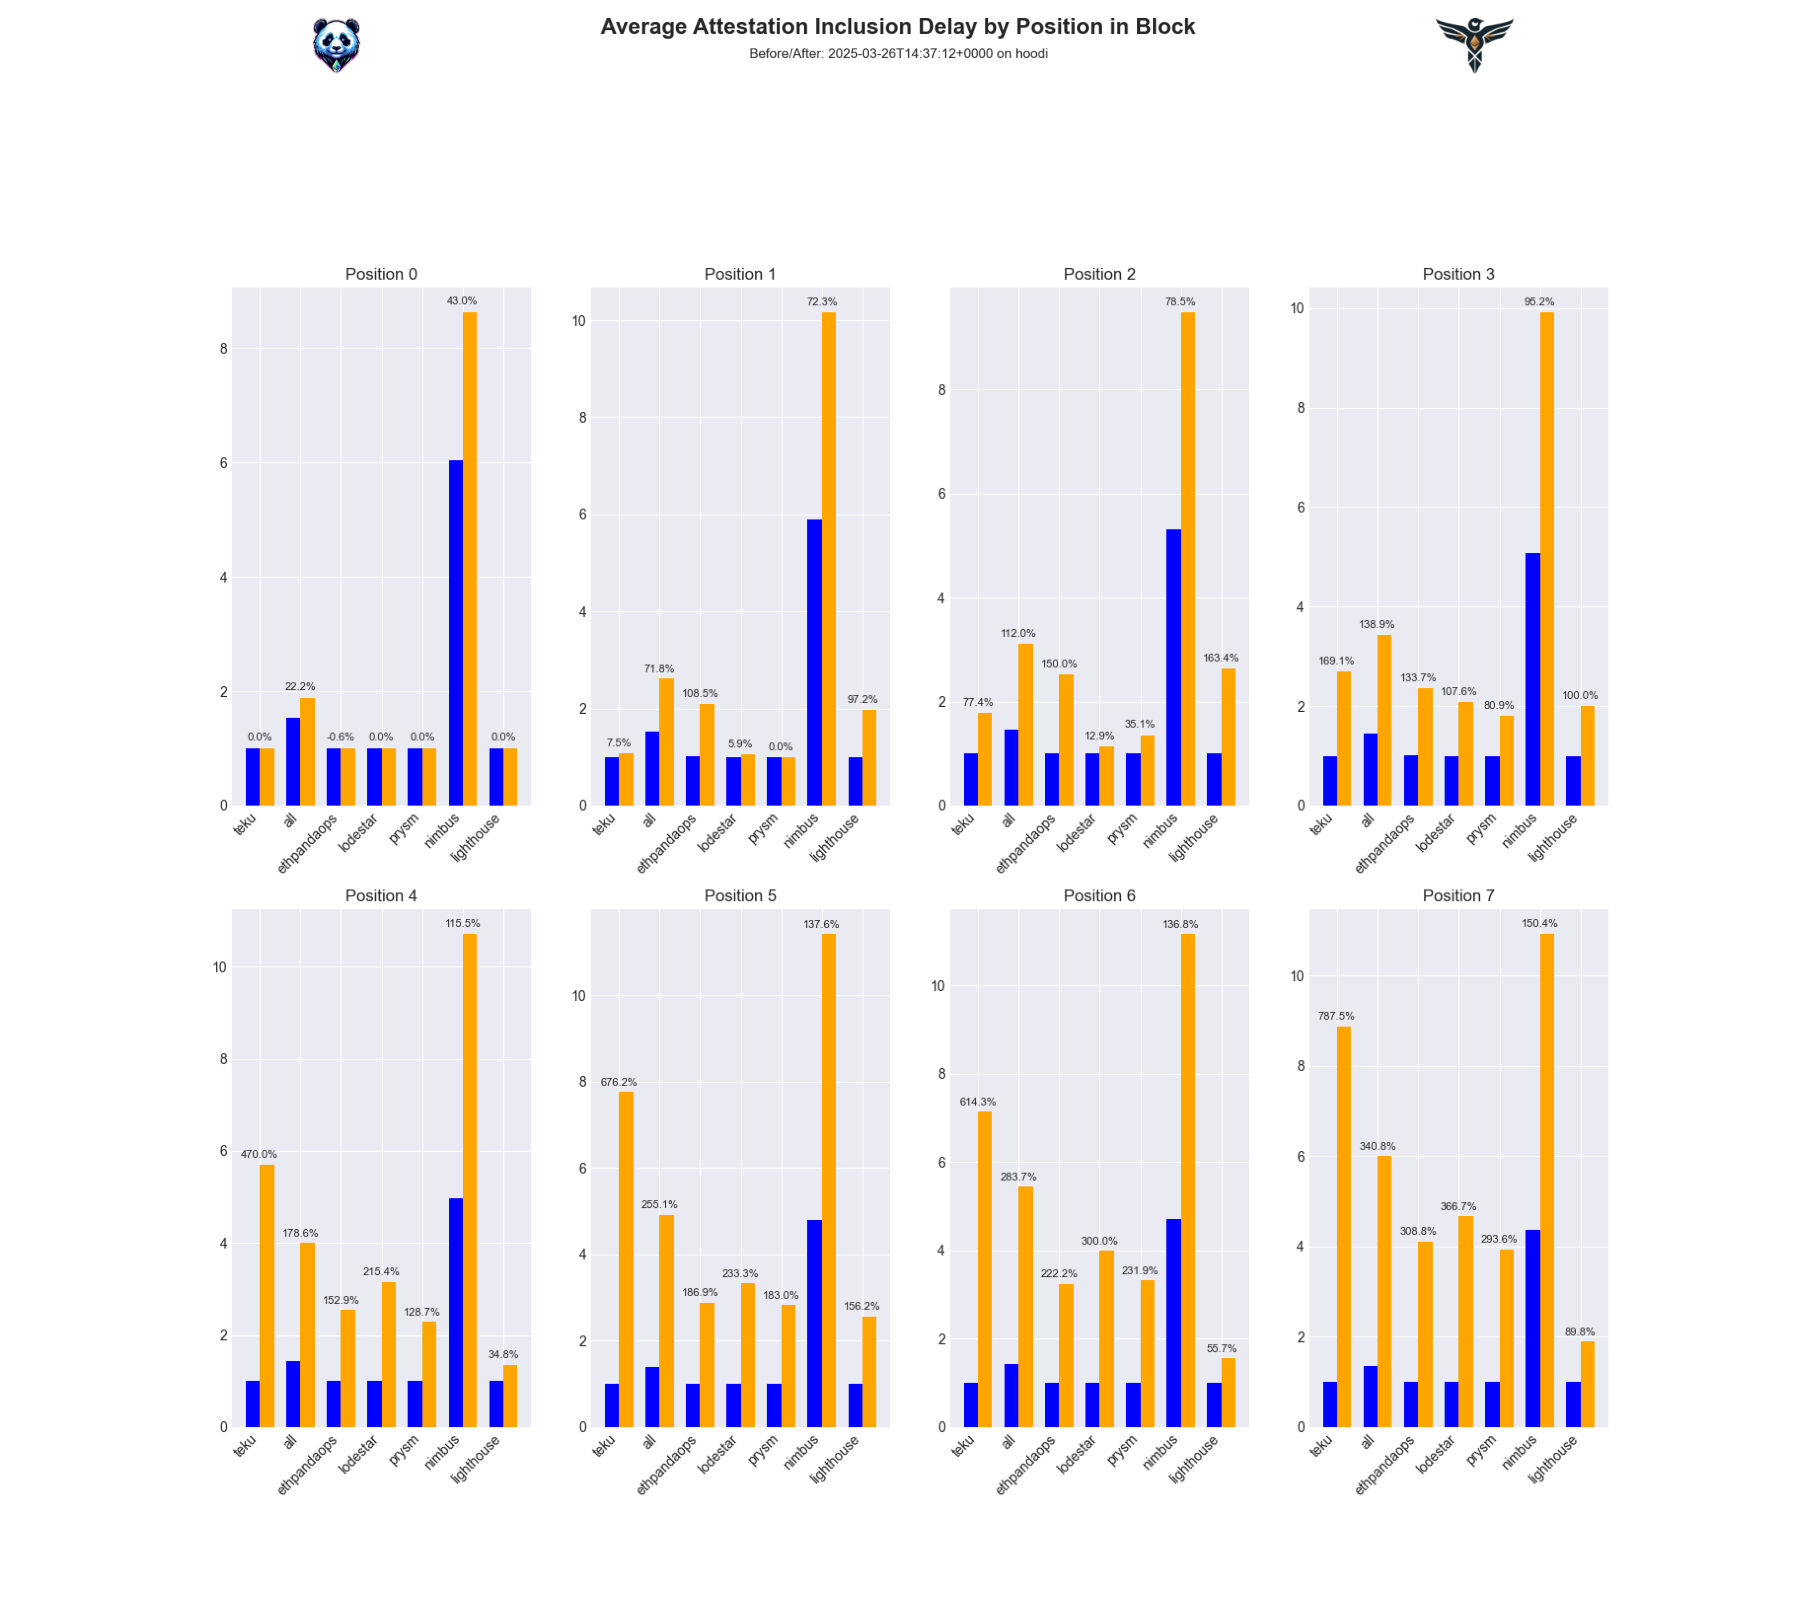

In [38]:
# Create a function to plot position-specific metrics for each entity
def plot_position_metrics_by_entity(df, entities=None, figsize=(18, 15)):
    """
    Plot the average inclusion delay for each position in block by entity, comparing before and after.
    
    Parameters:
    -----------
    df : DataFrame
        The dataframe containing the metrics data
    entities : list, optional
        List of entities to include in the plot
    figsize : tuple, default (18, 15)
        Figure size
    """
    # Make a copy of the dataframe
    temp_df = df.copy()
    
    if entities is None:
        entities = temp_df['entity'].unique()
    elif "all" in entities:
        # Add "all" as an entity for comparison
        all_df = temp_df.copy()
        all_df['entity'] = 'all'
        temp_df = pd.concat([temp_df, all_df])
        entities = [e for e in entities if e != "all"] + ["all"]
    
    # Filter the dataframe to only include the specified entities
    temp_df = temp_df[temp_df['entity'].isin(entities)]
    
    # Add period information based on event_date
    if not isinstance(temp_df.index, pd.DatetimeIndex):
        temp_df['datetime_index'] = pd.to_datetime(temp_df['block_slot_start_date_time'])
        temp_df['period'] = np.where(temp_df['datetime_index'] < event_date_naive, 'Before', 'After')
    else:
        temp_df['period'] = np.where(temp_df.index < event_date_naive, 'Before', 'After')
    
    # Create a figure with subplots for each position
    fig, axes = plt.subplots(2, 4, figsize=figsize, sharex=False, sharey=False)
    axes = axes.flatten()
    
    # Colors for before and after
    colors = {'Before': 'blue', 'After': 'orange'}
    
    # Calculate overall percent change across all positions to determine consistent sorting
    overall_changes = {}
    for entity in entities:
        entity_data = temp_df[temp_df['entity'] == entity]
        before_avg = entity_data[entity_data['period'] == 'Before'][[f'position_{pos}_average_inclusion_delay' for pos in range(8)]].mean().mean()
        after_avg = entity_data[entity_data['period'] == 'After'][[f'position_{pos}_average_inclusion_delay' for pos in range(8)]].mean().mean()
        if before_avg > 0:
            overall_changes[entity] = (after_avg - before_avg) / before_avg * 100
        else:
            overall_changes[entity] = 0
    
    # Sort entities by overall percent change
    sorted_entities = sorted(overall_changes.keys(), key=lambda x: overall_changes[x], reverse=True)
    
    # For each position, create a grouped bar chart
    for pos in range(8):
        position_col = f'position_{pos}_average_inclusion_delay'
        
        # Calculate mean for each entity and period
        position_data = temp_df.groupby(['entity', 'period'])[position_col].mean().reset_index()
        
        # Pivot to get before/after as separate columns
        pivot_df = position_data.pivot(index='entity', columns='period', values=position_col).fillna(0)
        
        # Ensure both Before and After columns exist
        if 'Before' not in pivot_df.columns:
            pivot_df['Before'] = 0
        if 'After' not in pivot_df.columns:
            pivot_df['After'] = 0
        
        # Calculate percent change
        pivot_df['% Change'] = (pivot_df['After'] - pivot_df['Before']) / pivot_df['Before'] * 100
        
        # Reindex using the consistent entity order
        pivot_df = pivot_df.reindex(sorted_entities)
        
        # Set width of bars
        bar_width = 0.35
        x = np.arange(len(pivot_df.index))
        
        # Create bars
        axes[pos].bar(x - bar_width/2, pivot_df['Before'], bar_width, label='Before', color=colors['Before'])
        axes[pos].bar(x + bar_width/2, pivot_df['After'], bar_width, label='After', color=colors['After'])
        
        # Add labels
        axes[pos].set_title(f'Position {pos}')
        axes[pos].set_xticks(x)
        axes[pos].set_xticklabels(pivot_df.index, rotation=45, ha='right')
        
        # Add percent change as text above bars
        for i, entity in enumerate(pivot_df.index):
            pct_change = pivot_df.loc[entity, '% Change']
            axes[pos].text(i, max(pivot_df.loc[entity, 'Before'], pivot_df.loc[entity, 'After']) + 0.1, 
                          f"{pct_change:.1f}%", ha='center', va='bottom', fontsize=8)
    
    # Calculate overall stats for summary
    if not isinstance(df.index, pd.DatetimeIndex):
        count_df = df.copy()
        count_df['datetime_index'] = pd.to_datetime(count_df['block_slot_start_date_time'])
        before_count = len(count_df[count_df['datetime_index'] < event_date_naive])
        after_count = len(count_df[count_df['datetime_index'] >= event_date_naive])
    else:
        before_count = len(df[df.index < event_date_naive])
        after_count = len(df[df.index >= event_date_naive])
    
    # Add overall title
    title = "Average Attestation Inclusion Delay by Position in Block"
    add_branding(fig, title, subtitle="Before/After: " + event_date.strftime("%Y-%m-%dT%H:%M:%S%z") + " on " + config.network)
    
    # Add a common legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=2)
    
    # Maximize the use of available space
    plt.tight_layout(rect=[0.01, 0.07, 0.99, 0.93])
    plt.subplots_adjust(hspace=0.3, wspace=0.1)
    return plt

# Plot position metrics for client teams
plot_position_metrics_by_entity(slot_metrics_df, entities=client_teams)


/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_99591/770737274.py:63: FutureWarning: The provided callable <function mean at 0x1090bd620> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  entity_metrics = temp_df.groupby(['entity', 'period'])[metric].agg(agg_func).reset_index()
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_99591/770737274.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/fq/bp58gxy12nd2b32pw1y8wy040000gn/T/ipykernel_99591/770737274.py:63: FutureWarning: The provided callable <function mean at 0x1090bd620> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  entity_metrics = temp_df.groupby(['entity', 

<module 'matplotlib.pyplot' from '/Users/samcm/.asdf/installs/python/3.11.4/lib/python3.11/site-packages/matplotlib/pyplot.py'>

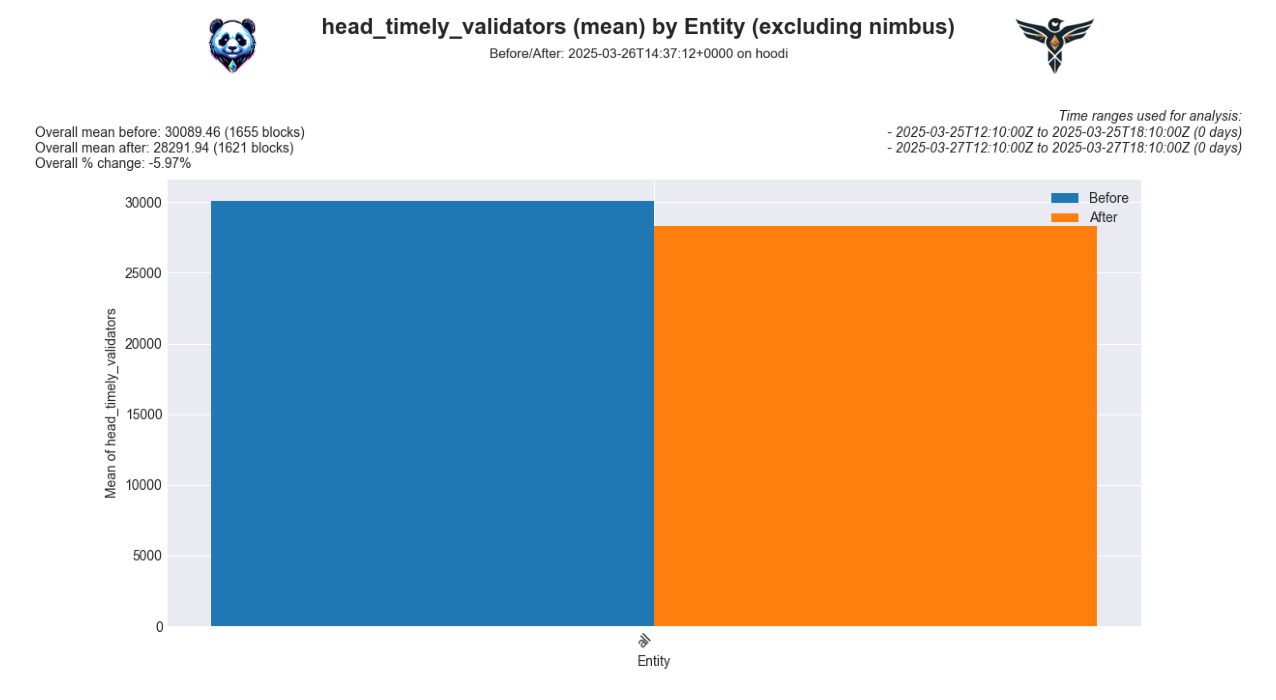

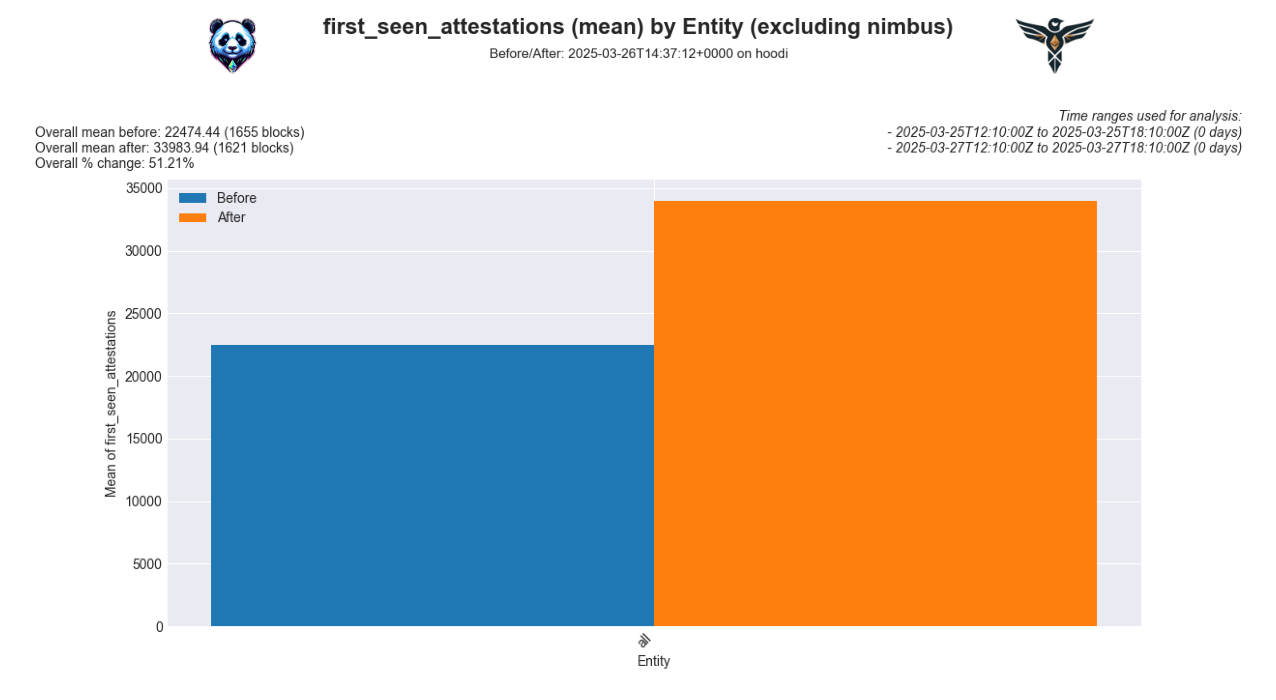

In [ ]:
def compare_entity_metrics_before_after_with_exclusions(df, metric, aggregation='mean', title_suffix="", figsize=(13, 6), include_entities=None, exclude_entities=None):
    """
    Compare a metric before and after the event for each entity with optional aggregation and exclusions.
    
    Parameters:
    -----------
    df : DataFrame
        The dataframe containing the data
    metric : str
        The column name of the metric to analyze
    aggregation : str, default 'mean'
        The aggregation function to apply ('mean', 'median', 'sum', 'max', 'min', 'count')
    title_prefix : str, default "Comparison of"
        Prefix for the plot title
    figsize : tuple, default (13, 6)
        Figure size
    include_entities : list, default None
        List of entities to include. If "all" is in the list, it will add an aggregate of all entities
    exclude_entities : list, default None
        List of entities to exclude from the "all" calculation
        
    Returns:
    --------
    matplotlib.pyplot object
    """
    # Make a copy of the dataframe
    temp_df = df.copy()
    
    # Handle entity filtering
    if include_entities is None:
        include_entities = temp_df['entity'].unique()
    
    if exclude_entities is None:
        exclude_entities = []
    
    # Filter the dataframe to only include the specified entities
    filtered_entities = [e for e in include_entities if e != "all"]
    temp_df = temp_df[temp_df['entity'].isin(filtered_entities)]
    
    # Create the "all" entity if requested
    if "all" in include_entities:
        # Create a copy for the "all" calculation, excluding specified entities
        all_df = df.copy()
        if exclude_entities:
            all_df = all_df[~all_df['entity'].isin(exclude_entities)]
        
        all_df['entity'] = 'all'
        temp_df = pd.concat([temp_df, all_df])
        
        # Add excluded entities to the title for clarity
        if exclude_entities:
            title_suffix += f"(excluding {', '.join(exclude_entities)})"
    
    # Ensure datetime column exists and add period information based on event_date
    if not isinstance(temp_df.index, pd.DatetimeIndex):
        temp_df['datetime_index'] = pd.to_datetime(temp_df['block_slot_start_date_time'])
        temp_df['period'] = np.where(temp_df['datetime_index'] < event_date_naive, 'Before', 'After')
    else:
        temp_df['period'] = np.where(temp_df.index < event_date_naive, 'Before', 'After')
    
    # Apply aggregation by entity and period
    agg_func = getattr(np, aggregation)
    entity_metrics = temp_df.groupby(['entity', 'period'])[metric].agg(agg_func).reset_index()
    
    # Pivot to get before/after as separate columns
    pivot_df = entity_metrics.pivot(index='entity', columns='period', values=metric).fillna(0)
    
    # Ensure both Before and After columns exist
    if 'Before' not in pivot_df.columns:
        pivot_df['Before'] = 0
    if 'After' not in pivot_df.columns:
        pivot_df['After'] = 0
    
    # Calculate percent change
    pivot_df['% Change'] = (pivot_df['After'] - pivot_df['Before']) / pivot_df['Before'] * 100
    
    # Sort by absolute percent change
    pivot_df = pivot_df.sort_values(by='% Change', ascending=False)
    
    # Create the bar chart
    fig, ax = plt.subplots(figsize=figsize)
    
    # Set width of bars
    bar_width = 0.35
    x = np.arange(len(pivot_df.index))
    
    # Create bars
    before_bars = ax.bar(x - bar_width/2, pivot_df['Before'], bar_width, label='Before')
    after_bars = ax.bar(x + bar_width/2, pivot_df['After'], bar_width, label='After')
    
    # Add labels and title
    title = f'{metric} ({aggregation}) by Entity {title_suffix}'
    ax.set_xlabel('Entity')
    ax.set_ylabel(f'{aggregation.capitalize()} of {metric}')
    ax.set_xticks(x)
    ax.set_xticklabels(pivot_df.index, rotation=45, ha='right')
    ax.legend()
    
    # For calculating stats, use the same datetime comparison approach as in plot_metric_by_entity
    if not isinstance(df.index, pd.DatetimeIndex):
        count_df = df.copy()
        count_df['datetime_index'] = pd.to_datetime(count_df['block_slot_start_date_time'])
        before_count = len(count_df[count_df['datetime_index'] < event_date_naive])
        after_count = len(count_df[count_df['datetime_index'] >= event_date_naive])
    else:
        before_count = len(df[df.index < event_date_naive])
        after_count = len(df[df.index >= event_date_naive])
    
    # Add summary stats as text
    before_avg = pivot_df['Before'].mean()
    after_avg = pivot_df['After'].mean()
    overall_pct_change = ((after_avg - before_avg) / before_avg * 100) if before_avg > 0 else float('inf')
    
    plt.figtext(0.02, 0.90, 
                f'Overall {aggregation} before: {before_avg:.2f} ({before_count} blocks)\n'
                f'Overall {aggregation} after: {after_avg:.2f} ({after_count} blocks)\n'
                f'Overall % change: {overall_pct_change:.2f}%',
                fontsize=10)
    
    # Add date range information
    data_ranges_text = "Time ranges used for analysis:\n"
    for start_date, end_date in config.time_ranges:
        days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days
        data_ranges_text += f"- {start_date} to {end_date} ({days} days)\n"
    fig.text(0.98, 0.90, data_ranges_text, fontsize=10, style='italic', ha='right')

    add_branding(fig, title, subtitle="Before/After: " + event_date.strftime("%Y-%m-%dT%H:%M:%S%z") + " on " + config.network)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    return plt

# Example usage - compare all clients except nimbus
compare_entity_metrics_before_after_with_exclusions(
    slot_metrics_df, 
    'head_timely_validators', 
    aggregation='average', 
    include_entities=["all"],
    exclude_entities=["nimbus"]
)
compare_entity_metrics_before_after_with_exclusions(
    slot_metrics_df, 
    'first_seen_attestations', 
    aggregation='mean', 
    include_entities=["all"],
    exclude_entities=["nimbus"]
)